In [1]:
import numpy as np
import torch
from torch import nn
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy

from utils.compl_cal import compl_mul, compl_div
from utils.PINNnet import sine_init, first_layer_sine_init, PINN
from utils.functions import green
from utils.loss_weight import update_lambda, loss_grad_norm
from utils.plot_func import plot_loss

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
# fixed parameters
L, N = 1, 100
Lx, Ly = L, L
src = [0, 0.4]
k = 2 * np.pi * 20 / 1500 * 100
L_pml = 0.5
sigma = 3.5

In [3]:
## hyperparameter
#w = 100
n_in = 2 
n_out = 2
n_hiddens = 256
n_layers = 5
n_epochs = int(5e3)
learning_rate = 2e-5

In [4]:
def get_dataset(Lx, Ly, device=device):
    # pde
    x0, y0 = 2 * Lx * torch.rand(200000, 1) - Lx, 2 * Ly * torch.rand(200000, 1) - Ly
    x, y = torch.linspace(-Lx, Lx, 300), torch.linspace(-Ly, Ly, 300)
    x, y = torch.meshgrid(x, y)
    x, y = x.reshape(-1, 1), y.reshape(-1, 1)
    x0[-len(x):, :], y0[-len(x):, :] = x, y
    return torch.tensor(x0, dtype=torch.float32, requires_grad=False).to(device),\
            torch.tensor(y0, dtype=torch.float32, requires_grad=False).to(device)

def data_iter(batch_size, x, y):
    import random as rd
    num = len(x)
    ids = list(range(num))
    rd.shuffle(ids)
    for i in range(0, num, batch_size):
        batch_id = torch.tensor(ids[i:min(i + batch_size, num)])
        yield x[batch_id], y[batch_id]

In [5]:
def get_PML_coefficient(x, y, L_pml, sigma0):
    dist_hor = torch.clamp(torch.abs(x) - (Lx - L_pml), min=0)
    #dist_ver = torch.clamp(torch.abs(y) - (Ly - L_pml), min=0)
    sx = sigma0 * (dist_hor / L_pml) ** 2
    #sy = sigma0 * (dist_ver / L_pml) ** 2
    sy = torch.zeros_like(sx)
    ex = torch.cat([torch.ones_like(sx), sx], dim=-1)
    ey = torch.cat([torch.ones_like(sy), sy], dim=-1)
    return ex, ey

def loss_fn(model, x, y, k, L_pml=L_pml, sigma0=sigma):
    x, y = x.requires_grad_(), y.requires_grad_()
    xy = torch.cat([x, y], dim=-1)

    ex, ey = get_PML_coefficient(x, y, L_pml, sigma0)

    p = model(xy)
    px_real = torch.autograd.grad(p[:, 0:1].sum(), x, create_graph=True)[0]
    px_imag = torch.autograd.grad(p[:, 1:2].sum(), x, create_graph=True)[0]
    px = compl_mul(compl_div(ey, ex), torch.cat([px_real, px_imag], dim=-1))
    pxx_real = torch.autograd.grad(px[:, 0:1].sum(), x, create_graph=True)[0]
    pxx_imag = torch.autograd.grad(px[:, 1:2].sum(), x, create_graph=True)[0]
    pxx = torch.cat([pxx_real, pxx_imag], dim=-1)
    py_real = torch.autograd.grad(p[:, 0:1].sum(), y, create_graph=True)[0]
    py_imag = torch.autograd.grad(p[:, 1:2].sum(), y, create_graph=True)[0]
    py = compl_mul(compl_div(ex, ey), torch.cat([py_real, py_imag], dim=-1))
    pyy_real = torch.autograd.grad(py[:, 0:1].sum(), y, create_graph=True)[0]
    pyy_imag = torch.autograd.grad(py[:, 1:2].sum(), y, create_graph=True)[0]
    pyy = torch.cat([pyy_real, pyy_imag], dim=-1)
    
    res = pxx + pyy + k**2 * compl_mul(compl_mul(ex, ey), p)
    return (res[:, 0] ** 2).mean(), (res[:, 1] ** 2).mean()

def loss_bd(model, Lx, Ly, src, n_coll=1000, device=device):
    L0 = Lx # - L_pml
    x, y = torch.linspace(-L0, L0, n_coll), torch.ones(n_coll)
    x, y = torch.cat([x, x], dim=-1), torch.cat([y, -y], dim=-1)
    x, y = x.reshape(-1, 1), y.reshape(-1, 1)
    x = torch.tensor(x, dtype=torch.float32, requires_grad=True).to(device)
    y = torch.tensor(y, dtype=torch.float32, requires_grad=True).to(device)
    xy = torch.cat([x, y], dim=-1)
    p = model(xy)
    res = p + green(x, y, src, k)
    return (res ** 2).mean()

In [6]:
model = PINN(n_in, n_out, n_hiddens, n_layers).to(device)
model.apply(sine_init)
model.net[0].apply(first_layer_sine_init)
#import joblib
#state_dict = joblib.load('model_green.joblib')
#model = PINN(n_in, n_out, n_hiddens, n_layers).to(device)
#model.load_state_dict(state_dict)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
lamb = [1, 1, 1]
#loss_bound_hist = []
#loss_pde_hist = []
#loss_src_hist = []
#lamb_bound_hist = []
#lamb_pde_hist = []
#lamb_src_hist = []
l_lst = []
n_lamb_update = 50

In [7]:
n_epochs = int(5e3)
learning_rate = 2e-5
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#from torch.optim.lr_scheduler import MultiStepLR
#milestones = [1000]
#scheduler = MultiStepLR(optimizer, milestones, gamma=0.1, last_epoch=-1)

In [8]:
model = model.to(device)

In [9]:
x0, y0 = get_dataset(Lx, Ly)
i = 0
for epoch in tqdm(range(n_epochs)):
    if epoch == 1000:
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
    if epoch == 3000:
        optimizer = torch.optim.Adam(model.parameters(), lr=5e-6)
    if epoch == 4000:
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)
    for x, y in data_iter(10000, x0, y0):
        optimizer.zero_grad()
        loss_pde1, loss_pde2 = loss_fn(model, x, y, k)
        loss_top = loss_bd(model, Lx, Ly, src)
        loss_lst = [loss_pde1, loss_pde2, loss_top]
        i += 1
        if i % 50 == 0: 
            lamb = update_lambda(model, loss_lst, lamb, 0.9)
        loss = lamb[0] * loss_pde1 + lamb[1] * loss_pde2 + lamb[2] * loss_top
        
        loss.backward()
        optimizer.step()
    
    if (epoch+1) % 5 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item()}, Loss_pde1: {loss_pde1.item()}, Loss_pde2: {loss_pde2.item()}')
    
    l_lst.append(loss)

/home/zhufanjie/miniconda3/envs/work/lib/python3.11/site-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/tmp/ipykernel_71491/2820157460.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x0, dtype=torch.float32, requires_grad=False).to(device),\
/tmp/ipykernel_71491/2820157460.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y0, dtype=torch.float32, requires_grad=False).to(device)
/tmp/ipykernel_71491/999491696.py:3

Epoch 5, Loss: 1.2786496877670288, Loss_pde1: 0.32436591386795044, Loss_pde2: 0.3363907039165497


  0%|          | 10/5000 [00:38<5:28:17,  3.95s/it]

Epoch 10, Loss: 0.8754271268844604, Loss_pde1: 0.11900702863931656, Loss_pde2: 0.12178122252225876


  0%|          | 15/5000 [00:56<5:29:29,  3.97s/it]

Epoch 15, Loss: 0.7542917728424072, Loss_pde1: 0.07322613149881363, Loss_pde2: 0.06468962132930756


  0%|          | 20/5000 [01:16<5:30:27,  3.98s/it]

Epoch 20, Loss: 0.6976280212402344, Loss_pde1: 0.058306846767663956, Loss_pde2: 0.04494141787290573


  0%|          | 25/5000 [01:35<5:31:28,  4.00s/it]

Epoch 25, Loss: 0.6397610902786255, Loss_pde1: 0.05681094154715538, Loss_pde2: 0.03620130568742752


  1%|          | 30/5000 [01:54<5:31:51,  4.01s/it]

Epoch 30, Loss: 0.5735712051391602, Loss_pde1: 0.05945291742682457, Loss_pde2: 0.030713725835084915


  1%|          | 35/5000 [02:13<5:32:07,  4.01s/it]

Epoch 35, Loss: 0.5628469586372375, Loss_pde1: 0.06798499822616577, Loss_pde2: 0.02899095043540001


  1%|          | 40/5000 [02:32<5:32:19,  4.02s/it]

Epoch 40, Loss: 0.5748192071914673, Loss_pde1: 0.08143643289804459, Loss_pde2: 0.03605157136917114


  1%|          | 45/5000 [02:51<5:32:57,  4.03s/it]

Epoch 45, Loss: 0.5928850173950195, Loss_pde1: 0.10305536538362503, Loss_pde2: 0.043846093118190765


  1%|          | 50/5000 [03:11<5:34:43,  4.06s/it]

Epoch 50, Loss: 0.5638165473937988, Loss_pde1: 0.1309180110692978, Loss_pde2: 0.04068634659051895


  1%|          | 55/5000 [03:30<5:34:20,  4.06s/it]

Epoch 55, Loss: 0.5207017660140991, Loss_pde1: 0.15897853672504425, Loss_pde2: 0.03652889281511307


  1%|          | 60/5000 [03:50<5:36:49,  4.09s/it]

Epoch 60, Loss: 0.5298066139221191, Loss_pde1: 0.16566404700279236, Loss_pde2: 0.05155298486351967


  1%|▏         | 65/5000 [04:10<5:39:04,  4.12s/it]

Epoch 65, Loss: 0.489734411239624, Loss_pde1: 0.17172211408615112, Loss_pde2: 0.045441724359989166


  1%|▏         | 70/5000 [04:29<5:39:48,  4.14s/it]

Epoch 70, Loss: 0.38546013832092285, Loss_pde1: 0.149737149477005, Loss_pde2: 0.031137999147176743


  2%|▏         | 75/5000 [04:49<5:37:09,  4.11s/it]

Epoch 75, Loss: 0.3041977882385254, Loss_pde1: 0.12237487733364105, Loss_pde2: 0.022553259506821632


  2%|▏         | 80/5000 [05:09<5:38:01,  4.12s/it]

Epoch 80, Loss: 0.3585987687110901, Loss_pde1: 0.13554544746875763, Loss_pde2: 0.039817944169044495


  2%|▏         | 85/5000 [05:28<5:36:07,  4.10s/it]

Epoch 85, Loss: 0.2588806450366974, Loss_pde1: 0.10710153728723526, Loss_pde2: 0.022389326244592667


  2%|▏         | 90/5000 [05:49<5:43:57,  4.20s/it]

Epoch 90, Loss: 0.35098880529403687, Loss_pde1: 0.11048157513141632, Loss_pde2: 0.04823857918381691


  2%|▏         | 95/5000 [06:09<5:42:16,  4.19s/it]

Epoch 95, Loss: 0.21967563033103943, Loss_pde1: 0.0817398875951767, Loss_pde2: 0.024192610755562782


  2%|▏         | 100/5000 [06:30<5:50:16,  4.29s/it]

Epoch 100, Loss: 0.231903538107872, Loss_pde1: 0.08446145802736282, Loss_pde2: 0.028668783605098724


  2%|▏         | 105/5000 [06:50<5:48:35,  4.27s/it]

Epoch 105, Loss: 0.17663531005382538, Loss_pde1: 0.06871543079614639, Loss_pde2: 0.018876591697335243


  2%|▏         | 110/5000 [07:11<5:47:04,  4.26s/it]

Epoch 110, Loss: 0.16376599669456482, Loss_pde1: 0.06356499344110489, Loss_pde2: 0.017586620524525642


  2%|▏         | 115/5000 [07:31<5:45:55,  4.25s/it]

Epoch 115, Loss: 0.26351481676101685, Loss_pde1: 0.07342786341905594, Loss_pde2: 0.03685580939054489


  2%|▏         | 120/5000 [07:51<5:44:33,  4.24s/it]

Epoch 120, Loss: 0.2416052222251892, Loss_pde1: 0.07800090312957764, Loss_pde2: 0.03507794067263603


  2%|▎         | 125/5000 [08:12<5:44:00,  4.23s/it]

Epoch 125, Loss: 0.21732211112976074, Loss_pde1: 0.07233092188835144, Loss_pde2: 0.029853176325559616


  3%|▎         | 130/5000 [08:33<5:57:17,  4.40s/it]

Epoch 130, Loss: 0.21880561113357544, Loss_pde1: 0.06324142962694168, Loss_pde2: 0.03062291257083416


  3%|▎         | 135/5000 [08:54<5:53:33,  4.36s/it]

Epoch 135, Loss: 0.09646023064851761, Loss_pde1: 0.03675679862499237, Loss_pde2: 0.012179500423371792


  3%|▎         | 140/5000 [09:14<5:43:48,  4.24s/it]

Epoch 140, Loss: 0.10067066550254822, Loss_pde1: 0.04278266429901123, Loss_pde2: 0.008986958302557468


  3%|▎         | 145/5000 [09:35<5:50:15,  4.33s/it]

Epoch 145, Loss: 0.07873234152793884, Loss_pde1: 0.03155836835503578, Loss_pde2: 0.00876915454864502


  3%|▎         | 150/5000 [09:55<5:48:07,  4.31s/it]

Epoch 150, Loss: 0.07563040405511856, Loss_pde1: 0.028039751574397087, Loss_pde2: 0.010346518829464912


  3%|▎         | 155/5000 [10:16<5:46:35,  4.29s/it]

Epoch 155, Loss: 0.0804261714220047, Loss_pde1: 0.02730632945895195, Loss_pde2: 0.009564800187945366


  3%|▎         | 160/5000 [10:36<5:45:44,  4.29s/it]

Epoch 160, Loss: 0.12381469458341599, Loss_pde1: 0.03680829703807831, Loss_pde2: 0.020703064277768135


  3%|▎         | 165/5000 [10:58<5:50:28,  4.35s/it]

Epoch 165, Loss: 0.18883328139781952, Loss_pde1: 0.02719864994287491, Loss_pde2: 0.03352109342813492


  3%|▎         | 170/5000 [11:19<5:59:11,  4.46s/it]

Epoch 170, Loss: 0.2721851170063019, Loss_pde1: 0.07074026763439178, Loss_pde2: 0.051815811544656754


  4%|▎         | 175/5000 [11:40<5:50:58,  4.36s/it]

Epoch 175, Loss: 0.050476983189582825, Loss_pde1: 0.018018251284956932, Loss_pde2: 0.005795478820800781


  4%|▎         | 180/5000 [12:02<6:03:25,  4.52s/it]

Epoch 180, Loss: 0.04253922402858734, Loss_pde1: 0.013974020257592201, Loss_pde2: 0.005594397429376841


  4%|▎         | 185/5000 [12:22<5:46:56,  4.32s/it]

Epoch 185, Loss: 0.043972015380859375, Loss_pde1: 0.012813876383006573, Loss_pde2: 0.006175448652356863


  4%|▍         | 190/5000 [12:44<6:02:29,  4.52s/it]

Epoch 190, Loss: 0.0392230823636055, Loss_pde1: 0.012047793716192245, Loss_pde2: 0.006432054564356804


  4%|▍         | 195/5000 [13:05<5:56:22,  4.45s/it]

Epoch 195, Loss: 0.49297767877578735, Loss_pde1: 0.10183189809322357, Loss_pde2: 0.048222143203020096


  4%|▍         | 200/5000 [13:26<5:54:46,  4.43s/it]

Epoch 200, Loss: 0.0218154639005661, Loss_pde1: 0.007333508227020502, Loss_pde2: 0.0033994270488619804


  4%|▍         | 205/5000 [13:48<5:54:07,  4.43s/it]

Epoch 205, Loss: 0.029800686985254288, Loss_pde1: 0.01015428639948368, Loss_pde2: 0.004558582790195942


  4%|▍         | 210/5000 [14:09<5:51:23,  4.40s/it]

Epoch 210, Loss: 0.019293876364827156, Loss_pde1: 0.006499098613858223, Loss_pde2: 0.0029361755587160587


  4%|▍         | 215/5000 [14:30<5:50:45,  4.40s/it]

Epoch 215, Loss: 0.02095230296254158, Loss_pde1: 0.006746791768819094, Loss_pde2: 0.003295205533504486


  4%|▍         | 220/5000 [14:51<5:51:40,  4.41s/it]

Epoch 220, Loss: 0.02513636276125908, Loss_pde1: 0.006223976146429777, Loss_pde2: 0.004253147169947624


  4%|▍         | 225/5000 [15:12<5:48:26,  4.38s/it]

Epoch 225, Loss: 0.02824142575263977, Loss_pde1: 0.0074097998440265656, Loss_pde2: 0.005871240049600601


  5%|▍         | 230/5000 [15:34<5:58:11,  4.51s/it]

Epoch 230, Loss: 0.05609991028904915, Loss_pde1: 0.022440191358327866, Loss_pde2: 0.005263174418359995


  5%|▍         | 235/5000 [15:55<5:56:30,  4.49s/it]

Epoch 235, Loss: 0.027934566140174866, Loss_pde1: 0.01107651274651289, Loss_pde2: 0.0028922823257744312


  5%|▍         | 240/5000 [16:17<5:56:23,  4.49s/it]

Epoch 240, Loss: 0.017626773566007614, Loss_pde1: 0.006460478063672781, Loss_pde2: 0.0023380108177661896


  5%|▍         | 245/5000 [16:38<5:56:22,  4.50s/it]

Epoch 245, Loss: 0.01320485770702362, Loss_pde1: 0.004669950809329748, Loss_pde2: 0.0018825307488441467


  5%|▌         | 250/5000 [17:00<5:56:12,  4.50s/it]

Epoch 250, Loss: 0.01028827391564846, Loss_pde1: 0.0034100019838660955, Loss_pde2: 0.0016240013064816594


  5%|▌         | 255/5000 [17:21<5:56:37,  4.51s/it]

Epoch 255, Loss: 0.008430208079516888, Loss_pde1: 0.0026260509621351957, Loss_pde2: 0.001430405187420547


  5%|▌         | 260/5000 [17:43<5:56:56,  4.52s/it]

Epoch 260, Loss: 0.0562325194478035, Loss_pde1: 0.009982657618820667, Loss_pde2: 0.006195585243403912


  5%|▌         | 265/5000 [18:04<5:51:47,  4.46s/it]

Epoch 265, Loss: 0.1821214109659195, Loss_pde1: 0.04122798144817352, Loss_pde2: 0.04053734987974167


  5%|▌         | 270/5000 [18:25<5:50:43,  4.45s/it]

Epoch 270, Loss: 0.011941468343138695, Loss_pde1: 0.003985365387052298, Loss_pde2: 0.0018924606265500188


  6%|▌         | 275/5000 [18:47<5:50:27,  4.45s/it]

Epoch 275, Loss: 0.008862722665071487, Loss_pde1: 0.0026205715257674456, Loss_pde2: 0.0014778678305447102


  6%|▌         | 280/5000 [19:08<5:50:57,  4.46s/it]

Epoch 280, Loss: 0.030509522184729576, Loss_pde1: 0.007670552469789982, Loss_pde2: 0.006281742826104164


  6%|▌         | 285/5000 [19:29<5:44:35,  4.39s/it]

Epoch 285, Loss: 0.006286561954766512, Loss_pde1: 0.0018618465401232243, Loss_pde2: 0.0011149211786687374


  6%|▌         | 290/5000 [19:50<5:50:29,  4.46s/it]

Epoch 290, Loss: 0.00881823431700468, Loss_pde1: 0.0023805201053619385, Loss_pde2: 0.001745965564623475


  6%|▌         | 295/5000 [20:12<5:51:10,  4.48s/it]

Epoch 295, Loss: 0.006232351064682007, Loss_pde1: 0.0016352187376469374, Loss_pde2: 0.001163836452178657


  6%|▌         | 300/5000 [20:33<5:51:10,  4.48s/it]

Epoch 300, Loss: 0.007621117867529392, Loss_pde1: 0.0020451026502996683, Loss_pde2: 0.0015153257409110665


  6%|▌         | 305/5000 [20:55<5:55:57,  4.55s/it]

Epoch 305, Loss: 0.02754260040819645, Loss_pde1: 0.007360404822975397, Loss_pde2: 0.0054579670540988445


  6%|▌         | 310/5000 [21:16<5:43:48,  4.40s/it]

Epoch 310, Loss: 0.2484315037727356, Loss_pde1: 0.02502763271331787, Loss_pde2: 0.03716333210468292


  6%|▋         | 315/5000 [21:38<5:53:58,  4.53s/it]

Epoch 315, Loss: 0.007608636282384396, Loss_pde1: 0.002110685920342803, Loss_pde2: 0.001374022220261395


  6%|▋         | 320/5000 [22:00<5:55:27,  4.56s/it]

Epoch 320, Loss: 0.009696869179606438, Loss_pde1: 0.0021574930287897587, Loss_pde2: 0.0014623563038185239


  6%|▋         | 325/5000 [22:21<5:55:32,  4.56s/it]

Epoch 325, Loss: 0.07967592030763626, Loss_pde1: 0.014717482030391693, Loss_pde2: 0.01684742048382759


  7%|▋         | 330/5000 [22:43<5:53:02,  4.54s/it]

Epoch 330, Loss: 0.06142216548323631, Loss_pde1: 0.01516038179397583, Loss_pde2: 0.011082334443926811


  7%|▋         | 335/5000 [23:05<5:51:05,  4.52s/it]

Epoch 335, Loss: 0.18505863845348358, Loss_pde1: 0.046429913491010666, Loss_pde2: 0.03512513265013695


  7%|▋         | 340/5000 [23:26<5:49:50,  4.50s/it]

Epoch 340, Loss: 0.008574471808969975, Loss_pde1: 0.002829462755471468, Loss_pde2: 0.0012825095327571034


  7%|▋         | 345/5000 [23:48<5:49:24,  4.50s/it]

Epoch 345, Loss: 0.01039478462189436, Loss_pde1: 0.0032794272992759943, Loss_pde2: 0.0015741832321509719


  7%|▋         | 350/5000 [24:10<5:51:13,  4.53s/it]

Epoch 350, Loss: 0.0050646536983549595, Loss_pde1: 0.0015813765348866582, Loss_pde2: 0.0008449393208138645


  7%|▋         | 355/5000 [24:31<5:51:20,  4.54s/it]

Epoch 355, Loss: 0.004602144006639719, Loss_pde1: 0.0011804664973169565, Loss_pde2: 0.0008037292282097042


  7%|▋         | 360/5000 [24:53<5:51:09,  4.54s/it]

Epoch 360, Loss: 0.027794059365987778, Loss_pde1: 0.007228361442685127, Loss_pde2: 0.004472160246223211


  7%|▋         | 365/5000 [25:15<5:50:45,  4.54s/it]

Epoch 365, Loss: 0.005784858018159866, Loss_pde1: 0.001430886215530336, Loss_pde2: 0.0010829169768840075


  7%|▋         | 370/5000 [25:37<5:50:04,  4.54s/it]

Epoch 370, Loss: 0.015227111056447029, Loss_pde1: 0.003426565555855632, Loss_pde2: 0.0030528961215168238


  8%|▊         | 375/5000 [25:58<5:49:51,  4.54s/it]

Epoch 375, Loss: 0.06367070227861404, Loss_pde1: 0.010605604387819767, Loss_pde2: 0.010762114077806473


  8%|▊         | 380/5000 [26:20<5:49:34,  4.54s/it]

Epoch 380, Loss: 0.03384837880730629, Loss_pde1: 0.007887061685323715, Loss_pde2: 0.006426200736314058


  8%|▊         | 385/5000 [26:42<5:49:00,  4.54s/it]

Epoch 385, Loss: 0.09420371800661087, Loss_pde1: 0.019529853016138077, Loss_pde2: 0.015150576829910278


  8%|▊         | 390/5000 [27:04<5:49:02,  4.54s/it]

Epoch 390, Loss: 0.01711762323975563, Loss_pde1: 0.0034661719109863043, Loss_pde2: 0.003600659081712365


  8%|▊         | 395/5000 [27:25<5:48:14,  4.54s/it]

Epoch 395, Loss: 0.08078499883413315, Loss_pde1: 0.019997360184788704, Loss_pde2: 0.016961347311735153


  8%|▊         | 400/5000 [27:47<5:48:06,  4.54s/it]

Epoch 400, Loss: 0.013060487806797028, Loss_pde1: 0.0036023512948304415, Loss_pde2: 0.002405912382528186


  8%|▊         | 405/5000 [28:09<5:48:13,  4.55s/it]

Epoch 405, Loss: 0.011653047055006027, Loss_pde1: 0.0031097345054149628, Loss_pde2: 0.002147273626178503


  8%|▊         | 410/5000 [28:30<5:41:56,  4.47s/it]

Epoch 410, Loss: 0.004492697771638632, Loss_pde1: 0.0012349439784884453, Loss_pde2: 0.0008071744814515114


  8%|▊         | 415/5000 [28:51<5:42:35,  4.48s/it]

Epoch 415, Loss: 0.03546682000160217, Loss_pde1: 0.00836944580078125, Loss_pde2: 0.007862662896513939


  8%|▊         | 420/5000 [29:13<5:41:28,  4.47s/it]

Epoch 420, Loss: 0.0541706345975399, Loss_pde1: 0.01134627778083086, Loss_pde2: 0.005559622775763273


  8%|▊         | 425/5000 [29:35<5:45:02,  4.53s/it]

Epoch 425, Loss: 0.03361748903989792, Loss_pde1: 0.006972491275519133, Loss_pde2: 0.006549175828695297


  9%|▊         | 430/5000 [29:56<5:45:17,  4.53s/it]

Epoch 430, Loss: 0.04082290828227997, Loss_pde1: 0.009787896648049355, Loss_pde2: 0.007151177618652582


  9%|▊         | 435/5000 [30:18<5:45:15,  4.54s/it]

Epoch 435, Loss: 0.16941998898983002, Loss_pde1: 0.02877236343920231, Loss_pde2: 0.03252369165420532


  9%|▉         | 440/5000 [30:40<5:45:57,  4.55s/it]

Epoch 440, Loss: 0.08816453814506531, Loss_pde1: 0.020829228684306145, Loss_pde2: 0.015035228803753853


  9%|▉         | 445/5000 [31:01<5:36:13,  4.43s/it]

Epoch 445, Loss: 0.08603081852197647, Loss_pde1: 0.02069743536412716, Loss_pde2: 0.01734764315187931


  9%|▉         | 450/5000 [31:22<5:40:05,  4.48s/it]

Epoch 450, Loss: 0.038426488637924194, Loss_pde1: 0.008403231389820576, Loss_pde2: 0.004828860983252525


  9%|▉         | 455/5000 [31:44<5:44:24,  4.55s/it]

Epoch 455, Loss: 0.10740947723388672, Loss_pde1: 0.029450945556163788, Loss_pde2: 0.019831188023090363


  9%|▉         | 460/5000 [32:05<5:44:51,  4.56s/it]

Epoch 460, Loss: 0.008515661582350731, Loss_pde1: 0.002473300788551569, Loss_pde2: 0.0013963389210402966


  9%|▉         | 465/5000 [32:27<5:42:59,  4.54s/it]

Epoch 465, Loss: 0.0045302677899599075, Loss_pde1: 0.0011650752276182175, Loss_pde2: 0.0008796737529337406


  9%|▉         | 470/5000 [32:49<5:43:39,  4.55s/it]

Epoch 470, Loss: 0.024254946038126945, Loss_pde1: 0.005579170770943165, Loss_pde2: 0.004591228906065226


 10%|▉         | 475/5000 [33:11<5:43:05,  4.55s/it]

Epoch 475, Loss: 0.004489541985094547, Loss_pde1: 0.0010612247278913856, Loss_pde2: 0.0008215060806833208


 10%|▉         | 480/5000 [33:32<5:42:58,  4.55s/it]

Epoch 480, Loss: 0.15269991755485535, Loss_pde1: 0.019290223717689514, Loss_pde2: 0.0364249087870121


 10%|▉         | 485/5000 [33:54<5:40:45,  4.53s/it]

Epoch 485, Loss: 0.014739403501152992, Loss_pde1: 0.0037660659290850163, Loss_pde2: 0.0022953215520828962


 10%|▉         | 490/5000 [34:16<5:40:44,  4.53s/it]

Epoch 490, Loss: 0.020296800881624222, Loss_pde1: 0.004514751955866814, Loss_pde2: 0.0028374900575727224


 10%|▉         | 495/5000 [34:37<5:40:23,  4.53s/it]

Epoch 495, Loss: 0.02975286915898323, Loss_pde1: 0.007024568039923906, Loss_pde2: 0.005775751546025276


 10%|█         | 500/5000 [34:59<5:40:15,  4.54s/it]

Epoch 500, Loss: 0.05322879180312157, Loss_pde1: 0.013192120008170605, Loss_pde2: 0.010174553841352463


 10%|█         | 505/5000 [35:21<5:40:07,  4.54s/it]

Epoch 505, Loss: 0.04432336241006851, Loss_pde1: 0.010414601303637028, Loss_pde2: 0.0071229711174964905


 10%|█         | 510/5000 [35:42<5:39:07,  4.53s/it]

Epoch 510, Loss: 0.003772793570533395, Loss_pde1: 0.000989389605820179, Loss_pde2: 0.0006882305606268346


 10%|█         | 515/5000 [36:04<5:39:13,  4.54s/it]

Epoch 515, Loss: 0.009661111049354076, Loss_pde1: 0.002454628236591816, Loss_pde2: 0.0018301509553566575


 10%|█         | 520/5000 [36:26<5:38:37,  4.54s/it]

Epoch 520, Loss: 0.013292516581714153, Loss_pde1: 0.0029564853757619858, Loss_pde2: 0.002761104376986623


 10%|█         | 525/5000 [36:48<5:38:48,  4.54s/it]

Epoch 525, Loss: 0.01508871279656887, Loss_pde1: 0.002588548930361867, Loss_pde2: 0.002537165768444538


 11%|█         | 530/5000 [37:09<5:37:46,  4.53s/it]

Epoch 530, Loss: 0.05309918522834778, Loss_pde1: 0.011548938229680061, Loss_pde2: 0.010468870401382446


 11%|█         | 535/5000 [37:31<5:37:17,  4.53s/it]

Epoch 535, Loss: 0.031886640936136246, Loss_pde1: 0.007830384187400341, Loss_pde2: 0.005036499351263046


 11%|█         | 540/5000 [37:53<5:36:50,  4.53s/it]

Epoch 540, Loss: 0.023880451917648315, Loss_pde1: 0.006209959741681814, Loss_pde2: 0.0041709099896252155


 11%|█         | 545/5000 [38:14<5:36:20,  4.53s/it]

Epoch 545, Loss: 0.02152632549405098, Loss_pde1: 0.004588466137647629, Loss_pde2: 0.004022810608148575


 11%|█         | 550/5000 [38:36<5:36:38,  4.54s/it]

Epoch 550, Loss: 0.04541556537151337, Loss_pde1: 0.009346558712422848, Loss_pde2: 0.009050905704498291


 11%|█         | 555/5000 [38:58<5:35:49,  4.53s/it]

Epoch 555, Loss: 0.009428954683244228, Loss_pde1: 0.002253640675917268, Loss_pde2: 0.0019193938933312893


 11%|█         | 560/5000 [39:19<5:34:20,  4.52s/it]

Epoch 560, Loss: 0.00948278047144413, Loss_pde1: 0.0024734160397201777, Loss_pde2: 0.0017189435893669724


 11%|█▏        | 565/5000 [39:41<5:35:11,  4.53s/it]

Epoch 565, Loss: 0.00950237549841404, Loss_pde1: 0.0024791094474494457, Loss_pde2: 0.0017511615296825767


 11%|█▏        | 570/5000 [40:02<5:32:51,  4.51s/it]

Epoch 570, Loss: 0.004071427043527365, Loss_pde1: 0.0010941929649561644, Loss_pde2: 0.0007355156121775508


 12%|█▏        | 575/5000 [40:24<5:35:55,  4.55s/it]

Epoch 575, Loss: 0.044003695249557495, Loss_pde1: 0.01004017423838377, Loss_pde2: 0.008083109743893147


 12%|█▏        | 580/5000 [40:45<5:28:04,  4.45s/it]

Epoch 580, Loss: 0.00228121061809361, Loss_pde1: 0.0006393537623807788, Loss_pde2: 0.00038008709088899195


 12%|█▏        | 585/5000 [41:06<5:25:39,  4.43s/it]

Epoch 585, Loss: 0.021022457629442215, Loss_pde1: 0.005049450788646936, Loss_pde2: 0.004158363211899996


 12%|█▏        | 590/5000 [41:28<5:32:05,  4.52s/it]

Epoch 590, Loss: 0.06430768221616745, Loss_pde1: 0.01326322928071022, Loss_pde2: 0.01093653030693531


 12%|█▏        | 595/5000 [41:50<5:33:01,  4.54s/it]

Epoch 595, Loss: 0.024083303287625313, Loss_pde1: 0.006149319466203451, Loss_pde2: 0.00435981247574091


 12%|█▏        | 600/5000 [42:12<5:32:37,  4.54s/it]

Epoch 600, Loss: 0.013200370594859123, Loss_pde1: 0.0029772946145385504, Loss_pde2: 0.0023332538548856974


 12%|█▏        | 605/5000 [42:33<5:32:27,  4.54s/it]

Epoch 605, Loss: 0.028486475348472595, Loss_pde1: 0.006741454359143972, Loss_pde2: 0.004866474308073521


 12%|█▏        | 610/5000 [42:55<5:32:10,  4.54s/it]

Epoch 610, Loss: 0.09987195581197739, Loss_pde1: 0.0238900538533926, Loss_pde2: 0.020482882857322693


 12%|█▏        | 615/5000 [43:17<5:31:42,  4.54s/it]

Epoch 615, Loss: 0.018779579550027847, Loss_pde1: 0.0043798284605145454, Loss_pde2: 0.0034473631531000137


 12%|█▏        | 620/5000 [43:38<5:31:31,  4.54s/it]

Epoch 620, Loss: 0.0018724108813330531, Loss_pde1: 0.00046214016037993133, Loss_pde2: 0.0003260983794461936


 12%|█▎        | 625/5000 [44:00<5:31:04,  4.54s/it]

Epoch 625, Loss: 0.03254537284374237, Loss_pde1: 0.0072349729016423225, Loss_pde2: 0.006261677015572786


 13%|█▎        | 630/5000 [44:22<5:30:17,  4.53s/it]

Epoch 630, Loss: 0.03526538610458374, Loss_pde1: 0.009482604451477528, Loss_pde2: 0.004809910897165537


 13%|█▎        | 635/5000 [44:44<5:30:36,  4.54s/it]

Epoch 635, Loss: 0.027948997914791107, Loss_pde1: 0.006220877170562744, Loss_pde2: 0.004913816694170237


 13%|█▎        | 640/5000 [45:05<5:30:27,  4.55s/it]

Epoch 640, Loss: 0.037553079426288605, Loss_pde1: 0.007600834593176842, Loss_pde2: 0.007264089770615101


 13%|█▎        | 645/5000 [45:27<5:28:17,  4.52s/it]

Epoch 645, Loss: 0.0705467015504837, Loss_pde1: 0.01859942264854908, Loss_pde2: 0.01181034930050373


 13%|█▎        | 650/5000 [45:49<5:28:08,  4.53s/it]

Epoch 650, Loss: 0.006772851571440697, Loss_pde1: 0.0018708381103351712, Loss_pde2: 0.0011438855435699224


 13%|█▎        | 655/5000 [46:10<5:28:02,  4.53s/it]

Epoch 655, Loss: 0.02772941067814827, Loss_pde1: 0.0051926979795098305, Loss_pde2: 0.005876035429537296


 13%|█▎        | 660/5000 [46:32<5:27:34,  4.53s/it]

Epoch 660, Loss: 0.016201049089431763, Loss_pde1: 0.003973472863435745, Loss_pde2: 0.002531455596908927


 13%|█▎        | 665/5000 [46:53<5:24:36,  4.49s/it]

Epoch 665, Loss: 0.008531519211828709, Loss_pde1: 0.0019623232074081898, Loss_pde2: 0.0014761002967134118


 13%|█▎        | 670/5000 [47:15<5:24:21,  4.49s/it]

Epoch 670, Loss: 0.04760066419839859, Loss_pde1: 0.011504359543323517, Loss_pde2: 0.005990786477923393


 14%|█▎        | 675/5000 [47:36<5:23:00,  4.48s/it]

Epoch 675, Loss: 0.03133203461766243, Loss_pde1: 0.006659841630607843, Loss_pde2: 0.005182980559766293


 14%|█▎        | 680/5000 [47:58<5:22:48,  4.48s/it]

Epoch 680, Loss: 0.037901874631643295, Loss_pde1: 0.010600829496979713, Loss_pde2: 0.0045738364569842815


 14%|█▎        | 685/5000 [48:19<5:22:07,  4.48s/it]

Epoch 685, Loss: 0.014186070300638676, Loss_pde1: 0.0036078840494155884, Loss_pde2: 0.002177573274821043


 14%|█▍        | 690/5000 [48:41<5:26:01,  4.54s/it]

Epoch 690, Loss: 0.009146802127361298, Loss_pde1: 0.002254294464364648, Loss_pde2: 0.0014827611157670617


 14%|█▍        | 695/5000 [49:03<5:26:24,  4.55s/it]

Epoch 695, Loss: 0.009812122210860252, Loss_pde1: 0.0022574379108846188, Loss_pde2: 0.0018328189617022872


 14%|█▍        | 700/5000 [49:25<5:26:12,  4.55s/it]

Epoch 700, Loss: 0.007405562791973352, Loss_pde1: 0.0018941143061965704, Loss_pde2: 0.001284336089156568


 14%|█▍        | 705/5000 [49:46<5:26:01,  4.55s/it]

Epoch 705, Loss: 0.05401860922574997, Loss_pde1: 0.010781561024487019, Loss_pde2: 0.010468392632901669


 14%|█▍        | 710/5000 [50:08<5:25:43,  4.56s/it]

Epoch 710, Loss: 0.006827719043940306, Loss_pde1: 0.0014433810720220208, Loss_pde2: 0.0014002920361235738


 14%|█▍        | 715/5000 [50:30<5:23:57,  4.54s/it]

Epoch 715, Loss: 0.005894622765481472, Loss_pde1: 0.0013482539216056466, Loss_pde2: 0.0010378112783655524


 14%|█▍        | 720/5000 [50:52<5:23:49,  4.54s/it]

Epoch 720, Loss: 0.016274554654955864, Loss_pde1: 0.0028684146236628294, Loss_pde2: 0.0026677469722926617


 14%|█▍        | 725/5000 [51:13<5:23:26,  4.54s/it]

Epoch 725, Loss: 0.0349920392036438, Loss_pde1: 0.005704832263290882, Loss_pde2: 0.006481603719294071


 15%|█▍        | 730/5000 [51:35<5:22:39,  4.53s/it]

Epoch 730, Loss: 0.027332112193107605, Loss_pde1: 0.00490005686879158, Loss_pde2: 0.0056312852539122105


 15%|█▍        | 735/5000 [51:57<5:23:02,  4.54s/it]

Epoch 735, Loss: 0.011058683507144451, Loss_pde1: 0.002581922570243478, Loss_pde2: 0.001991448225453496


 15%|█▍        | 740/5000 [52:18<5:22:16,  4.54s/it]

Epoch 740, Loss: 0.015483922325074673, Loss_pde1: 0.00393331004306674, Loss_pde2: 0.002593592507764697


 15%|█▍        | 745/5000 [52:40<5:22:25,  4.55s/it]

Epoch 745, Loss: 0.010414570569992065, Loss_pde1: 0.0026961418334394693, Loss_pde2: 0.001680759247392416


 15%|█▌        | 750/5000 [53:02<5:22:17,  4.55s/it]

Epoch 750, Loss: 0.030112285166978836, Loss_pde1: 0.007767805829644203, Loss_pde2: 0.0048841992393136024


 15%|█▌        | 755/5000 [53:24<5:22:19,  4.56s/it]

Epoch 755, Loss: 0.027066588401794434, Loss_pde1: 0.006405218970030546, Loss_pde2: 0.0033083267044276


 15%|█▌        | 760/5000 [53:45<5:19:07,  4.52s/it]

Epoch 760, Loss: 0.0026340472977608442, Loss_pde1: 0.0006115600699558854, Loss_pde2: 0.0005335618043318391


 15%|█▌        | 765/5000 [54:07<5:18:38,  4.51s/it]

Epoch 765, Loss: 0.04282256215810776, Loss_pde1: 0.008169976063072681, Loss_pde2: 0.0067527624778449535


 15%|█▌        | 770/5000 [54:29<5:20:45,  4.55s/it]

Epoch 770, Loss: 0.021840190514922142, Loss_pde1: 0.004476028960198164, Loss_pde2: 0.0017941686091944575


 16%|█▌        | 775/5000 [54:50<5:15:09,  4.48s/it]

Epoch 775, Loss: 0.025547344237565994, Loss_pde1: 0.005496644414961338, Loss_pde2: 0.0034782958682626486


 16%|█▌        | 780/5000 [55:11<5:11:49,  4.43s/it]

Epoch 780, Loss: 0.03150312602519989, Loss_pde1: 0.00582555215805769, Loss_pde2: 0.006165884435176849


 16%|█▌        | 785/5000 [55:32<5:10:58,  4.43s/it]

Epoch 785, Loss: 0.030183488503098488, Loss_pde1: 0.00730919698253274, Loss_pde2: 0.0032432395964860916


 16%|█▌        | 790/5000 [55:54<5:10:19,  4.42s/it]

Epoch 790, Loss: 0.003988614771515131, Loss_pde1: 0.0010838006855919957, Loss_pde2: 0.0005064462311565876


 16%|█▌        | 795/5000 [56:15<5:10:11,  4.43s/it]

Epoch 795, Loss: 0.017911473289132118, Loss_pde1: 0.0044921631924808025, Loss_pde2: 0.0029823570512235165


 16%|█▌        | 800/5000 [56:36<5:10:18,  4.43s/it]

Epoch 800, Loss: 0.004024891648441553, Loss_pde1: 0.0009673293679952621, Loss_pde2: 0.0007877972675487399


 16%|█▌        | 805/5000 [56:57<5:10:10,  4.44s/it]

Epoch 805, Loss: 0.0029556755907833576, Loss_pde1: 0.0006552840350195765, Loss_pde2: 0.0005496610538102686


 16%|█▌        | 810/5000 [57:19<5:17:01,  4.54s/it]

Epoch 810, Loss: 0.005841931328177452, Loss_pde1: 0.0014789927517995238, Loss_pde2: 0.0010492114815860987


 16%|█▋        | 815/5000 [57:41<5:17:51,  4.56s/it]

Epoch 815, Loss: 0.017019618302583694, Loss_pde1: 0.004129181616008282, Loss_pde2: 0.002522102789953351


 16%|█▋        | 820/5000 [58:03<5:17:43,  4.56s/it]

Epoch 820, Loss: 0.014116867445409298, Loss_pde1: 0.003592267632484436, Loss_pde2: 0.002184970071539283


 16%|█▋        | 825/5000 [58:25<5:17:23,  4.56s/it]

Epoch 825, Loss: 0.008011266589164734, Loss_pde1: 0.002158055081963539, Loss_pde2: 0.0011087420862168074


 17%|█▋        | 830/5000 [58:46<5:17:11,  4.56s/it]

Epoch 830, Loss: 0.029791170731186867, Loss_pde1: 0.0057841213420033455, Loss_pde2: 0.0045394012704491615


 17%|█▋        | 835/5000 [59:08<5:09:26,  4.46s/it]

Epoch 835, Loss: 0.005187533795833588, Loss_pde1: 0.00141680717933923, Loss_pde2: 0.0007308598142117262


 17%|█▋        | 840/5000 [59:29<5:14:52,  4.54s/it]

Epoch 840, Loss: 0.00670110946521163, Loss_pde1: 0.0017644134350121021, Loss_pde2: 0.0011684608180075884


 17%|█▋        | 845/5000 [59:51<5:13:43,  4.53s/it]

Epoch 845, Loss: 0.01601240411400795, Loss_pde1: 0.003778241341933608, Loss_pde2: 0.0026467524003237486


 17%|█▋        | 850/5000 [1:00:13<5:12:22,  4.52s/it]

Epoch 850, Loss: 0.025542616844177246, Loss_pde1: 0.0057010590098798275, Loss_pde2: 0.0035501960664987564


 17%|█▋        | 855/5000 [1:00:34<5:11:29,  4.51s/it]

Epoch 855, Loss: 0.03678804636001587, Loss_pde1: 0.009316700510680676, Loss_pde2: 0.005624791141599417


 17%|█▋        | 860/5000 [1:00:56<5:11:09,  4.51s/it]

Epoch 860, Loss: 0.004530878271907568, Loss_pde1: 0.0012208950938656926, Loss_pde2: 0.000770828512031585


 17%|█▋        | 865/5000 [1:01:18<5:10:49,  4.51s/it]

Epoch 865, Loss: 0.012703834101557732, Loss_pde1: 0.002545636612921953, Loss_pde2: 0.002026484115049243


 17%|█▋        | 870/5000 [1:01:39<5:10:27,  4.51s/it]

Epoch 870, Loss: 0.013603419996798038, Loss_pde1: 0.0035896680783480406, Loss_pde2: 0.0020792835857719183


 18%|█▊        | 875/5000 [1:02:01<5:09:56,  4.51s/it]

Epoch 875, Loss: 0.07121099531650543, Loss_pde1: 0.01880277693271637, Loss_pde2: 0.010673736222088337


 18%|█▊        | 880/5000 [1:02:22<5:09:30,  4.51s/it]

Epoch 880, Loss: 0.050844013690948486, Loss_pde1: 0.013193775899708271, Loss_pde2: 0.003781061852350831


 18%|█▊        | 885/5000 [1:02:44<5:09:05,  4.51s/it]

Epoch 885, Loss: 0.02341531030833721, Loss_pde1: 0.005591691471636295, Loss_pde2: 0.003950975835323334


 18%|█▊        | 890/5000 [1:03:06<5:09:05,  4.51s/it]

Epoch 890, Loss: 0.010724896565079689, Loss_pde1: 0.0024512673262506723, Loss_pde2: 0.001806236570701003


 18%|█▊        | 895/5000 [1:03:27<5:08:53,  4.51s/it]

Epoch 895, Loss: 0.002082671970129013, Loss_pde1: 0.0004303932946640998, Loss_pde2: 0.00038052620948292315


 18%|█▊        | 900/5000 [1:03:49<5:08:23,  4.51s/it]

Epoch 900, Loss: 0.00734666408970952, Loss_pde1: 0.0013625844148918986, Loss_pde2: 0.0014811832224950194


 18%|█▊        | 905/5000 [1:04:10<5:07:56,  4.51s/it]

Epoch 905, Loss: 0.01746559515595436, Loss_pde1: 0.003736793762072921, Loss_pde2: 0.002849853364750743


 18%|█▊        | 910/5000 [1:04:32<5:07:27,  4.51s/it]

Epoch 910, Loss: 0.026710549369454384, Loss_pde1: 0.004822435788810253, Loss_pde2: 0.005024590063840151


 18%|█▊        | 915/5000 [1:04:54<5:07:00,  4.51s/it]

Epoch 915, Loss: 0.031093953177332878, Loss_pde1: 0.007031852379441261, Loss_pde2: 0.005717391148209572


 18%|█▊        | 920/5000 [1:05:15<5:06:57,  4.51s/it]

Epoch 920, Loss: 0.007665161043405533, Loss_pde1: 0.0015996162546798587, Loss_pde2: 0.001224737847223878


 18%|█▊        | 925/5000 [1:05:37<5:06:33,  4.51s/it]

Epoch 925, Loss: 0.06467343866825104, Loss_pde1: 0.011467233300209045, Loss_pde2: 0.012980684638023376


 19%|█▊        | 930/5000 [1:05:58<5:05:55,  4.51s/it]

Epoch 930, Loss: 0.008664960041642189, Loss_pde1: 0.002231412101536989, Loss_pde2: 0.0013133749598637223


 19%|█▊        | 935/5000 [1:06:20<5:08:22,  4.55s/it]

Epoch 935, Loss: 0.040294524282217026, Loss_pde1: 0.009750462137162685, Loss_pde2: 0.007297959644347429


 19%|█▉        | 940/5000 [1:06:42<5:08:35,  4.56s/it]

Epoch 940, Loss: 0.0018201734637841582, Loss_pde1: 0.00048243836499750614, Loss_pde2: 0.00029949069721624255


 19%|█▉        | 945/5000 [1:07:04<5:08:23,  4.56s/it]

Epoch 945, Loss: 0.03002217598259449, Loss_pde1: 0.00621358398348093, Loss_pde2: 0.00410503800958395


 19%|█▉        | 950/5000 [1:07:26<5:08:04,  4.56s/it]

Epoch 950, Loss: 0.014664782211184502, Loss_pde1: 0.0033375555649399757, Loss_pde2: 0.0026100699324160814


 19%|█▉        | 955/5000 [1:07:47<5:06:53,  4.55s/it]

Epoch 955, Loss: 0.013817889615893364, Loss_pde1: 0.0039169020019471645, Loss_pde2: 0.0017219922738149762


 19%|█▉        | 960/5000 [1:08:09<5:06:57,  4.56s/it]

Epoch 960, Loss: 0.05232999101281166, Loss_pde1: 0.01367521658539772, Loss_pde2: 0.007893804460763931


 19%|█▉        | 965/5000 [1:08:31<5:06:53,  4.56s/it]

Epoch 965, Loss: 0.01568501815199852, Loss_pde1: 0.003471171483397484, Loss_pde2: 0.002309216186404228


 19%|█▉        | 970/5000 [1:08:53<5:05:05,  4.54s/it]

Epoch 970, Loss: 0.05285192281007767, Loss_pde1: 0.01207304559648037, Loss_pde2: 0.009498756378889084


 20%|█▉        | 975/5000 [1:09:14<5:03:43,  4.53s/it]

Epoch 975, Loss: 0.004530281759798527, Loss_pde1: 0.001085227937437594, Loss_pde2: 0.0007108608260750771


 20%|█▉        | 980/5000 [1:09:36<5:03:24,  4.53s/it]

Epoch 980, Loss: 0.0037543256767094135, Loss_pde1: 0.000851900433190167, Loss_pde2: 0.0007100138464011252


 20%|█▉        | 985/5000 [1:09:58<5:03:02,  4.53s/it]

Epoch 985, Loss: 0.06698963046073914, Loss_pde1: 0.012222074903547764, Loss_pde2: 0.012530038133263588


 20%|█▉        | 990/5000 [1:10:19<5:02:43,  4.53s/it]

Epoch 990, Loss: 0.0033659827895462513, Loss_pde1: 0.0007627229788340628, Loss_pde2: 0.0005548628396354616


 20%|█▉        | 995/5000 [1:10:41<5:02:12,  4.53s/it]

Epoch 995, Loss: 0.006085915025323629, Loss_pde1: 0.0011411072919145226, Loss_pde2: 0.0012548738159239292


 20%|██        | 1000/5000 [1:11:03<5:03:30,  4.55s/it]

Epoch 1000, Loss: 0.0018045618198812008, Loss_pde1: 0.00047062733210623264, Loss_pde2: 0.00020944203424733132


 20%|██        | 1005/5000 [1:11:25<5:03:37,  4.56s/it]

Epoch 1005, Loss: 0.0020013803150504827, Loss_pde1: 0.0008944194414652884, Loss_pde2: 0.00014974903024267405


 20%|██        | 1010/5000 [1:11:47<5:03:20,  4.56s/it]

Epoch 1010, Loss: 0.0006020113360136747, Loss_pde1: 0.00023517200315836817, Loss_pde2: 6.737861986039206e-05


 20%|██        | 1015/5000 [1:12:08<5:02:57,  4.56s/it]

Epoch 1015, Loss: 0.00028776819817721844, Loss_pde1: 9.621992649044842e-05, Loss_pde2: 4.125465784454718e-05


 20%|██        | 1020/5000 [1:12:30<5:01:39,  4.55s/it]

Epoch 1020, Loss: 0.00022891670232638717, Loss_pde1: 7.354347326327115e-05, Loss_pde2: 3.430006472626701e-05


 20%|██        | 1025/5000 [1:12:52<5:02:11,  4.56s/it]

Epoch 1025, Loss: 0.00022387990611605346, Loss_pde1: 6.584785296581686e-05, Loss_pde2: 3.7198959034867585e-05


 21%|██        | 1030/5000 [1:13:13<5:01:08,  4.55s/it]

Epoch 1030, Loss: 0.0003355974331498146, Loss_pde1: 9.06237110029906e-05, Loss_pde2: 5.626210258924402e-05


 21%|██        | 1035/5000 [1:13:35<5:01:25,  4.56s/it]

Epoch 1035, Loss: 0.0002812254533637315, Loss_pde1: 8.013282786123455e-05, Loss_pde2: 4.413005444803275e-05


 21%|██        | 1040/5000 [1:13:57<5:01:12,  4.56s/it]

Epoch 1040, Loss: 0.000504473689943552, Loss_pde1: 0.0001280865108128637, Loss_pde2: 8.61628504935652e-05


 21%|██        | 1045/5000 [1:14:19<4:58:25,  4.53s/it]

Epoch 1045, Loss: 0.002211933024227619, Loss_pde1: 0.0004947042325511575, Loss_pde2: 0.0004192484775558114


 21%|██        | 1050/5000 [1:14:40<5:00:06,  4.56s/it]

Epoch 1050, Loss: 0.0007414594292640686, Loss_pde1: 0.0001715456019155681, Loss_pde2: 0.00011436977365519851


 21%|██        | 1055/5000 [1:15:02<4:59:57,  4.56s/it]

Epoch 1055, Loss: 0.004380303435027599, Loss_pde1: 0.0009326626313850284, Loss_pde2: 0.0009138993918895721


 21%|██        | 1060/5000 [1:15:24<4:59:43,  4.56s/it]

Epoch 1060, Loss: 0.0006971191614866257, Loss_pde1: 0.00016460793267469853, Loss_pde2: 0.00012562568008434027


 21%|██▏       | 1065/5000 [1:15:46<4:59:11,  4.56s/it]

Epoch 1065, Loss: 0.0024908839259296656, Loss_pde1: 0.0005719775217585266, Loss_pde2: 0.0003846621548291296


 21%|██▏       | 1070/5000 [1:16:08<4:58:49,  4.56s/it]

Epoch 1070, Loss: 0.001608462305739522, Loss_pde1: 0.0003759149694815278, Loss_pde2: 0.0002578469575382769


 22%|██▏       | 1075/5000 [1:16:30<4:58:25,  4.56s/it]

Epoch 1075, Loss: 0.005427416879683733, Loss_pde1: 0.0015415078960359097, Loss_pde2: 0.0006862446898594499


 22%|██▏       | 1080/5000 [1:16:51<4:54:03,  4.50s/it]

Epoch 1080, Loss: 0.0013246770249679685, Loss_pde1: 0.000302194501273334, Loss_pde2: 0.00025092557189054787


 22%|██▏       | 1085/5000 [1:17:12<4:49:56,  4.44s/it]

Epoch 1085, Loss: 0.0004660335252992809, Loss_pde1: 0.00013046953245066106, Loss_pde2: 7.371544779743999e-05


 22%|██▏       | 1090/5000 [1:17:34<4:56:04,  4.54s/it]

Epoch 1090, Loss: 0.005003049504011869, Loss_pde1: 0.0011891419999301434, Loss_pde2: 0.0008863965631462634


 22%|██▏       | 1095/5000 [1:17:56<4:56:42,  4.56s/it]

Epoch 1095, Loss: 0.0034896808210760355, Loss_pde1: 0.000885459128767252, Loss_pde2: 0.0005634462577290833


 22%|██▏       | 1100/5000 [1:18:18<4:56:35,  4.56s/it]

Epoch 1100, Loss: 0.002171060536056757, Loss_pde1: 0.0005293000140227377, Loss_pde2: 0.0004024311783723533


 22%|██▏       | 1105/5000 [1:18:39<4:56:08,  4.56s/it]

Epoch 1105, Loss: 0.0038146073929965496, Loss_pde1: 0.0009185434319078922, Loss_pde2: 0.0006314822239801288


 22%|██▏       | 1110/5000 [1:19:01<4:52:50,  4.52s/it]

Epoch 1110, Loss: 0.013241007924079895, Loss_pde1: 0.003084170864894986, Loss_pde2: 0.0025059913750737906


 22%|██▏       | 1115/5000 [1:19:23<4:52:01,  4.51s/it]

Epoch 1115, Loss: 0.0013588792644441128, Loss_pde1: 0.00034458463778719306, Loss_pde2: 0.00021636640303768218


 22%|██▏       | 1120/5000 [1:19:44<4:51:37,  4.51s/it]

Epoch 1120, Loss: 0.0003446499176789075, Loss_pde1: 9.14464908419177e-05, Loss_pde2: 4.9573456635698676e-05


 22%|██▎       | 1125/5000 [1:20:06<4:51:19,  4.51s/it]

Epoch 1125, Loss: 0.00298957247287035, Loss_pde1: 0.00046463945182040334, Loss_pde2: 0.0004675735253840685


 23%|██▎       | 1130/5000 [1:20:27<4:51:20,  4.52s/it]

Epoch 1130, Loss: 0.007031327113509178, Loss_pde1: 0.0017582355067133904, Loss_pde2: 0.001077962457202375


 23%|██▎       | 1135/5000 [1:20:49<4:50:37,  4.51s/it]

Epoch 1135, Loss: 0.0005553918308578432, Loss_pde1: 0.00013235108053777367, Loss_pde2: 0.00010703279986046255


 23%|██▎       | 1140/5000 [1:21:11<4:49:34,  4.50s/it]

Epoch 1140, Loss: 0.000396536459447816, Loss_pde1: 9.383838914800435e-05, Loss_pde2: 7.311147055588663e-05


 23%|██▎       | 1145/5000 [1:21:32<4:50:19,  4.52s/it]

Epoch 1145, Loss: 0.0011183290043845773, Loss_pde1: 0.00028192924219183624, Loss_pde2: 0.0001989003358175978


 23%|██▎       | 1150/5000 [1:21:54<4:51:43,  4.55s/it]

Epoch 1150, Loss: 0.0025978670455515385, Loss_pde1: 0.0006852291407994926, Loss_pde2: 0.00023202657757792622


 23%|██▎       | 1155/5000 [1:22:16<4:51:51,  4.55s/it]

Epoch 1155, Loss: 0.002267126925289631, Loss_pde1: 0.0005387502606026828, Loss_pde2: 0.00041061858064495027


 23%|██▎       | 1160/5000 [1:22:37<4:51:35,  4.56s/it]

Epoch 1160, Loss: 0.004896529018878937, Loss_pde1: 0.001197060919366777, Loss_pde2: 0.0007405886426568031


 23%|██▎       | 1165/5000 [1:22:59<4:51:17,  4.56s/it]

Epoch 1165, Loss: 0.0035839343909174204, Loss_pde1: 0.0007205747533589602, Loss_pde2: 0.0006652884185314178


 23%|██▎       | 1170/5000 [1:23:21<4:51:01,  4.56s/it]

Epoch 1170, Loss: 0.0013764533214271069, Loss_pde1: 0.0003226125263608992, Loss_pde2: 0.00026295322459191084


 24%|██▎       | 1175/5000 [1:23:43<4:50:24,  4.56s/it]

Epoch 1175, Loss: 0.001718440791592002, Loss_pde1: 0.0003854992683045566, Loss_pde2: 0.0003225246910005808


 24%|██▎       | 1180/5000 [1:24:05<4:50:05,  4.56s/it]

Epoch 1180, Loss: 0.0004643405554816127, Loss_pde1: 0.00010613727499730885, Loss_pde2: 7.788342190906405e-05


 24%|██▎       | 1185/5000 [1:24:26<4:49:23,  4.55s/it]

Epoch 1185, Loss: 0.004485194571316242, Loss_pde1: 0.000965454091783613, Loss_pde2: 0.0007398074958473444


 24%|██▍       | 1190/5000 [1:24:48<4:49:11,  4.55s/it]

Epoch 1190, Loss: 0.004073264542967081, Loss_pde1: 0.0007636622758582234, Loss_pde2: 0.0007573221228085458


 24%|██▍       | 1195/5000 [1:25:10<4:49:00,  4.56s/it]

Epoch 1195, Loss: 0.0039023314602673054, Loss_pde1: 0.0009769939351826906, Loss_pde2: 0.0006188079714775085


 24%|██▍       | 1200/5000 [1:25:32<4:48:54,  4.56s/it]

Epoch 1200, Loss: 0.006729403045028448, Loss_pde1: 0.0016265853773802519, Loss_pde2: 0.0011726438533514738


 24%|██▍       | 1205/5000 [1:25:53<4:48:35,  4.56s/it]

Epoch 1205, Loss: 0.012200528755784035, Loss_pde1: 0.0030000137630850077, Loss_pde2: 0.0011552652576938272


 24%|██▍       | 1210/5000 [1:26:15<4:48:04,  4.56s/it]

Epoch 1210, Loss: 0.0020931477192789316, Loss_pde1: 0.000507969583850354, Loss_pde2: 0.0003744399582501501


 24%|██▍       | 1215/5000 [1:26:37<4:47:41,  4.56s/it]

Epoch 1215, Loss: 0.0003176542231813073, Loss_pde1: 9.164471703115851e-05, Loss_pde2: 4.7063836973393336e-05


 24%|██▍       | 1220/5000 [1:26:59<4:47:19,  4.56s/it]

Epoch 1220, Loss: 0.0026565506123006344, Loss_pde1: 0.0006610567215830088, Loss_pde2: 0.0003547344240359962


 24%|██▍       | 1225/5000 [1:27:21<4:46:57,  4.56s/it]

Epoch 1225, Loss: 0.001962009584531188, Loss_pde1: 0.0004067063273396343, Loss_pde2: 0.0003516610013321042


 25%|██▍       | 1230/5000 [1:27:43<4:46:44,  4.56s/it]

Epoch 1230, Loss: 0.008014394901692867, Loss_pde1: 0.001499716192483902, Loss_pde2: 0.0015708627179265022


 25%|██▍       | 1235/5000 [1:28:04<4:46:15,  4.56s/it]

Epoch 1235, Loss: 0.002415098948404193, Loss_pde1: 0.000553310674149543, Loss_pde2: 0.00042122617014683783


 25%|██▍       | 1240/5000 [1:28:26<4:45:52,  4.56s/it]

Epoch 1240, Loss: 0.010005748830735683, Loss_pde1: 0.0015188578981906176, Loss_pde2: 0.001986711984500289


 25%|██▍       | 1245/5000 [1:28:48<4:45:32,  4.56s/it]

Epoch 1245, Loss: 0.0018884900491684675, Loss_pde1: 0.00038575567305088043, Loss_pde2: 0.00039534951793029904


 25%|██▌       | 1250/5000 [1:29:10<4:45:10,  4.56s/it]

Epoch 1250, Loss: 0.0037003234028816223, Loss_pde1: 0.000804306473582983, Loss_pde2: 0.000739204348064959


 25%|██▌       | 1255/5000 [1:29:31<4:43:57,  4.55s/it]

Epoch 1255, Loss: 0.002610349329188466, Loss_pde1: 0.0006481644231826067, Loss_pde2: 0.00047930143773555756


 25%|██▌       | 1260/5000 [1:29:53<4:44:07,  4.56s/it]

Epoch 1260, Loss: 0.009382958523929119, Loss_pde1: 0.0026523200795054436, Loss_pde2: 0.0015235061291605234


 25%|██▌       | 1265/5000 [1:30:15<4:43:45,  4.56s/it]

Epoch 1265, Loss: 0.00042647786904126406, Loss_pde1: 0.00011336310853948817, Loss_pde2: 6.942826439626515e-05


 25%|██▌       | 1270/5000 [1:30:37<4:43:30,  4.56s/it]

Epoch 1270, Loss: 0.00487826531752944, Loss_pde1: 0.0011347867548465729, Loss_pde2: 0.0007194323698058724


 26%|██▌       | 1275/5000 [1:30:59<4:42:52,  4.56s/it]

Epoch 1275, Loss: 0.003371895756572485, Loss_pde1: 0.0007737843552604318, Loss_pde2: 0.00046847661724314094


 26%|██▌       | 1280/5000 [1:31:20<4:42:48,  4.56s/it]

Epoch 1280, Loss: 0.0017246229108422995, Loss_pde1: 0.0004037023463752121, Loss_pde2: 0.0002840810630004853


 26%|██▌       | 1285/5000 [1:31:42<4:39:57,  4.52s/it]

Epoch 1285, Loss: 0.0022602607496082783, Loss_pde1: 0.0005166310002095997, Loss_pde2: 0.00038395056617446244


 26%|██▌       | 1290/5000 [1:32:04<4:39:31,  4.52s/it]

Epoch 1290, Loss: 0.0009200475760735571, Loss_pde1: 0.0002302906650584191, Loss_pde2: 0.0001485948305344209


 26%|██▌       | 1295/5000 [1:32:25<4:37:57,  4.50s/it]

Epoch 1295, Loss: 0.00034951712586916983, Loss_pde1: 8.768621773924679e-05, Loss_pde2: 5.7423374528298154e-05


 26%|██▌       | 1300/5000 [1:32:47<4:39:13,  4.53s/it]

Epoch 1300, Loss: 0.011855141259729862, Loss_pde1: 0.002338734455406666, Loss_pde2: 0.0025685937143862247


 26%|██▌       | 1305/5000 [1:33:09<4:40:43,  4.56s/it]

Epoch 1305, Loss: 0.0004544638213701546, Loss_pde1: 0.000120263357530348, Loss_pde2: 8.216752030421048e-05


 26%|██▌       | 1310/5000 [1:33:30<4:40:18,  4.56s/it]

Epoch 1310, Loss: 0.0021814226638525724, Loss_pde1: 0.00045752094592899084, Loss_pde2: 0.00034627821878530085


 26%|██▋       | 1315/5000 [1:33:52<4:40:08,  4.56s/it]

Epoch 1315, Loss: 0.006548068951815367, Loss_pde1: 0.00113110919483006, Loss_pde2: 0.0009199130581691861


 26%|██▋       | 1320/5000 [1:34:14<4:39:25,  4.56s/it]

Epoch 1320, Loss: 0.0022566046100109816, Loss_pde1: 0.0005661961622536182, Loss_pde2: 0.000365975487511605


 26%|██▋       | 1325/5000 [1:34:36<4:38:59,  4.55s/it]

Epoch 1325, Loss: 0.004608616232872009, Loss_pde1: 0.0011173714883625507, Loss_pde2: 0.0007678009569644928


 27%|██▋       | 1330/5000 [1:34:57<4:38:55,  4.56s/it]

Epoch 1330, Loss: 0.0032588657923042774, Loss_pde1: 0.0008797124610282481, Loss_pde2: 0.0004639746912289411


 27%|██▋       | 1335/5000 [1:35:19<4:38:43,  4.56s/it]

Epoch 1335, Loss: 0.010966809466481209, Loss_pde1: 0.0026489445008337498, Loss_pde2: 0.0019945662934333086


 27%|██▋       | 1340/5000 [1:35:41<4:38:15,  4.56s/it]

Epoch 1340, Loss: 0.0012708978028967977, Loss_pde1: 0.00032539351377636194, Loss_pde2: 0.00021830770128872246


 27%|██▋       | 1345/5000 [1:36:03<4:37:52,  4.56s/it]

Epoch 1345, Loss: 0.0005577505216933787, Loss_pde1: 0.00013363029574975371, Loss_pde2: 8.913271449273452e-05


 27%|██▋       | 1350/5000 [1:36:25<4:37:29,  4.56s/it]

Epoch 1350, Loss: 0.00220284890383482, Loss_pde1: 0.00047081688535399735, Loss_pde2: 0.00039470510091632605


 27%|██▋       | 1355/5000 [1:36:47<4:37:09,  4.56s/it]

Epoch 1355, Loss: 0.006437861360609531, Loss_pde1: 0.0017549640033394098, Loss_pde2: 0.0010272233048453927


 27%|██▋       | 1360/5000 [1:37:08<4:36:38,  4.56s/it]

Epoch 1360, Loss: 0.0005002526449970901, Loss_pde1: 0.00013464140647556633, Loss_pde2: 8.037882071221247e-05


 27%|██▋       | 1365/5000 [1:37:30<4:36:23,  4.56s/it]

Epoch 1365, Loss: 0.004056377336382866, Loss_pde1: 0.0007756914710626006, Loss_pde2: 0.0007582102552987635


 27%|██▋       | 1370/5000 [1:37:52<4:36:03,  4.56s/it]

Epoch 1370, Loss: 0.0012974862474948168, Loss_pde1: 0.00031451895483769476, Loss_pde2: 0.00023374309239443392


 28%|██▊       | 1375/5000 [1:38:14<4:35:26,  4.56s/it]

Epoch 1375, Loss: 0.0056257895193994045, Loss_pde1: 0.0012656456092372537, Loss_pde2: 0.0009553064010106027


 28%|██▊       | 1380/5000 [1:38:36<4:35:10,  4.56s/it]

Epoch 1380, Loss: 0.01015359628945589, Loss_pde1: 0.001997117418795824, Loss_pde2: 0.0018249631393700838


 28%|██▊       | 1385/5000 [1:38:57<4:34:53,  4.56s/it]

Epoch 1385, Loss: 0.0007483854424208403, Loss_pde1: 0.00019856769358739257, Loss_pde2: 0.00011606499901972711


 28%|██▊       | 1390/5000 [1:39:19<4:34:23,  4.56s/it]

Epoch 1390, Loss: 0.0008618856081739068, Loss_pde1: 0.00021332857431843877, Loss_pde2: 0.00014747888781130314


 28%|██▊       | 1395/5000 [1:39:41<4:33:55,  4.56s/it]

Epoch 1395, Loss: 0.0014835376059636474, Loss_pde1: 0.0003052386164199561, Loss_pde2: 0.00022798545251134783


 28%|██▊       | 1400/5000 [1:40:03<4:33:27,  4.56s/it]

Epoch 1400, Loss: 0.008480976335704327, Loss_pde1: 0.0018553821137174964, Loss_pde2: 0.0016456062439829111


 28%|██▊       | 1405/5000 [1:40:25<4:33:11,  4.56s/it]

Epoch 1405, Loss: 0.024431489408016205, Loss_pde1: 0.006132365204393864, Loss_pde2: 0.0017876781057566404


 28%|██▊       | 1410/5000 [1:40:46<4:32:51,  4.56s/it]

Epoch 1410, Loss: 0.0029214099049568176, Loss_pde1: 0.0006503640324808657, Loss_pde2: 0.00044629615149460733


 28%|██▊       | 1415/5000 [1:41:08<4:32:23,  4.56s/it]

Epoch 1415, Loss: 0.00964326597750187, Loss_pde1: 0.0020282890181988478, Loss_pde2: 0.001714517013169825


 28%|██▊       | 1420/5000 [1:41:30<4:32:07,  4.56s/it]

Epoch 1420, Loss: 0.005306408740580082, Loss_pde1: 0.0006847262266092002, Loss_pde2: 0.0011581111466512084


 28%|██▊       | 1425/5000 [1:41:52<4:31:44,  4.56s/it]

Epoch 1425, Loss: 0.005979740060865879, Loss_pde1: 0.0010634841164574027, Loss_pde2: 0.0011441812384873629


 29%|██▊       | 1430/5000 [1:42:14<4:31:23,  4.56s/it]

Epoch 1430, Loss: 0.002382175996899605, Loss_pde1: 0.0005251807160675526, Loss_pde2: 0.00026834450545720756


 29%|██▊       | 1435/5000 [1:42:35<4:30:59,  4.56s/it]

Epoch 1435, Loss: 0.005125374533236027, Loss_pde1: 0.0009662746451795101, Loss_pde2: 0.0010063920635730028


 29%|██▉       | 1440/5000 [1:42:57<4:30:40,  4.56s/it]

Epoch 1440, Loss: 0.005646234843879938, Loss_pde1: 0.0012315529165789485, Loss_pde2: 0.0010149611625820398


 29%|██▉       | 1445/5000 [1:43:19<4:30:17,  4.56s/it]

Epoch 1445, Loss: 0.00029963438282720745, Loss_pde1: 7.741012086626142e-05, Loss_pde2: 5.127262920723297e-05


 29%|██▉       | 1450/5000 [1:43:41<4:29:56,  4.56s/it]

Epoch 1450, Loss: 0.0006497334688901901, Loss_pde1: 0.00013588630827143788, Loss_pde2: 0.0001099365545087494


 29%|██▉       | 1455/5000 [1:44:03<4:29:28,  4.56s/it]

Epoch 1455, Loss: 0.0064993565902113914, Loss_pde1: 0.0015122864861041307, Loss_pde2: 0.0011549192713573575


 29%|██▉       | 1460/5000 [1:44:24<4:28:53,  4.56s/it]

Epoch 1460, Loss: 0.00048259261529892683, Loss_pde1: 0.00011222391185583547, Loss_pde2: 9.141684859059751e-05


 29%|██▉       | 1465/5000 [1:44:46<4:28:00,  4.55s/it]

Epoch 1465, Loss: 0.000978608732111752, Loss_pde1: 0.00022666611766908318, Loss_pde2: 0.00017754934378899634


 29%|██▉       | 1470/5000 [1:45:08<4:28:26,  4.56s/it]

Epoch 1470, Loss: 0.0015671048313379288, Loss_pde1: 0.0003756880760192871, Loss_pde2: 0.0002747692633420229


 30%|██▉       | 1475/5000 [1:45:30<4:28:10,  4.56s/it]

Epoch 1475, Loss: 0.0004037409962620586, Loss_pde1: 9.272192255593836e-05, Loss_pde2: 6.882441084599122e-05


 30%|██▉       | 1480/5000 [1:45:51<4:27:17,  4.56s/it]

Epoch 1480, Loss: 0.0007205201545730233, Loss_pde1: 0.00016545808466617018, Loss_pde2: 0.00013102164666634053


 30%|██▉       | 1485/5000 [1:46:13<4:26:57,  4.56s/it]

Epoch 1485, Loss: 0.0017133981455117464, Loss_pde1: 0.0004329226503614336, Loss_pde2: 0.0002688411041162908


 30%|██▉       | 1490/5000 [1:46:34<4:20:04,  4.45s/it]

Epoch 1490, Loss: 0.0017222578171640635, Loss_pde1: 0.0002706179511733353, Loss_pde2: 0.0003452281525824219


 30%|██▉       | 1495/5000 [1:46:56<4:20:35,  4.46s/it]

Epoch 1495, Loss: 0.0029649969656020403, Loss_pde1: 0.0007226429879665375, Loss_pde2: 0.0004483551310840994


 30%|███       | 1500/5000 [1:47:18<4:25:11,  4.55s/it]

Epoch 1500, Loss: 0.0016263816505670547, Loss_pde1: 0.00045271433191373944, Loss_pde2: 0.000210721671464853


 30%|███       | 1505/5000 [1:47:39<4:25:52,  4.56s/it]

Epoch 1505, Loss: 0.0013916260795667768, Loss_pde1: 0.0003222622908651829, Loss_pde2: 0.00025404145708307624


 30%|███       | 1510/5000 [1:48:01<4:22:38,  4.52s/it]

Epoch 1510, Loss: 0.0006596852908842266, Loss_pde1: 0.00013052806025370955, Loss_pde2: 0.00012437888653948903


 30%|███       | 1515/5000 [1:48:23<4:24:08,  4.55s/it]

Epoch 1515, Loss: 0.0015237898332998157, Loss_pde1: 0.00032760639442130923, Loss_pde2: 0.0002846492570824921


 30%|███       | 1520/5000 [1:48:44<4:20:34,  4.49s/it]

Epoch 1520, Loss: 0.002687042113393545, Loss_pde1: 0.0006499805022031069, Loss_pde2: 0.0003473241231404245


 30%|███       | 1525/5000 [1:49:06<4:23:23,  4.55s/it]

Epoch 1525, Loss: 0.0005954790394753218, Loss_pde1: 0.00011766565876314417, Loss_pde2: 0.00010133109026355669


 31%|███       | 1530/5000 [1:49:27<4:21:17,  4.52s/it]

Epoch 1530, Loss: 0.004350762348622084, Loss_pde1: 0.0009351270273327827, Loss_pde2: 0.0006237542838789523


 31%|███       | 1535/5000 [1:49:49<4:20:27,  4.51s/it]

Epoch 1535, Loss: 0.010197781957685947, Loss_pde1: 0.0017492560436949134, Loss_pde2: 0.0021145883947610855


 31%|███       | 1540/5000 [1:50:11<4:22:31,  4.55s/it]

Epoch 1540, Loss: 0.004536211956292391, Loss_pde1: 0.0010921707144007087, Loss_pde2: 0.00046305489377118647


 31%|███       | 1545/5000 [1:50:33<4:22:48,  4.56s/it]

Epoch 1545, Loss: 0.0006190100684762001, Loss_pde1: 0.00010956962069030851, Loss_pde2: 0.0001235724485013634


 31%|███       | 1550/5000 [1:50:55<4:22:23,  4.56s/it]

Epoch 1550, Loss: 0.002317607868462801, Loss_pde1: 0.0005266772350296378, Loss_pde2: 0.0003839795244857669


 31%|███       | 1555/5000 [1:51:16<4:22:01,  4.56s/it]

Epoch 1555, Loss: 0.00029072180041112006, Loss_pde1: 7.544702384620905e-05, Loss_pde2: 4.666070162784308e-05


 31%|███       | 1560/5000 [1:51:38<4:19:53,  4.53s/it]

Epoch 1560, Loss: 0.00022063552751205862, Loss_pde1: 5.556509495363571e-05, Loss_pde2: 3.7449462979566306e-05


 31%|███▏      | 1565/5000 [1:52:00<4:18:48,  4.52s/it]

Epoch 1565, Loss: 0.0014150389470160007, Loss_pde1: 0.00031967952963896096, Loss_pde2: 0.0002739429473876953


 31%|███▏      | 1570/5000 [1:52:21<4:18:20,  4.52s/it]

Epoch 1570, Loss: 0.006561741232872009, Loss_pde1: 0.0009595907176844776, Loss_pde2: 0.0013893089490011334


 32%|███▏      | 1575/5000 [1:52:43<4:18:05,  4.52s/it]

Epoch 1575, Loss: 0.003298156661912799, Loss_pde1: 0.000697873649187386, Loss_pde2: 0.000470518774818629


 32%|███▏      | 1580/5000 [1:53:05<4:17:06,  4.51s/it]

Epoch 1580, Loss: 0.0025306623429059982, Loss_pde1: 0.000575413228943944, Loss_pde2: 0.0003894502588082105


 32%|███▏      | 1585/5000 [1:53:26<4:19:02,  4.55s/it]

Epoch 1585, Loss: 0.001642968156374991, Loss_pde1: 0.0003781024715863168, Loss_pde2: 0.0002711936831474304


 32%|███▏      | 1590/5000 [1:53:48<4:19:20,  4.56s/it]

Epoch 1590, Loss: 0.003246354404836893, Loss_pde1: 0.0008020226377993822, Loss_pde2: 0.0004603475099429488


 32%|███▏      | 1595/5000 [1:54:10<4:18:53,  4.56s/it]

Epoch 1595, Loss: 0.0032474412582814693, Loss_pde1: 0.0006381155690178275, Loss_pde2: 0.0006276556523516774


 32%|███▏      | 1600/5000 [1:54:31<4:15:40,  4.51s/it]

Epoch 1600, Loss: 0.000997002120129764, Loss_pde1: 0.00024132167163770646, Loss_pde2: 0.00017032332834787667


 32%|███▏      | 1605/5000 [1:54:53<4:17:46,  4.56s/it]

Epoch 1605, Loss: 0.0016118446364998817, Loss_pde1: 0.00040377271943725646, Loss_pde2: 0.00021276812185533345


 32%|███▏      | 1610/5000 [1:55:15<4:17:50,  4.56s/it]

Epoch 1610, Loss: 0.002239101566374302, Loss_pde1: 0.0005413552862592041, Loss_pde2: 0.00039918976835906506


 32%|███▏      | 1615/5000 [1:55:37<4:14:45,  4.52s/it]

Epoch 1615, Loss: 0.0011632124660536647, Loss_pde1: 0.00027212590794079006, Loss_pde2: 0.0002303567307535559


 32%|███▏      | 1620/5000 [1:55:58<4:13:45,  4.50s/it]

Epoch 1620, Loss: 0.0009450271027162671, Loss_pde1: 0.00021483743330463767, Loss_pde2: 0.00017532672791276127


 32%|███▎      | 1625/5000 [1:56:20<4:13:22,  4.50s/it]

Epoch 1625, Loss: 0.0011542735155671835, Loss_pde1: 0.00021423789439722896, Loss_pde2: 0.00018700002692639828


 33%|███▎      | 1630/5000 [1:56:42<4:14:30,  4.53s/it]

Epoch 1630, Loss: 0.002361605642363429, Loss_pde1: 0.0005359498900361359, Loss_pde2: 0.0004053544835187495


 33%|███▎      | 1635/5000 [1:57:03<4:14:37,  4.54s/it]

Epoch 1635, Loss: 0.002248946577310562, Loss_pde1: 0.00047027424443513155, Loss_pde2: 0.00042337627382948995


 33%|███▎      | 1640/5000 [1:57:25<4:14:46,  4.55s/it]

Epoch 1640, Loss: 0.0008466382860206068, Loss_pde1: 0.00021921614825259894, Loss_pde2: 0.00014441150415223092


 33%|███▎      | 1645/5000 [1:57:47<4:14:30,  4.55s/it]

Epoch 1645, Loss: 0.00039161494350992143, Loss_pde1: 0.00010038814070867375, Loss_pde2: 6.548267265316099e-05


 33%|███▎      | 1650/5000 [1:58:09<4:14:12,  4.55s/it]

Epoch 1650, Loss: 0.001305470010265708, Loss_pde1: 0.000341489416314289, Loss_pde2: 0.00021039918647147715


 33%|███▎      | 1655/5000 [1:58:30<4:14:03,  4.56s/it]

Epoch 1655, Loss: 0.0023547231685370207, Loss_pde1: 0.0005082758725620806, Loss_pde2: 0.0004203344287816435


 33%|███▎      | 1660/5000 [1:58:52<4:14:05,  4.56s/it]

Epoch 1660, Loss: 0.008839767426252365, Loss_pde1: 0.001999966334551573, Loss_pde2: 0.0015799516113474965


 33%|███▎      | 1665/5000 [1:59:14<4:13:41,  4.56s/it]

Epoch 1665, Loss: 0.004073801916092634, Loss_pde1: 0.0006892466335557401, Loss_pde2: 0.0007154762279242277


 33%|███▎      | 1670/5000 [1:59:36<4:13:15,  4.56s/it]

Epoch 1670, Loss: 0.005449584219604731, Loss_pde1: 0.0008014627965167165, Loss_pde2: 0.0011449289740994573


 34%|███▎      | 1675/5000 [1:59:57<4:09:13,  4.50s/it]

Epoch 1675, Loss: 0.00188666011672467, Loss_pde1: 0.0004536923370324075, Loss_pde2: 0.00019501590577419847


 34%|███▎      | 1680/5000 [2:00:19<4:11:33,  4.55s/it]

Epoch 1680, Loss: 0.004672668408602476, Loss_pde1: 0.0010213084751740098, Loss_pde2: 0.0008401141967624426


 34%|███▎      | 1685/5000 [2:00:41<4:11:54,  4.56s/it]

Epoch 1685, Loss: 0.0006055604317225516, Loss_pde1: 0.00013771124940831214, Loss_pde2: 9.274225158151239e-05


 34%|███▍      | 1690/5000 [2:01:03<4:11:38,  4.56s/it]

Epoch 1690, Loss: 0.003995440434664488, Loss_pde1: 0.0009622971992939711, Loss_pde2: 0.0006336963269859552


 34%|███▍      | 1695/5000 [2:01:24<4:11:23,  4.56s/it]

Epoch 1695, Loss: 0.008416108787059784, Loss_pde1: 0.001973029226064682, Loss_pde2: 0.0013655093498528004


 34%|███▍      | 1700/5000 [2:01:46<4:10:45,  4.56s/it]

Epoch 1700, Loss: 0.0003909309161826968, Loss_pde1: 9.300470992457122e-05, Loss_pde2: 6.544213101733476e-05


 34%|███▍      | 1705/5000 [2:02:08<4:10:30,  4.56s/it]

Epoch 1705, Loss: 0.006109265610575676, Loss_pde1: 0.0011958980467170477, Loss_pde2: 0.0010319072753190994


 34%|███▍      | 1710/5000 [2:02:30<4:10:13,  4.56s/it]

Epoch 1710, Loss: 0.003186201211065054, Loss_pde1: 0.0006408350891433656, Loss_pde2: 0.0004853520367760211


 34%|███▍      | 1715/5000 [2:02:51<4:08:56,  4.55s/it]

Epoch 1715, Loss: 0.0028741606511175632, Loss_pde1: 0.0007040555356070399, Loss_pde2: 0.0003848380583804101


 34%|███▍      | 1720/5000 [2:03:13<4:09:14,  4.56s/it]

Epoch 1720, Loss: 0.00492519699037075, Loss_pde1: 0.0011939631076529622, Loss_pde2: 0.0007087821140885353


 34%|███▍      | 1725/5000 [2:03:35<4:09:00,  4.56s/it]

Epoch 1725, Loss: 0.004875708371400833, Loss_pde1: 0.0010984198888763785, Loss_pde2: 0.0007073817541822791


 35%|███▍      | 1730/5000 [2:03:57<4:08:43,  4.56s/it]

Epoch 1730, Loss: 0.004165813326835632, Loss_pde1: 0.0010315957479178905, Loss_pde2: 0.0005706923548132181


 35%|███▍      | 1735/5000 [2:04:19<4:08:20,  4.56s/it]

Epoch 1735, Loss: 0.004074711352586746, Loss_pde1: 0.0010376055724918842, Loss_pde2: 0.0005107459146529436


 35%|███▍      | 1740/5000 [2:04:40<4:02:05,  4.46s/it]

Epoch 1740, Loss: 0.0075441570952534676, Loss_pde1: 0.001818523509427905, Loss_pde2: 0.0012624323135241866


 35%|███▍      | 1745/5000 [2:05:02<4:05:42,  4.53s/it]

Epoch 1745, Loss: 0.001606659614481032, Loss_pde1: 0.0003645379329100251, Loss_pde2: 0.0002450126048643142


 35%|███▌      | 1750/5000 [2:05:23<4:06:12,  4.55s/it]

Epoch 1750, Loss: 0.006089520175009966, Loss_pde1: 0.001715579186566174, Loss_pde2: 0.0004134087066631764


 35%|███▌      | 1755/5000 [2:05:45<4:04:50,  4.53s/it]

Epoch 1755, Loss: 0.0010214694775640965, Loss_pde1: 0.00025568107957951725, Loss_pde2: 0.00017292212578468025


 35%|███▌      | 1760/5000 [2:06:07<4:04:30,  4.53s/it]

Epoch 1760, Loss: 0.00014057070075068623, Loss_pde1: 3.6687728425022215e-05, Loss_pde2: 2.2165453628986143e-05


 35%|███▌      | 1765/5000 [2:06:28<4:04:04,  4.53s/it]

Epoch 1765, Loss: 0.0001420485641574487, Loss_pde1: 3.6076537071494386e-05, Loss_pde2: 2.3368087568087503e-05


 35%|███▌      | 1770/5000 [2:06:50<4:03:41,  4.53s/it]

Epoch 1770, Loss: 0.009253481402993202, Loss_pde1: 0.002430945634841919, Loss_pde2: 0.0009137695305980742


 36%|███▌      | 1775/5000 [2:07:12<4:03:13,  4.53s/it]

Epoch 1775, Loss: 0.0013521246146410704, Loss_pde1: 0.00032345810905098915, Loss_pde2: 0.00017940052202902734


 36%|███▌      | 1780/5000 [2:07:33<4:03:59,  4.55s/it]

Epoch 1780, Loss: 0.00321393134072423, Loss_pde1: 0.0006578269531019032, Loss_pde2: 0.0005621266318485141


 36%|███▌      | 1785/5000 [2:07:55<4:04:23,  4.56s/it]

Epoch 1785, Loss: 0.001585641992278397, Loss_pde1: 0.0003350992046762258, Loss_pde2: 0.0003082836919929832


 36%|███▌      | 1790/5000 [2:08:17<4:04:17,  4.57s/it]

Epoch 1790, Loss: 0.0008700151811353862, Loss_pde1: 0.00022221684048417956, Loss_pde2: 0.0001483401283621788


 36%|███▌      | 1795/5000 [2:08:39<4:01:16,  4.52s/it]

Epoch 1795, Loss: 0.00012748649169225246, Loss_pde1: 3.327730519231409e-05, Loss_pde2: 2.171892083424609e-05


 36%|███▌      | 1800/5000 [2:09:00<4:00:57,  4.52s/it]

Epoch 1800, Loss: 0.00012990221148356795, Loss_pde1: 3.5151959309587255e-05, Loss_pde2: 2.2658347006654367e-05


 36%|███▌      | 1805/5000 [2:09:22<4:02:26,  4.55s/it]

Epoch 1805, Loss: 0.000788121426012367, Loss_pde1: 0.00015317030192818493, Loss_pde2: 0.0001549228618387133


 36%|███▌      | 1810/5000 [2:09:44<4:02:23,  4.56s/it]

Epoch 1810, Loss: 0.0003162819193676114, Loss_pde1: 8.526669989805669e-05, Loss_pde2: 4.743849058286287e-05


 36%|███▋      | 1815/5000 [2:10:06<4:02:03,  4.56s/it]

Epoch 1815, Loss: 0.0024435108061879873, Loss_pde1: 0.0005711525445804, Loss_pde2: 0.00044861124479211867


 36%|███▋      | 1820/5000 [2:10:27<4:01:52,  4.56s/it]

Epoch 1820, Loss: 0.0016925397794693708, Loss_pde1: 0.0003856272087432444, Loss_pde2: 0.0002478666137903929


 36%|███▋      | 1825/5000 [2:10:49<3:56:34,  4.47s/it]

Epoch 1825, Loss: 0.0010940375505015254, Loss_pde1: 0.00023137556854635477, Loss_pde2: 0.0002116481919074431


 37%|███▋      | 1830/5000 [2:11:11<4:00:08,  4.55s/it]

Epoch 1830, Loss: 0.0028648548759520054, Loss_pde1: 0.0006609383272007108, Loss_pde2: 0.0004890773561783135


 37%|███▋      | 1835/5000 [2:11:32<4:00:37,  4.56s/it]

Epoch 1835, Loss: 0.004831473808735609, Loss_pde1: 0.0009845381136983633, Loss_pde2: 0.0007826077053323388


 37%|███▋      | 1840/5000 [2:11:54<4:00:06,  4.56s/it]

Epoch 1840, Loss: 0.0004060969513375312, Loss_pde1: 0.00010417036537546664, Loss_pde2: 6.8753506639041e-05


 37%|███▋      | 1845/5000 [2:12:16<4:00:03,  4.57s/it]

Epoch 1845, Loss: 0.0024100812152028084, Loss_pde1: 0.0005729618133045733, Loss_pde2: 0.00039334266330115497


 37%|███▋      | 1850/5000 [2:12:37<3:53:26,  4.45s/it]

Epoch 1850, Loss: 0.0029179032426327467, Loss_pde1: 0.0006712183239869773, Loss_pde2: 0.0005170321092009544


 37%|███▋      | 1855/5000 [2:12:59<3:58:05,  4.54s/it]

Epoch 1855, Loss: 0.004518640227615833, Loss_pde1: 0.0011066626757383347, Loss_pde2: 0.0005998889682814479


 37%|███▋      | 1860/5000 [2:13:21<3:58:37,  4.56s/it]

Epoch 1860, Loss: 0.002334193792194128, Loss_pde1: 0.0006106055807322264, Loss_pde2: 0.0003930244129151106


 37%|███▋      | 1865/5000 [2:13:43<3:58:27,  4.56s/it]

Epoch 1865, Loss: 0.004149273969233036, Loss_pde1: 0.0007850428228266537, Loss_pde2: 0.0009683977696113288


 37%|███▋      | 1870/5000 [2:14:04<3:57:22,  4.55s/it]

Epoch 1870, Loss: 0.0012389260809868574, Loss_pde1: 0.00032197433756664395, Loss_pde2: 0.00019762144074775279


 38%|███▊      | 1875/5000 [2:14:26<3:57:39,  4.56s/it]

Epoch 1875, Loss: 0.0005709504475817084, Loss_pde1: 0.00015988544328138232, Loss_pde2: 8.601742592873052e-05


 38%|███▊      | 1880/5000 [2:14:48<3:52:56,  4.48s/it]

Epoch 1880, Loss: 0.0003370413323864341, Loss_pde1: 8.266638906206936e-05, Loss_pde2: 4.140817327424884e-05


 38%|███▊      | 1885/5000 [2:15:09<3:51:09,  4.45s/it]

Epoch 1885, Loss: 0.005567127838730812, Loss_pde1: 0.0013525281101465225, Loss_pde2: 0.0008254428394138813


 38%|███▊      | 1890/5000 [2:15:31<3:55:18,  4.54s/it]

Epoch 1890, Loss: 0.005366699770092964, Loss_pde1: 0.0010839380556717515, Loss_pde2: 0.0010398963931947947


 38%|███▊      | 1895/5000 [2:15:52<3:55:52,  4.56s/it]

Epoch 1895, Loss: 0.0009652776061557233, Loss_pde1: 0.00024020766431931406, Loss_pde2: 0.00015690225700382143


 38%|███▊      | 1900/5000 [2:16:14<3:55:40,  4.56s/it]

Epoch 1900, Loss: 0.004659147467464209, Loss_pde1: 0.0008747745305299759, Loss_pde2: 0.0006814522203058004


 38%|███▊      | 1905/5000 [2:16:36<3:55:30,  4.57s/it]

Epoch 1905, Loss: 0.0005032184417359531, Loss_pde1: 0.00012842006981372833, Loss_pde2: 7.736830593785271e-05


 38%|███▊      | 1910/5000 [2:16:58<3:55:09,  4.57s/it]

Epoch 1910, Loss: 0.013825579546391964, Loss_pde1: 0.0034258810337632895, Loss_pde2: 0.002561824629083276


 38%|███▊      | 1915/5000 [2:17:19<3:48:59,  4.45s/it]

Epoch 1915, Loss: 0.00020439625950530171, Loss_pde1: 5.78477956878487e-05, Loss_pde2: 3.008633211720735e-05


 38%|███▊      | 1920/5000 [2:17:41<3:53:07,  4.54s/it]

Epoch 1920, Loss: 0.000127785126096569, Loss_pde1: 3.1796218536328524e-05, Loss_pde2: 2.20894071389921e-05


 38%|███▊      | 1925/5000 [2:18:02<3:49:11,  4.47s/it]

Epoch 1925, Loss: 0.008620568551123142, Loss_pde1: 0.0018920139409601688, Loss_pde2: 0.0012710548471659422


 39%|███▊      | 1930/5000 [2:18:24<3:51:36,  4.53s/it]

Epoch 1930, Loss: 0.0002464262070134282, Loss_pde1: 6.21381332166493e-05, Loss_pde2: 4.159539093961939e-05


 39%|███▊      | 1935/5000 [2:18:45<3:49:23,  4.49s/it]

Epoch 1935, Loss: 0.00015213577717076987, Loss_pde1: 3.63697690772824e-05, Loss_pde2: 2.7321195375407115e-05


 39%|███▉      | 1940/5000 [2:19:07<3:48:49,  4.49s/it]

Epoch 1940, Loss: 0.009119442664086819, Loss_pde1: 0.002209089230746031, Loss_pde2: 0.001519962796010077


 39%|███▉      | 1945/5000 [2:19:29<3:51:37,  4.55s/it]

Epoch 1945, Loss: 0.0006225588149391115, Loss_pde1: 0.0001332003012066707, Loss_pde2: 0.00013258510443847626


 39%|███▉      | 1950/5000 [2:19:50<3:51:52,  4.56s/it]

Epoch 1950, Loss: 0.0009726417483761907, Loss_pde1: 0.00021284293325152248, Loss_pde2: 0.0001827618689276278


 39%|███▉      | 1955/5000 [2:20:12<3:48:35,  4.50s/it]

Epoch 1955, Loss: 0.00046079556341283023, Loss_pde1: 0.0001301175361732021, Loss_pde2: 6.804214353905991e-05


 39%|███▉      | 1960/5000 [2:20:34<3:50:48,  4.56s/it]

Epoch 1960, Loss: 0.0015054059913381934, Loss_pde1: 0.0003549561952240765, Loss_pde2: 0.00023863425303716213


 39%|███▉      | 1965/5000 [2:20:56<3:50:54,  4.56s/it]

Epoch 1965, Loss: 0.005338809918612242, Loss_pde1: 0.0008974953670985997, Loss_pde2: 0.0009397046524100006


 39%|███▉      | 1970/5000 [2:21:17<3:49:35,  4.55s/it]

Epoch 1970, Loss: 0.003849377855658531, Loss_pde1: 0.0008754436275921762, Loss_pde2: 0.0006944533088244498


 40%|███▉      | 1975/5000 [2:21:39<3:49:24,  4.55s/it]

Epoch 1975, Loss: 0.006296910811215639, Loss_pde1: 0.0007567250868305564, Loss_pde2: 0.000993830617517233


 40%|███▉      | 1980/5000 [2:22:01<3:49:04,  4.55s/it]

Epoch 1980, Loss: 0.00029926796560175717, Loss_pde1: 7.839142926968634e-05, Loss_pde2: 5.047885133535601e-05


 40%|███▉      | 1985/5000 [2:22:23<3:47:12,  4.52s/it]

Epoch 1985, Loss: 0.0017862410750240088, Loss_pde1: 0.0004477776528801769, Loss_pde2: 0.0002742982760537416


 40%|███▉      | 1990/5000 [2:22:44<3:46:52,  4.52s/it]

Epoch 1990, Loss: 0.003905272576957941, Loss_pde1: 0.0008223569602705538, Loss_pde2: 0.0007782218744978309


 40%|███▉      | 1995/5000 [2:23:06<3:47:59,  4.55s/it]

Epoch 1995, Loss: 0.0007651796331629157, Loss_pde1: 0.00020381312060635537, Loss_pde2: 0.0001235727104358375


 40%|████      | 2000/5000 [2:23:28<3:48:07,  4.56s/it]

Epoch 2000, Loss: 0.002618687693029642, Loss_pde1: 0.0006361944833770394, Loss_pde2: 0.0004698304401244968


 40%|████      | 2005/5000 [2:23:50<3:47:40,  4.56s/it]

Epoch 2005, Loss: 0.0035948643926531076, Loss_pde1: 0.0008467216393910348, Loss_pde2: 0.0006113535491749644


 40%|████      | 2010/5000 [2:24:11<3:47:16,  4.56s/it]

Epoch 2010, Loss: 0.0031839136499911547, Loss_pde1: 0.0007719493587501347, Loss_pde2: 0.0005898606032133102


 40%|████      | 2015/5000 [2:24:33<3:46:40,  4.56s/it]

Epoch 2015, Loss: 0.006875991355627775, Loss_pde1: 0.0016721831634640694, Loss_pde2: 0.001271916669793427


 40%|████      | 2020/5000 [2:24:54<3:42:38,  4.48s/it]

Epoch 2020, Loss: 0.0006936005665920675, Loss_pde1: 0.00014264060882851481, Loss_pde2: 0.00011570927745196968


 40%|████      | 2025/5000 [2:25:16<3:45:47,  4.55s/it]

Epoch 2025, Loss: 0.001838394906371832, Loss_pde1: 0.0004771782841999084, Loss_pde2: 0.0002872273325920105


 41%|████      | 2030/5000 [2:25:38<3:45:54,  4.56s/it]

Epoch 2030, Loss: 0.011313606053590775, Loss_pde1: 0.002384853782132268, Loss_pde2: 0.0018821617122739553


 41%|████      | 2035/5000 [2:25:59<3:40:28,  4.46s/it]

Epoch 2035, Loss: 0.003590939100831747, Loss_pde1: 0.001008406630717218, Loss_pde2: 0.0004135183116886765


 41%|████      | 2040/5000 [2:26:21<3:43:05,  4.52s/it]

Epoch 2040, Loss: 0.0036570860538631678, Loss_pde1: 0.0008154816459864378, Loss_pde2: 0.0006487060454674065


 41%|████      | 2045/5000 [2:26:43<3:43:32,  4.54s/it]

Epoch 2045, Loss: 0.004987865686416626, Loss_pde1: 0.000581129512283951, Loss_pde2: 0.0009806505404412746


 41%|████      | 2050/5000 [2:27:04<3:41:14,  4.50s/it]

Epoch 2050, Loss: 0.0007363859913311899, Loss_pde1: 0.0001835554576246068, Loss_pde2: 0.00012663440429605544


 41%|████      | 2055/5000 [2:27:26<3:40:41,  4.50s/it]

Epoch 2055, Loss: 0.0010729804635047913, Loss_pde1: 0.00025787821505218744, Loss_pde2: 0.00015055308176670223


 41%|████      | 2060/5000 [2:27:47<3:40:11,  4.49s/it]

Epoch 2060, Loss: 0.003258017124608159, Loss_pde1: 0.0006793373031541705, Loss_pde2: 0.0006642964435741305


 41%|████▏     | 2065/5000 [2:28:09<3:40:03,  4.50s/it]

Epoch 2065, Loss: 0.0017077666707336903, Loss_pde1: 0.00038858497282490134, Loss_pde2: 0.00023939723905641586


 41%|████▏     | 2070/5000 [2:28:30<3:39:38,  4.50s/it]

Epoch 2070, Loss: 0.006209376268088818, Loss_pde1: 0.0015497904969379306, Loss_pde2: 0.0005788197158835828


 42%|████▏     | 2075/5000 [2:28:52<3:41:47,  4.55s/it]

Epoch 2075, Loss: 0.0016088855918496847, Loss_pde1: 0.00033110103686340153, Loss_pde2: 0.0002888481831178069


 42%|████▏     | 2080/5000 [2:29:14<3:41:54,  4.56s/it]

Epoch 2080, Loss: 0.00043086009100079536, Loss_pde1: 0.00012002560833934695, Loss_pde2: 6.220408977242187e-05


 42%|████▏     | 2085/5000 [2:29:36<3:41:26,  4.56s/it]

Epoch 2085, Loss: 0.008242013864219189, Loss_pde1: 0.0019813787657767534, Loss_pde2: 0.0012059787986800075


 42%|████▏     | 2090/5000 [2:29:57<3:38:45,  4.51s/it]

Epoch 2090, Loss: 0.0042768316343426704, Loss_pde1: 0.001141582615673542, Loss_pde2: 0.0004991420428268611


 42%|████▏     | 2095/5000 [2:30:19<3:37:36,  4.49s/it]

Epoch 2095, Loss: 0.0011118651600554585, Loss_pde1: 0.0002545180614106357, Loss_pde2: 0.0001778639853000641


 42%|████▏     | 2100/5000 [2:30:40<3:37:25,  4.50s/it]

Epoch 2100, Loss: 0.0014690359821543097, Loss_pde1: 0.0003756078949663788, Loss_pde2: 0.00020245277846697718


 42%|████▏     | 2105/5000 [2:31:02<3:36:53,  4.50s/it]

Epoch 2105, Loss: 0.0012033632956445217, Loss_pde1: 0.000304514222079888, Loss_pde2: 0.00020558513642754406


 42%|████▏     | 2110/5000 [2:31:23<3:36:27,  4.49s/it]

Epoch 2110, Loss: 0.0006245169206522405, Loss_pde1: 0.00014723297499585897, Loss_pde2: 0.00010800461313920096


 42%|████▏     | 2115/5000 [2:31:45<3:34:59,  4.47s/it]

Epoch 2115, Loss: 0.00027332728495821357, Loss_pde1: 5.596381379291415e-05, Loss_pde2: 5.020643220632337e-05


 42%|████▏     | 2120/5000 [2:32:06<3:34:39,  4.47s/it]

Epoch 2120, Loss: 0.0009757474763318896, Loss_pde1: 0.0002222348703071475, Loss_pde2: 0.00016755737306084484


 42%|████▎     | 2125/5000 [2:32:28<3:37:53,  4.55s/it]

Epoch 2125, Loss: 0.00015160959446802735, Loss_pde1: 4.155336500843987e-05, Loss_pde2: 2.2978114429861307e-05


 43%|████▎     | 2130/5000 [2:32:50<3:38:16,  4.56s/it]

Epoch 2130, Loss: 0.0002598484861664474, Loss_pde1: 5.855465860804543e-05, Loss_pde2: 4.170925967628136e-05


 43%|████▎     | 2135/5000 [2:33:11<3:31:16,  4.42s/it]

Epoch 2135, Loss: 0.004763687029480934, Loss_pde1: 0.0011033904738724232, Loss_pde2: 0.0007841972401365638


 43%|████▎     | 2140/5000 [2:33:33<3:36:04,  4.53s/it]

Epoch 2140, Loss: 0.00030830182367935777, Loss_pde1: 8.378903294214979e-05, Loss_pde2: 5.331444481271319e-05


 43%|████▎     | 2145/5000 [2:33:54<3:36:42,  4.55s/it]

Epoch 2145, Loss: 0.006450595334172249, Loss_pde1: 0.001403487753123045, Loss_pde2: 0.0010288736084476113


 43%|████▎     | 2150/5000 [2:34:16<3:36:23,  4.56s/it]

Epoch 2150, Loss: 0.00980775710195303, Loss_pde1: 0.0025440421886742115, Loss_pde2: 0.0008955611265264452


 43%|████▎     | 2155/5000 [2:34:38<3:35:40,  4.55s/it]

Epoch 2155, Loss: 0.0020574431400746107, Loss_pde1: 0.00046274965279735625, Loss_pde2: 0.00035220736754126847


 43%|████▎     | 2160/5000 [2:35:00<3:35:18,  4.55s/it]

Epoch 2160, Loss: 0.0016762070590630174, Loss_pde1: 0.0003430283104535192, Loss_pde2: 0.000299093866487965


 43%|████▎     | 2165/5000 [2:35:21<3:34:49,  4.55s/it]

Epoch 2165, Loss: 0.0013090264983475208, Loss_pde1: 0.00033398219966329634, Loss_pde2: 0.00015864586748648435


 43%|████▎     | 2170/5000 [2:35:43<3:34:37,  4.55s/it]

Epoch 2170, Loss: 0.0017282918561249971, Loss_pde1: 0.00042195175774395466, Loss_pde2: 0.0002496069355402142


 44%|████▎     | 2175/5000 [2:36:05<3:34:04,  4.55s/it]

Epoch 2175, Loss: 0.001749252900481224, Loss_pde1: 0.00035663796006701887, Loss_pde2: 0.0003290096065029502


 44%|████▎     | 2180/5000 [2:36:27<3:33:17,  4.54s/it]

Epoch 2180, Loss: 0.0007417709566652775, Loss_pde1: 0.00021251510770525783, Loss_pde2: 9.844606393016875e-05


 44%|████▎     | 2185/5000 [2:36:48<3:32:56,  4.54s/it]

Epoch 2185, Loss: 0.0008880721870809793, Loss_pde1: 0.00019096267351415008, Loss_pde2: 0.00015355093637481332


 44%|████▍     | 2190/5000 [2:37:10<3:32:38,  4.54s/it]

Epoch 2190, Loss: 0.014111441560089588, Loss_pde1: 0.0026228176429867744, Loss_pde2: 0.0028096307069063187


 44%|████▍     | 2195/5000 [2:37:32<3:31:56,  4.53s/it]

Epoch 2195, Loss: 0.0003256461350247264, Loss_pde1: 7.686435856157914e-05, Loss_pde2: 5.6893430155469105e-05


 44%|████▍     | 2200/5000 [2:37:53<3:31:51,  4.54s/it]

Epoch 2200, Loss: 0.0003513404808472842, Loss_pde1: 7.49072278267704e-05, Loss_pde2: 6.0216036217752844e-05


 44%|████▍     | 2205/5000 [2:38:15<3:31:33,  4.54s/it]

Epoch 2205, Loss: 0.0012204181402921677, Loss_pde1: 0.0002758425544016063, Loss_pde2: 0.00017859034414868802


 44%|████▍     | 2210/5000 [2:38:37<3:31:06,  4.54s/it]

Epoch 2210, Loss: 0.0010390030220150948, Loss_pde1: 0.000266265677055344, Loss_pde2: 0.0001731004158500582


 44%|████▍     | 2215/5000 [2:38:58<3:28:56,  4.50s/it]

Epoch 2215, Loss: 0.0030874612275511026, Loss_pde1: 0.0007868236862123013, Loss_pde2: 0.0004817939188797027


 44%|████▍     | 2220/5000 [2:39:20<3:28:35,  4.50s/it]

Epoch 2220, Loss: 0.0031478838063776493, Loss_pde1: 0.0008183090249076486, Loss_pde2: 0.00040167177212424576


 44%|████▍     | 2225/5000 [2:39:41<3:26:32,  4.47s/it]

Epoch 2225, Loss: 0.0031310191843658686, Loss_pde1: 0.0006039761356078088, Loss_pde2: 0.0005916641093790531


 45%|████▍     | 2230/5000 [2:40:03<3:26:11,  4.47s/it]

Epoch 2230, Loss: 0.0007801965111866593, Loss_pde1: 0.0001914339663926512, Loss_pde2: 0.00011848344729514793


 45%|████▍     | 2235/5000 [2:40:24<3:25:52,  4.47s/it]

Epoch 2235, Loss: 0.0027826386503875256, Loss_pde1: 0.0006452447851188481, Loss_pde2: 0.0004374374693725258


 45%|████▍     | 2240/5000 [2:40:46<3:29:08,  4.55s/it]

Epoch 2240, Loss: 0.0019732110667973757, Loss_pde1: 0.00042183298501186073, Loss_pde2: 0.0003732399200089276


 45%|████▍     | 2245/5000 [2:41:07<3:21:53,  4.40s/it]

Epoch 2245, Loss: 0.002130070934072137, Loss_pde1: 0.0004854418511968106, Loss_pde2: 0.00040070299291983247


 45%|████▌     | 2250/5000 [2:41:29<3:26:26,  4.50s/it]

Epoch 2250, Loss: 0.0038578177336603403, Loss_pde1: 0.000836320745293051, Loss_pde2: 0.0006932970136404037


 45%|████▌     | 2255/5000 [2:41:50<3:27:11,  4.53s/it]

Epoch 2255, Loss: 0.007052532397210598, Loss_pde1: 0.0016277255490422249, Loss_pde2: 0.0011794946622103453


 45%|████▌     | 2260/5000 [2:42:12<3:26:57,  4.53s/it]

Epoch 2260, Loss: 0.00030952744418755174, Loss_pde1: 7.714700768701732e-05, Loss_pde2: 5.030339161748998e-05


 45%|████▌     | 2265/5000 [2:42:34<3:26:40,  4.53s/it]

Epoch 2265, Loss: 0.00015195905871223658, Loss_pde1: 4.200372495688498e-05, Loss_pde2: 2.5052928322111256e-05


 45%|████▌     | 2270/5000 [2:42:55<3:26:16,  4.53s/it]

Epoch 2270, Loss: 0.0007311204099096358, Loss_pde1: 0.00018504969193600118, Loss_pde2: 0.00010614902566885576


 46%|████▌     | 2275/5000 [2:43:17<3:23:44,  4.49s/it]

Epoch 2275, Loss: 0.003794639138504863, Loss_pde1: 0.0008089370676316321, Loss_pde2: 0.0006781413103453815


 46%|████▌     | 2280/5000 [2:43:38<3:25:24,  4.53s/it]

Epoch 2280, Loss: 0.0023897013161331415, Loss_pde1: 0.0005205736379139125, Loss_pde2: 0.0004444147925823927


 46%|████▌     | 2285/5000 [2:43:59<3:18:46,  4.39s/it]

Epoch 2285, Loss: 0.004375086165964603, Loss_pde1: 0.0011207610368728638, Loss_pde2: 0.0006754911737516522


 46%|████▌     | 2290/5000 [2:44:21<3:22:56,  4.49s/it]

Epoch 2290, Loss: 0.0019221308175474405, Loss_pde1: 0.0003811216738540679, Loss_pde2: 0.0003714119957294315


 46%|████▌     | 2295/5000 [2:44:43<3:23:32,  4.51s/it]

Epoch 2295, Loss: 0.004599164705723524, Loss_pde1: 0.0010680576087906957, Loss_pde2: 0.0007418965105898678


 46%|████▌     | 2300/5000 [2:45:04<3:23:15,  4.52s/it]

Epoch 2300, Loss: 0.0005365490214899182, Loss_pde1: 0.00013114786997903138, Loss_pde2: 9.099033195525408e-05


 46%|████▌     | 2305/5000 [2:45:26<3:22:52,  4.52s/it]

Epoch 2305, Loss: 0.0009874394163489342, Loss_pde1: 0.00028369660140015185, Loss_pde2: 0.0001398312160745263


 46%|████▌     | 2310/5000 [2:45:47<3:22:31,  4.52s/it]

Epoch 2310, Loss: 0.0019268824253231287, Loss_pde1: 0.0005510098417289555, Loss_pde2: 0.0002690211695153266


 46%|████▋     | 2315/5000 [2:46:09<3:21:11,  4.50s/it]

Epoch 2315, Loss: 0.00265300739556551, Loss_pde1: 0.000580694351810962, Loss_pde2: 0.00045804804540239275


 46%|████▋     | 2320/5000 [2:46:30<3:21:10,  4.50s/it]

Epoch 2320, Loss: 0.0030474283266812563, Loss_pde1: 0.0006704641855321825, Loss_pde2: 0.0005743739893659949


 46%|████▋     | 2325/5000 [2:46:52<3:21:34,  4.52s/it]

Epoch 2325, Loss: 0.0061385249719023705, Loss_pde1: 0.0008760734344832599, Loss_pde2: 0.0012662052176892757


 47%|████▋     | 2330/5000 [2:47:13<3:17:50,  4.45s/it]

Epoch 2330, Loss: 0.003014403861016035, Loss_pde1: 0.0008142741862684488, Loss_pde2: 0.00045326302642934024


 47%|████▋     | 2335/5000 [2:47:35<3:20:33,  4.52s/it]

Epoch 2335, Loss: 0.0020147471223026514, Loss_pde1: 0.000431764725362882, Loss_pde2: 0.00033392265322618186


 47%|████▋     | 2340/5000 [2:47:56<3:18:22,  4.47s/it]

Epoch 2340, Loss: 0.011651136912405491, Loss_pde1: 0.0026638491544872522, Loss_pde2: 0.0022333944216370583


 47%|████▋     | 2345/5000 [2:48:17<3:18:52,  4.49s/it]

Epoch 2345, Loss: 0.0002360944199608639, Loss_pde1: 5.456939106807113e-05, Loss_pde2: 4.0878221625462174e-05


 47%|████▋     | 2350/5000 [2:48:39<3:19:20,  4.51s/it]

Epoch 2350, Loss: 0.004906264133751392, Loss_pde1: 0.0012639411725103855, Loss_pde2: 0.0005249801906757057


 47%|████▋     | 2355/5000 [2:49:01<3:19:18,  4.52s/it]

Epoch 2355, Loss: 0.009102743119001389, Loss_pde1: 0.0020421622321009636, Loss_pde2: 0.0015887607587501407


 47%|████▋     | 2360/5000 [2:49:22<3:19:17,  4.53s/it]

Epoch 2360, Loss: 0.00014380196807906032, Loss_pde1: 4.016769889858551e-05, Loss_pde2: 2.440769094391726e-05


 47%|████▋     | 2365/5000 [2:49:44<3:15:36,  4.45s/it]

Epoch 2365, Loss: 0.004226983524858952, Loss_pde1: 0.000960495148319751, Loss_pde2: 0.0006752074114046991


 47%|████▋     | 2370/5000 [2:50:05<3:14:58,  4.45s/it]

Epoch 2370, Loss: 0.0001652666978770867, Loss_pde1: 4.150823224335909e-05, Loss_pde2: 2.7042386136599816e-05


 48%|████▊     | 2375/5000 [2:50:26<3:14:18,  4.44s/it]

Epoch 2375, Loss: 0.00010947427654173225, Loss_pde1: 3.074560663662851e-05, Loss_pde2: 1.567558319948148e-05


 48%|████▊     | 2380/5000 [2:50:47<3:13:43,  4.44s/it]

Epoch 2380, Loss: 0.00011217751307412982, Loss_pde1: 3.369605474290438e-05, Loss_pde2: 1.6276970200124197e-05


 48%|████▊     | 2385/5000 [2:51:09<3:14:50,  4.47s/it]

Epoch 2385, Loss: 0.0008551065111532807, Loss_pde1: 0.00018907684716396034, Loss_pde2: 0.00015271580195985734


 48%|████▊     | 2390/5000 [2:51:30<3:17:18,  4.54s/it]

Epoch 2390, Loss: 0.01355252880603075, Loss_pde1: 0.0027933106757700443, Loss_pde2: 0.0025434207636862993


 48%|████▊     | 2395/5000 [2:51:52<3:15:10,  4.50s/it]

Epoch 2395, Loss: 0.00034729635808616877, Loss_pde1: 6.351588672259822e-05, Loss_pde2: 5.3550022130366415e-05


 48%|████▊     | 2400/5000 [2:52:13<3:16:33,  4.54s/it]

Epoch 2400, Loss: 0.00046427437337115407, Loss_pde1: 0.00012397141836117953, Loss_pde2: 6.056313213775866e-05


 48%|████▊     | 2405/5000 [2:52:34<3:09:49,  4.39s/it]

Epoch 2405, Loss: 0.008992736227810383, Loss_pde1: 0.001674159779213369, Loss_pde2: 0.0013098262716084719


 48%|████▊     | 2410/5000 [2:52:56<3:15:17,  4.52s/it]

Epoch 2410, Loss: 0.00031336882966570556, Loss_pde1: 8.499869727529585e-05, Loss_pde2: 4.6635643229819834e-05


 48%|████▊     | 2415/5000 [2:53:17<3:12:46,  4.47s/it]

Epoch 2415, Loss: 0.007268526591360569, Loss_pde1: 0.0019446439109742641, Loss_pde2: 0.0008597165578976274


 48%|████▊     | 2420/5000 [2:53:39<3:12:40,  4.48s/it]

Epoch 2420, Loss: 0.006617893930524588, Loss_pde1: 0.0016152486205101013, Loss_pde2: 0.0010294218081980944


 48%|████▊     | 2425/5000 [2:54:00<3:12:13,  4.48s/it]

Epoch 2425, Loss: 0.0003983618225902319, Loss_pde1: 8.65000911289826e-05, Loss_pde2: 6.781172851333395e-05


 49%|████▊     | 2430/5000 [2:54:22<3:11:45,  4.48s/it]

Epoch 2430, Loss: 0.0002584206231404096, Loss_pde1: 6.255624612094834e-05, Loss_pde2: 4.0979019104270265e-05


 49%|████▊     | 2435/5000 [2:54:43<3:11:06,  4.47s/it]

Epoch 2435, Loss: 0.002320324769243598, Loss_pde1: 0.0005487082526087761, Loss_pde2: 0.0004256634565535933


 49%|████▉     | 2440/5000 [2:55:04<3:10:01,  4.45s/it]

Epoch 2440, Loss: 0.0022039953619241714, Loss_pde1: 0.00047950894804671407, Loss_pde2: 0.0003882198652718216


 49%|████▉     | 2445/5000 [2:55:26<3:09:31,  4.45s/it]

Epoch 2445, Loss: 0.0014549901243299246, Loss_pde1: 0.00031010498059913516, Loss_pde2: 0.00024088520149234682


 49%|████▉     | 2450/5000 [2:55:47<3:09:38,  4.46s/it]

Epoch 2450, Loss: 0.0031860365997999907, Loss_pde1: 0.0007859186152927577, Loss_pde2: 0.0005220082821324468


 49%|████▉     | 2455/5000 [2:56:09<3:08:42,  4.45s/it]

Epoch 2455, Loss: 0.0037706783041357994, Loss_pde1: 0.0009358323877677321, Loss_pde2: 0.00046336802188307047


 49%|████▉     | 2460/5000 [2:56:30<3:08:46,  4.46s/it]

Epoch 2460, Loss: 0.00394341628998518, Loss_pde1: 0.0010619208915159106, Loss_pde2: 0.000644354906398803


 49%|████▉     | 2465/5000 [2:56:51<3:06:47,  4.42s/it]

Epoch 2465, Loss: 0.000730876752641052, Loss_pde1: 0.00018974242266267538, Loss_pde2: 0.00011933133646380156


 49%|████▉     | 2470/5000 [2:57:12<3:06:04,  4.41s/it]

Epoch 2470, Loss: 0.0033853771165013313, Loss_pde1: 0.0006967316730879247, Loss_pde2: 0.0007194443605840206


 50%|████▉     | 2475/5000 [2:57:34<3:10:46,  4.53s/it]

Epoch 2475, Loss: 0.001314916298724711, Loss_pde1: 0.00029237917624413967, Loss_pde2: 0.00021829185425303876


 50%|████▉     | 2480/5000 [2:57:56<3:09:25,  4.51s/it]

Epoch 2480, Loss: 0.0005247477674856782, Loss_pde1: 0.00012888004130218178, Loss_pde2: 8.673517731949687e-05


 50%|████▉     | 2485/5000 [2:58:17<3:08:49,  4.50s/it]

Epoch 2485, Loss: 0.004808283410966396, Loss_pde1: 0.0010546218836680055, Loss_pde2: 0.0006826604949310422


 50%|████▉     | 2490/5000 [2:58:39<3:08:32,  4.51s/it]

Epoch 2490, Loss: 0.009031835943460464, Loss_pde1: 0.0023590836208313704, Loss_pde2: 0.0013780947774648666


 50%|████▉     | 2495/5000 [2:59:00<3:07:42,  4.50s/it]

Epoch 2495, Loss: 0.0002767978294286877, Loss_pde1: 6.749207386747003e-05, Loss_pde2: 5.2474759286269546e-05


 50%|█████     | 2500/5000 [2:59:21<3:05:01,  4.44s/it]

Epoch 2500, Loss: 0.001849311520345509, Loss_pde1: 0.00044407008681446314, Loss_pde2: 0.00036232612910680473


 50%|█████     | 2505/5000 [2:59:43<3:04:33,  4.44s/it]

Epoch 2505, Loss: 0.0003438069252297282, Loss_pde1: 6.990000110818073e-05, Loss_pde2: 5.607326966128312e-05


 50%|█████     | 2510/5000 [3:00:04<3:04:27,  4.44s/it]

Epoch 2510, Loss: 0.0038018114864826202, Loss_pde1: 0.0009435471147298813, Loss_pde2: 0.0006097328150644898


 50%|█████     | 2515/5000 [3:00:25<3:04:20,  4.45s/it]

Epoch 2515, Loss: 0.004828169941902161, Loss_pde1: 0.0009638064075261354, Loss_pde2: 0.0008885033312253654


 50%|█████     | 2520/5000 [3:00:47<3:03:32,  4.44s/it]

Epoch 2520, Loss: 0.003819703822955489, Loss_pde1: 0.0008215295383706689, Loss_pde2: 0.0006755089852958918


 50%|█████     | 2525/5000 [3:01:08<3:03:11,  4.44s/it]

Epoch 2525, Loss: 0.0020477219950407743, Loss_pde1: 0.00047308299690485, Loss_pde2: 0.00030607363441959023


 51%|█████     | 2530/5000 [3:01:29<3:02:46,  4.44s/it]

Epoch 2530, Loss: 0.001168102491647005, Loss_pde1: 0.00030493392841890454, Loss_pde2: 0.0001711722870822996


 51%|█████     | 2535/5000 [3:01:50<3:02:26,  4.44s/it]

Epoch 2535, Loss: 0.001847477164119482, Loss_pde1: 0.0003929894301109016, Loss_pde2: 0.0003285585262347013


 51%|█████     | 2540/5000 [3:02:12<3:02:08,  4.44s/it]

Epoch 2540, Loss: 0.00035249994834885, Loss_pde1: 8.641112799523398e-05, Loss_pde2: 6.695399497402832e-05


 51%|█████     | 2545/5000 [3:02:32<2:57:27,  4.34s/it]

Epoch 2545, Loss: 0.0007912457222118974, Loss_pde1: 0.00018183626525569707, Loss_pde2: 0.0001366537471767515


 51%|█████     | 2550/5000 [3:02:54<3:04:23,  4.52s/it]

Epoch 2550, Loss: 0.002043857704848051, Loss_pde1: 0.0005919024697504938, Loss_pde2: 0.0003079786547459662


 51%|█████     | 2555/5000 [3:03:16<3:02:33,  4.48s/it]

Epoch 2555, Loss: 0.0028955270536243916, Loss_pde1: 0.0006646210676990449, Loss_pde2: 0.0005451479228213429


 51%|█████     | 2560/5000 [3:03:37<3:02:39,  4.49s/it]

Epoch 2560, Loss: 0.0019740720745176077, Loss_pde1: 0.0003605599340517074, Loss_pde2: 0.00044128726585768163


 51%|█████▏    | 2565/5000 [3:03:59<3:02:21,  4.49s/it]

Epoch 2565, Loss: 0.001329515827819705, Loss_pde1: 0.0003447825729381293, Loss_pde2: 0.00023028816212899983


 51%|█████▏    | 2570/5000 [3:04:20<3:02:12,  4.50s/it]

Epoch 2570, Loss: 0.0005411787424236536, Loss_pde1: 0.00010942405060632154, Loss_pde2: 9.693177707958966e-05


 52%|█████▏    | 2575/5000 [3:04:42<3:02:14,  4.51s/it]

Epoch 2575, Loss: 0.006668056361377239, Loss_pde1: 0.0016379622975364327, Loss_pde2: 0.0012493865797296166


 52%|█████▏    | 2580/5000 [3:05:03<3:02:13,  4.52s/it]

Epoch 2580, Loss: 0.000840562570374459, Loss_pde1: 0.00018452420772518963, Loss_pde2: 0.00014497758820652962


 52%|█████▏    | 2585/5000 [3:05:25<2:59:31,  4.46s/it]

Epoch 2585, Loss: 0.0014432404423132539, Loss_pde1: 0.00029548711609095335, Loss_pde2: 0.00018393306527286768


 52%|█████▏    | 2590/5000 [3:05:46<2:59:30,  4.47s/it]

Epoch 2590, Loss: 0.012084652669727802, Loss_pde1: 0.0027605046052485704, Loss_pde2: 0.0021269526332616806


 52%|█████▏    | 2595/5000 [3:06:07<2:58:11,  4.45s/it]

Epoch 2595, Loss: 0.00023185828467831016, Loss_pde1: 6.110835238359869e-05, Loss_pde2: 3.818037293967791e-05


 52%|█████▏    | 2600/5000 [3:06:29<2:58:08,  4.45s/it]

Epoch 2600, Loss: 0.00024839595425873995, Loss_pde1: 6.0980335547355935e-05, Loss_pde2: 4.1758543375181034e-05


 52%|█████▏    | 2605/5000 [3:06:50<2:57:24,  4.44s/it]

Epoch 2605, Loss: 0.005166613031178713, Loss_pde1: 0.0006039600120857358, Loss_pde2: 0.0010246935999020934


 52%|█████▏    | 2610/5000 [3:07:11<2:57:37,  4.46s/it]

Epoch 2610, Loss: 0.0006981815677136183, Loss_pde1: 0.00016342243179678917, Loss_pde2: 0.00011327311949571595


 52%|█████▏    | 2615/5000 [3:07:33<2:56:46,  4.45s/it]

Epoch 2615, Loss: 0.0022413739934563637, Loss_pde1: 0.00039328468847088516, Loss_pde2: 0.0004045971727464348


 52%|█████▏    | 2620/5000 [3:07:54<2:56:08,  4.44s/it]

Epoch 2620, Loss: 0.004793018102645874, Loss_pde1: 0.0008791858563199639, Loss_pde2: 0.0008603358874097466


 52%|█████▎    | 2625/5000 [3:08:15<2:56:06,  4.45s/it]

Epoch 2625, Loss: 0.0010083706583827734, Loss_pde1: 0.00024107174249365926, Loss_pde2: 0.00017022210522554815


 53%|█████▎    | 2630/5000 [3:08:37<2:58:14,  4.51s/it]

Epoch 2630, Loss: 0.002409265609458089, Loss_pde1: 0.00048263324424624443, Loss_pde2: 0.0004456002207007259


 53%|█████▎    | 2635/5000 [3:08:58<2:56:46,  4.48s/it]

Epoch 2635, Loss: 0.0012953714467585087, Loss_pde1: 0.0002845925628207624, Loss_pde2: 0.00019487805548124015


 53%|█████▎    | 2640/5000 [3:09:20<2:55:46,  4.47s/it]

Epoch 2640, Loss: 0.006336165126413107, Loss_pde1: 0.0013780726585537195, Loss_pde2: 0.0011624315520748496


 53%|█████▎    | 2645/5000 [3:09:41<2:54:52,  4.46s/it]

Epoch 2645, Loss: 0.000594685785472393, Loss_pde1: 0.00012583451461978257, Loss_pde2: 8.844347757985815e-05


 53%|█████▎    | 2650/5000 [3:10:02<2:55:19,  4.48s/it]

Epoch 2650, Loss: 0.001971697434782982, Loss_pde1: 0.0004977812641300261, Loss_pde2: 0.00029094048659317195


 53%|█████▎    | 2655/5000 [3:10:24<2:55:08,  4.48s/it]

Epoch 2655, Loss: 0.0011305066291242838, Loss_pde1: 0.0002809143625199795, Loss_pde2: 0.00016388985386583954


 53%|█████▎    | 2660/5000 [3:10:45<2:54:52,  4.48s/it]

Epoch 2660, Loss: 0.0025045571383088827, Loss_pde1: 0.0005956020322628319, Loss_pde2: 0.0004705423198174685


 53%|█████▎    | 2665/5000 [3:11:07<2:54:42,  4.49s/it]

Epoch 2665, Loss: 0.0068045551888644695, Loss_pde1: 0.001414801343344152, Loss_pde2: 0.0012647444382309914


 53%|█████▎    | 2670/5000 [3:11:28<2:53:43,  4.47s/it]

Epoch 2670, Loss: 0.0023706811480224133, Loss_pde1: 0.0006638934719376266, Loss_pde2: 0.00024619349278509617


 54%|█████▎    | 2675/5000 [3:11:50<2:54:07,  4.49s/it]

Epoch 2675, Loss: 0.001744335750117898, Loss_pde1: 0.00039732418372295797, Loss_pde2: 0.0003295916540082544


 54%|█████▎    | 2680/5000 [3:12:11<2:52:10,  4.45s/it]

Epoch 2680, Loss: 0.001113374251872301, Loss_pde1: 0.000241051908233203, Loss_pde2: 0.00021323120745364577


 54%|█████▎    | 2685/5000 [3:12:32<2:45:43,  4.30s/it]

Epoch 2685, Loss: 0.0016298833070322871, Loss_pde1: 0.0003809135814663023, Loss_pde2: 0.00028129765996709466


 54%|█████▍    | 2690/5000 [3:12:53<2:50:54,  4.44s/it]

Epoch 2690, Loss: 0.006419755984097719, Loss_pde1: 0.0012352452613413334, Loss_pde2: 0.0011466933647170663


 54%|█████▍    | 2695/5000 [3:13:14<2:47:22,  4.36s/it]

Epoch 2695, Loss: 0.0009996978333219886, Loss_pde1: 0.0002396683703409508, Loss_pde2: 0.00016047684766817838


 54%|█████▍    | 2700/5000 [3:13:35<2:52:40,  4.50s/it]

Epoch 2700, Loss: 0.005998335313051939, Loss_pde1: 0.0014231698587536812, Loss_pde2: 0.0008142906008288264


 54%|█████▍    | 2705/5000 [3:13:56<2:49:24,  4.43s/it]

Epoch 2705, Loss: 0.002301639411598444, Loss_pde1: 0.0005497080856002867, Loss_pde2: 0.0003737388178706169


 54%|█████▍    | 2710/5000 [3:14:17<2:46:37,  4.37s/it]

Epoch 2710, Loss: 0.0016796160489320755, Loss_pde1: 0.0004683076695073396, Loss_pde2: 0.00025362675660289824


 54%|█████▍    | 2715/5000 [3:14:38<2:46:27,  4.37s/it]

Epoch 2715, Loss: 0.007270663511008024, Loss_pde1: 0.0017917091026902199, Loss_pde2: 0.0011865468695759773


 54%|█████▍    | 2720/5000 [3:14:59<2:46:21,  4.38s/it]

Epoch 2720, Loss: 0.0005038368981331587, Loss_pde1: 0.0001338360016234219, Loss_pde2: 7.737994019407779e-05


 55%|█████▍    | 2725/5000 [3:15:21<2:51:06,  4.51s/it]

Epoch 2725, Loss: 0.0033318286295980215, Loss_pde1: 0.0007878604810684919, Loss_pde2: 0.0005867194849997759


 55%|█████▍    | 2730/5000 [3:15:42<2:48:21,  4.45s/it]

Epoch 2730, Loss: 0.0016580196097493172, Loss_pde1: 0.0002790277067106217, Loss_pde2: 0.00034945408697240055


 55%|█████▍    | 2735/5000 [3:16:04<2:49:54,  4.50s/it]

Epoch 2735, Loss: 0.0020384094677865505, Loss_pde1: 0.0004892029683105648, Loss_pde2: 0.0003609082195907831


 55%|█████▍    | 2740/5000 [3:16:25<2:48:40,  4.48s/it]

Epoch 2740, Loss: 0.003745010821148753, Loss_pde1: 0.0008422784740105271, Loss_pde2: 0.0005536344833672047


 55%|█████▍    | 2745/5000 [3:16:46<2:48:38,  4.49s/it]

Epoch 2745, Loss: 0.0018075506668537855, Loss_pde1: 0.0004770809900946915, Loss_pde2: 0.00027260303613729775


 55%|█████▌    | 2750/5000 [3:17:08<2:49:08,  4.51s/it]

Epoch 2750, Loss: 0.0014259646413847804, Loss_pde1: 0.00036608398659154773, Loss_pde2: 0.00023011678422335535


 55%|█████▌    | 2755/5000 [3:17:29<2:44:09,  4.39s/it]

Epoch 2755, Loss: 0.0013455909211188555, Loss_pde1: 0.00035432519507594407, Loss_pde2: 0.00014856069174129516


 55%|█████▌    | 2760/5000 [3:17:49<2:40:55,  4.31s/it]

Epoch 2760, Loss: 0.0016151239397004247, Loss_pde1: 0.00039546898915432394, Loss_pde2: 0.0003108359524048865


 55%|█████▌    | 2765/5000 [3:18:11<2:48:12,  4.52s/it]

Epoch 2765, Loss: 0.000561595952603966, Loss_pde1: 0.00011835961049655452, Loss_pde2: 0.00010405507782706991


 55%|█████▌    | 2770/5000 [3:18:32<2:42:12,  4.36s/it]

Epoch 2770, Loss: 0.0028268741443753242, Loss_pde1: 0.0005766948452219367, Loss_pde2: 0.00047291163355112076


 56%|█████▌    | 2775/5000 [3:18:53<2:42:13,  4.37s/it]

Epoch 2775, Loss: 0.0004620059917215258, Loss_pde1: 0.0001169223542092368, Loss_pde2: 6.979952740948647e-05


 56%|█████▌    | 2780/5000 [3:19:14<2:40:23,  4.33s/it]

Epoch 2780, Loss: 0.0011204859474673867, Loss_pde1: 0.000276786187896505, Loss_pde2: 0.00020503760606516153


 56%|█████▌    | 2785/5000 [3:19:35<2:39:32,  4.32s/it]

Epoch 2785, Loss: 0.0015289379516616464, Loss_pde1: 0.00029656465630978346, Loss_pde2: 0.00031187222339212894


 56%|█████▌    | 2790/5000 [3:19:57<2:46:08,  4.51s/it]

Epoch 2790, Loss: 0.003211056813597679, Loss_pde1: 0.0007754287216812372, Loss_pde2: 0.00048604668700136244


 56%|█████▌    | 2795/5000 [3:20:18<2:44:43,  4.48s/it]

Epoch 2795, Loss: 0.0006032030796632171, Loss_pde1: 0.00014933616330381483, Loss_pde2: 0.00010853739513549954


 56%|█████▌    | 2800/5000 [3:20:39<2:42:32,  4.43s/it]

Epoch 2800, Loss: 0.0013804290210828185, Loss_pde1: 0.000308708637021482, Loss_pde2: 0.00020864891121163964


 56%|█████▌    | 2805/5000 [3:21:00<2:38:35,  4.34s/it]

Epoch 2805, Loss: 0.0009276901837438345, Loss_pde1: 0.0002009374147746712, Loss_pde2: 0.00017218168068211526


 56%|█████▌    | 2810/5000 [3:21:22<2:44:28,  4.51s/it]

Epoch 2810, Loss: 0.00042647114605642855, Loss_pde1: 0.00011821393854916096, Loss_pde2: 6.866662442917004e-05


 56%|█████▋    | 2815/5000 [3:21:43<2:39:43,  4.39s/it]

Epoch 2815, Loss: 0.0012633996084332466, Loss_pde1: 0.0002631016541272402, Loss_pde2: 0.00019430443353485316


 56%|█████▋    | 2820/5000 [3:22:03<2:37:16,  4.33s/it]

Epoch 2820, Loss: 0.0026066098362207413, Loss_pde1: 0.0006597680621780455, Loss_pde2: 0.0003686650888994336


 56%|█████▋    | 2825/5000 [3:22:25<2:42:56,  4.49s/it]

Epoch 2825, Loss: 0.0021142102777957916, Loss_pde1: 0.00038691842928528786, Loss_pde2: 0.00039606165955774486


 57%|█████▋    | 2830/5000 [3:22:46<2:41:49,  4.47s/it]

Epoch 2830, Loss: 0.0028717652894556522, Loss_pde1: 0.0008022725814953446, Loss_pde2: 0.0003445649053901434


 57%|█████▋    | 2835/5000 [3:23:07<2:39:59,  4.43s/it]

Epoch 2835, Loss: 0.02145722694694996, Loss_pde1: 0.005014579277485609, Loss_pde2: 0.0027164919301867485


 57%|█████▋    | 2840/5000 [3:23:28<2:35:25,  4.32s/it]

Epoch 2840, Loss: 0.0013401187025010586, Loss_pde1: 0.0002440727112116292, Loss_pde2: 0.00028199146618135273


 57%|█████▋    | 2845/5000 [3:23:49<2:41:09,  4.49s/it]

Epoch 2845, Loss: 0.0017379418713971972, Loss_pde1: 0.0004665255546569824, Loss_pde2: 0.00027151923859491944


 57%|█████▋    | 2850/5000 [3:24:10<2:36:45,  4.37s/it]

Epoch 2850, Loss: 0.00017904477135743946, Loss_pde1: 4.626174268196337e-05, Loss_pde2: 3.1692179618403316e-05


 57%|█████▋    | 2855/5000 [3:24:31<2:34:31,  4.32s/it]

Epoch 2855, Loss: 0.0012779833050444722, Loss_pde1: 0.0002961337158922106, Loss_pde2: 0.00022432956029661


 57%|█████▋    | 2860/5000 [3:24:53<2:40:23,  4.50s/it]

Epoch 2860, Loss: 0.004991098307073116, Loss_pde1: 0.0013765387702733278, Loss_pde2: 0.0007114458712749183


 57%|█████▋    | 2865/5000 [3:25:14<2:37:12,  4.42s/it]

Epoch 2865, Loss: 0.002709087450057268, Loss_pde1: 0.0005873249610885978, Loss_pde2: 0.00047294015530496836


 57%|█████▋    | 2870/5000 [3:25:34<2:33:13,  4.32s/it]

Epoch 2870, Loss: 0.0014079480897635221, Loss_pde1: 0.0003517829463817179, Loss_pde2: 0.00019023343338631094


 57%|█████▊    | 2875/5000 [3:25:56<2:38:45,  4.48s/it]

Epoch 2875, Loss: 0.002353333169594407, Loss_pde1: 0.0006232198793441057, Loss_pde2: 0.0002622703614179045


 58%|█████▊    | 2880/5000 [3:26:17<2:38:05,  4.47s/it]

Epoch 2880, Loss: 0.0013518452178686857, Loss_pde1: 0.0003331902262289077, Loss_pde2: 0.00022957954206503928


 58%|█████▊    | 2885/5000 [3:26:39<2:39:08,  4.51s/it]

Epoch 2885, Loss: 0.0025320849381387234, Loss_pde1: 0.0006059349980205297, Loss_pde2: 0.00035601775743998587


 58%|█████▊    | 2890/5000 [3:27:00<2:36:11,  4.44s/it]

Epoch 2890, Loss: 0.007995348423719406, Loss_pde1: 0.0018177353776991367, Loss_pde2: 0.001485859276726842


 58%|█████▊    | 2895/5000 [3:27:21<2:30:12,  4.28s/it]

Epoch 2895, Loss: 0.00038419070187956095, Loss_pde1: 8.712443377589807e-05, Loss_pde2: 5.7180284784408286e-05


 58%|█████▊    | 2900/5000 [3:27:42<2:36:30,  4.47s/it]

Epoch 2900, Loss: 0.003091556951403618, Loss_pde1: 0.0007937522022984922, Loss_pde2: 0.0004250453785061836


 58%|█████▊    | 2905/5000 [3:28:04<2:37:25,  4.51s/it]

Epoch 2905, Loss: 0.00091705028899014, Loss_pde1: 0.0002326930407434702, Loss_pde2: 0.00012638878251891583


 58%|█████▊    | 2910/5000 [3:28:25<2:31:37,  4.35s/it]

Epoch 2910, Loss: 0.008823780342936516, Loss_pde1: 0.001902638585306704, Loss_pde2: 0.0014915383653715253


 58%|█████▊    | 2915/5000 [3:28:46<2:31:38,  4.36s/it]

Epoch 2915, Loss: 0.0028701808769255877, Loss_pde1: 0.0005664508789777756, Loss_pde2: 0.0003297114744782448


 58%|█████▊    | 2920/5000 [3:29:07<2:31:13,  4.36s/it]

Epoch 2920, Loss: 0.0002765415410976857, Loss_pde1: 5.549607885768637e-05, Loss_pde2: 4.602349508786574e-05


 58%|█████▊    | 2925/5000 [3:29:29<2:35:49,  4.51s/it]

Epoch 2925, Loss: 0.00032498338259756565, Loss_pde1: 9.173412399832159e-05, Loss_pde2: 3.601966454880312e-05


 59%|█████▊    | 2930/5000 [3:29:50<2:30:53,  4.37s/it]

Epoch 2930, Loss: 0.0020375277381390333, Loss_pde1: 0.00043053700937889516, Loss_pde2: 0.0003833505616057664


 59%|█████▊    | 2935/5000 [3:30:11<2:32:03,  4.42s/it]

Epoch 2935, Loss: 0.00010849622049136087, Loss_pde1: 3.0035640520509332e-05, Loss_pde2: 1.5692618035245687e-05


 59%|█████▉    | 2940/5000 [3:30:32<2:32:08,  4.43s/it]

Epoch 2940, Loss: 0.00030559906736016273, Loss_pde1: 7.255637319758534e-05, Loss_pde2: 4.9850681534735486e-05


 59%|█████▉    | 2945/5000 [3:30:53<2:31:39,  4.43s/it]

Epoch 2945, Loss: 0.00019596492347773165, Loss_pde1: 3.074773121625185e-05, Loss_pde2: 3.9781480154488236e-05


 59%|█████▉    | 2950/5000 [3:31:15<2:32:41,  4.47s/it]

Epoch 2950, Loss: 0.0008290220284834504, Loss_pde1: 0.0002035936777247116, Loss_pde2: 0.0001347798970527947


 59%|█████▉    | 2955/5000 [3:31:36<2:32:43,  4.48s/it]

Epoch 2955, Loss: 0.000465289136627689, Loss_pde1: 0.00011387834092602134, Loss_pde2: 7.554797775810584e-05


 59%|█████▉    | 2960/5000 [3:31:57<2:29:11,  4.39s/it]

Epoch 2960, Loss: 0.0037283743731677532, Loss_pde1: 0.0006519664311781526, Loss_pde2: 0.0006425473839044571


 59%|█████▉    | 2965/5000 [3:32:18<2:27:33,  4.35s/it]

Epoch 2965, Loss: 0.00276053580455482, Loss_pde1: 0.00050039601046592, Loss_pde2: 0.0005471748299896717


 59%|█████▉    | 2970/5000 [3:32:39<2:29:52,  4.43s/it]

Epoch 2970, Loss: 0.006656762678176165, Loss_pde1: 0.0010462794452905655, Loss_pde2: 0.001117435866035521


 60%|█████▉    | 2975/5000 [3:33:00<2:28:34,  4.40s/it]

Epoch 2975, Loss: 0.000991280423477292, Loss_pde1: 0.00023379425692837685, Loss_pde2: 0.00016082981892395765


 60%|█████▉    | 2980/5000 [3:33:21<2:25:48,  4.33s/it]

Epoch 2980, Loss: 0.006081098224967718, Loss_pde1: 0.0015965658240020275, Loss_pde2: 0.0009385705925524235


 60%|█████▉    | 2985/5000 [3:33:42<2:28:18,  4.42s/it]

Epoch 2985, Loss: 0.0007058464689180255, Loss_pde1: 0.0001243694277945906, Loss_pde2: 0.00011455802450655028


 60%|█████▉    | 2990/5000 [3:34:03<2:26:27,  4.37s/it]

Epoch 2990, Loss: 0.00024274084717035294, Loss_pde1: 6.163430953165516e-05, Loss_pde2: 3.570097760530189e-05


 60%|█████▉    | 2995/5000 [3:34:24<2:25:48,  4.36s/it]

Epoch 2995, Loss: 0.0008410030277445912, Loss_pde1: 0.00021829950856044888, Loss_pde2: 0.000128087995108217


 60%|██████    | 3000/5000 [3:34:45<2:25:44,  4.37s/it]

Epoch 3000, Loss: 0.0018424743320792913, Loss_pde1: 0.00029280883609317243, Loss_pde2: 0.0003283398400526494


 60%|██████    | 3005/5000 [3:35:06<2:24:39,  4.35s/it]

Epoch 3005, Loss: 0.0001064309326466173, Loss_pde1: 3.296686554676853e-05, Loss_pde2: 1.6795262126834132e-05


 60%|██████    | 3010/5000 [3:35:27<2:28:40,  4.48s/it]

Epoch 3010, Loss: 5.0400103646097705e-05, Loss_pde1: 1.63012882694602e-05, Loss_pde2: 7.313953119592043e-06


 60%|██████    | 3015/5000 [3:35:49<2:29:54,  4.53s/it]

Epoch 3015, Loss: 4.245156378601678e-05, Loss_pde1: 1.3682348253496457e-05, Loss_pde2: 6.2702715695195366e-06


 60%|██████    | 3020/5000 [3:36:11<2:29:05,  4.52s/it]

Epoch 3020, Loss: 4.575914499582723e-05, Loss_pde1: 1.4538254617946222e-05, Loss_pde2: 6.9232669375196565e-06


 60%|██████    | 3025/5000 [3:36:31<2:22:45,  4.34s/it]

Epoch 3025, Loss: 4.9490423407405615e-05, Loss_pde1: 1.4823719538981095e-05, Loss_pde2: 7.894665941421408e-06


 61%|██████    | 3030/5000 [3:36:53<2:27:13,  4.48s/it]

Epoch 3030, Loss: 9.462614980293438e-05, Loss_pde1: 2.5795789042604156e-05, Loss_pde2: 1.4010551240062341e-05


 61%|██████    | 3035/5000 [3:37:14<2:24:49,  4.42s/it]

Epoch 3035, Loss: 7.500949141103774e-05, Loss_pde1: 2.1003015717724338e-05, Loss_pde2: 1.2421304745657835e-05


 61%|██████    | 3040/5000 [3:37:35<2:21:37,  4.34s/it]

Epoch 3040, Loss: 0.00029774964787065983, Loss_pde1: 6.947258225409314e-05, Loss_pde2: 4.699910641647875e-05


 61%|██████    | 3045/5000 [3:37:56<2:20:53,  4.32s/it]

Epoch 3045, Loss: 0.00034888548543676734, Loss_pde1: 6.608958210563287e-05, Loss_pde2: 5.6793771364027634e-05


 61%|██████    | 3050/5000 [3:38:17<2:24:43,  4.45s/it]

Epoch 3050, Loss: 0.00023841214715503156, Loss_pde1: 5.4814408940728754e-05, Loss_pde2: 4.270741919754073e-05


 61%|██████    | 3055/5000 [3:38:38<2:23:22,  4.42s/it]

Epoch 3055, Loss: 0.0005110491183586419, Loss_pde1: 0.00012752492330037057, Loss_pde2: 8.255216380348429e-05


 61%|██████    | 3060/5000 [3:38:59<2:20:05,  4.33s/it]

Epoch 3060, Loss: 0.00023819436319172382, Loss_pde1: 5.608976789517328e-05, Loss_pde2: 3.3212938433280215e-05


 61%|██████▏   | 3065/5000 [3:39:20<2:22:14,  4.41s/it]

Epoch 3065, Loss: 0.0009244567481800914, Loss_pde1: 0.00020704850612673908, Loss_pde2: 0.00017353519797325134


 61%|██████▏   | 3070/5000 [3:39:41<2:23:05,  4.45s/it]

Epoch 3070, Loss: 0.0004388354136608541, Loss_pde1: 9.567606321070343e-05, Loss_pde2: 7.384706987068057e-05


 62%|██████▏   | 3075/5000 [3:40:02<2:22:09,  4.43s/it]

Epoch 3075, Loss: 0.0002708227257244289, Loss_pde1: 7.392968836938962e-05, Loss_pde2: 4.332882599555887e-05


 62%|██████▏   | 3080/5000 [3:40:24<2:21:42,  4.43s/it]

Epoch 3080, Loss: 0.0001128285875893198, Loss_pde1: 2.7863314244314097e-05, Loss_pde2: 1.783868356142193e-05


 62%|██████▏   | 3085/5000 [3:40:45<2:21:20,  4.43s/it]

Epoch 3085, Loss: 0.000240654029767029, Loss_pde1: 5.5626278481213376e-05, Loss_pde2: 3.459860818111338e-05


 62%|██████▏   | 3090/5000 [3:41:06<2:21:08,  4.43s/it]

Epoch 3090, Loss: 0.0006390084745362401, Loss_pde1: 0.00014980073319748044, Loss_pde2: 0.00010381048923591152


 62%|██████▏   | 3095/5000 [3:41:27<2:20:26,  4.42s/it]

Epoch 3095, Loss: 0.0005919334944337606, Loss_pde1: 0.00013316285912878811, Loss_pde2: 0.00010399944585515186


 62%|██████▏   | 3100/5000 [3:41:48<2:20:17,  4.43s/it]

Epoch 3100, Loss: 0.00032669026404619217, Loss_pde1: 6.853642116766423e-05, Loss_pde2: 6.274817133089527e-05


 62%|██████▏   | 3105/5000 [3:42:10<2:19:36,  4.42s/it]

Epoch 3105, Loss: 0.0006739741074852645, Loss_pde1: 0.00018760011880658567, Loss_pde2: 0.00010415055294288322


 62%|██████▏   | 3110/5000 [3:42:31<2:19:51,  4.44s/it]

Epoch 3110, Loss: 0.00035009655402973294, Loss_pde1: 5.992728256387636e-05, Loss_pde2: 5.4456500947708264e-05


 62%|██████▏   | 3115/5000 [3:42:51<2:16:54,  4.36s/it]

Epoch 3115, Loss: 0.00021146013750694692, Loss_pde1: 4.893432560493238e-05, Loss_pde2: 3.2171952625503764e-05


 62%|██████▏   | 3120/5000 [3:43:12<2:16:24,  4.35s/it]

Epoch 3120, Loss: 0.0007667785976082087, Loss_pde1: 0.0002026240254053846, Loss_pde2: 0.0001094891777029261


 62%|██████▎   | 3125/5000 [3:43:33<2:15:50,  4.35s/it]

Epoch 3125, Loss: 0.0009554014541208744, Loss_pde1: 0.00023973197676241398, Loss_pde2: 0.0001507020351709798


 63%|██████▎   | 3130/5000 [3:43:54<2:15:23,  4.34s/it]

Epoch 3130, Loss: 0.0007958430796861649, Loss_pde1: 0.00018847784667741507, Loss_pde2: 0.0001244651066372171


 63%|██████▎   | 3135/5000 [3:44:16<2:20:14,  4.51s/it]

Epoch 3135, Loss: 0.0004636841476894915, Loss_pde1: 0.00010078751802211627, Loss_pde2: 7.079627539496869e-05


 63%|██████▎   | 3140/5000 [3:44:37<2:18:30,  4.47s/it]

Epoch 3140, Loss: 0.00024896353716030717, Loss_pde1: 6.255501648411155e-05, Loss_pde2: 4.177174923825078e-05


 63%|██████▎   | 3145/5000 [3:44:58<2:16:12,  4.41s/it]

Epoch 3145, Loss: 0.0024607947561889887, Loss_pde1: 0.0005252878763712943, Loss_pde2: 0.00043630923028104007


 63%|██████▎   | 3150/5000 [3:45:19<2:15:03,  4.38s/it]

Epoch 3150, Loss: 0.00012761124526150525, Loss_pde1: 3.478677535895258e-05, Loss_pde2: 1.9395001800148748e-05


 63%|██████▎   | 3155/5000 [3:45:40<2:14:33,  4.38s/it]

Epoch 3155, Loss: 7.85059091867879e-05, Loss_pde1: 2.0547258827718906e-05, Loss_pde2: 1.2356965271465015e-05


 63%|██████▎   | 3160/5000 [3:46:01<2:14:31,  4.39s/it]

Epoch 3160, Loss: 0.00013979224604554474, Loss_pde1: 3.866407860186882e-05, Loss_pde2: 1.807671651476994e-05


 63%|██████▎   | 3165/5000 [3:46:22<2:15:05,  4.42s/it]

Epoch 3165, Loss: 0.0012939885491505265, Loss_pde1: 0.00031236038194037974, Loss_pde2: 0.00021253415616229177


 63%|██████▎   | 3170/5000 [3:46:43<2:14:03,  4.40s/it]

Epoch 3170, Loss: 0.0002156424307031557, Loss_pde1: 4.491096478886902e-05, Loss_pde2: 4.0694212657399476e-05


 64%|██████▎   | 3175/5000 [3:47:04<2:13:24,  4.39s/it]

Epoch 3175, Loss: 0.0010295816464349627, Loss_pde1: 0.00025403336621820927, Loss_pde2: 9.253689495380968e-05


 64%|██████▎   | 3180/5000 [3:47:25<2:10:13,  4.29s/it]

Epoch 3180, Loss: 0.0005430374294519424, Loss_pde1: 0.00010465676314197481, Loss_pde2: 4.777469803229906e-05


 64%|██████▎   | 3185/5000 [3:47:46<2:13:05,  4.40s/it]

Epoch 3185, Loss: 0.00031710235634818673, Loss_pde1: 6.907038186909631e-05, Loss_pde2: 5.103139847051352e-05


 64%|██████▍   | 3190/5000 [3:48:07<2:12:35,  4.40s/it]

Epoch 3190, Loss: 0.0003001090371981263, Loss_pde1: 8.277189772343263e-05, Loss_pde2: 4.250336860422976e-05


 64%|██████▍   | 3195/5000 [3:48:29<2:15:37,  4.51s/it]

Epoch 3195, Loss: 0.0013058728072792292, Loss_pde1: 0.00026205467293038964, Loss_pde2: 0.00023525838332716376


 64%|██████▍   | 3200/5000 [3:48:50<2:14:52,  4.50s/it]

Epoch 3200, Loss: 0.0011461548274382949, Loss_pde1: 0.00026613808586262167, Loss_pde2: 0.00016805589257273823


 64%|██████▍   | 3205/5000 [3:49:12<2:14:04,  4.48s/it]

Epoch 3205, Loss: 8.94255717867054e-05, Loss_pde1: 2.27501896006288e-05, Loss_pde2: 1.6166219211299904e-05


 64%|██████▍   | 3210/5000 [3:49:33<2:14:04,  4.49s/it]

Epoch 3210, Loss: 0.00012000136484857649, Loss_pde1: 3.3777581847971305e-05, Loss_pde2: 1.7189087884617038e-05


 64%|██████▍   | 3215/5000 [3:49:54<2:11:15,  4.41s/it]

Epoch 3215, Loss: 0.00033537446870468557, Loss_pde1: 4.57617970823776e-05, Loss_pde2: 4.721820369013585e-05


 64%|██████▍   | 3220/5000 [3:50:15<2:10:29,  4.40s/it]

Epoch 3220, Loss: 0.001524062710814178, Loss_pde1: 0.000269001058768481, Loss_pde2: 0.00023123263963498175


 64%|██████▍   | 3225/5000 [3:50:36<2:09:11,  4.37s/it]

Epoch 3225, Loss: 0.0012418680125847459, Loss_pde1: 0.0003214414173271507, Loss_pde2: 0.00017595133977010846


 65%|██████▍   | 3230/5000 [3:50:57<2:12:10,  4.48s/it]

Epoch 3230, Loss: 0.0009550135582685471, Loss_pde1: 0.00021251603902783245, Loss_pde2: 0.00014296821609605104


 65%|██████▍   | 3235/5000 [3:51:19<2:12:27,  4.50s/it]

Epoch 3235, Loss: 0.0018114488339051604, Loss_pde1: 0.0004304638714529574, Loss_pde2: 0.00030726604745723307


 65%|██████▍   | 3240/5000 [3:51:40<2:11:40,  4.49s/it]

Epoch 3240, Loss: 0.00012640758359339088, Loss_pde1: 3.0637220334028825e-05, Loss_pde2: 2.0344334188848734e-05


 65%|██████▍   | 3245/5000 [3:52:02<2:10:02,  4.45s/it]

Epoch 3245, Loss: 0.0006940988241694868, Loss_pde1: 0.0001462522050132975, Loss_pde2: 0.00011990233178948984


 65%|██████▌   | 3250/5000 [3:52:23<2:09:53,  4.45s/it]

Epoch 3250, Loss: 0.00016402266919612885, Loss_pde1: 3.7869565858272836e-05, Loss_pde2: 2.561449582572095e-05


 65%|██████▌   | 3255/5000 [3:52:44<2:10:10,  4.48s/it]

Epoch 3255, Loss: 0.0001300897274632007, Loss_pde1: 2.7971385861746967e-05, Loss_pde2: 2.2600184820475988e-05


 65%|██████▌   | 3260/5000 [3:53:05<2:06:27,  4.36s/it]

Epoch 3260, Loss: 0.00040414559771306813, Loss_pde1: 0.00010081817890750244, Loss_pde2: 6.401729478966445e-05


 65%|██████▌   | 3265/5000 [3:53:26<2:05:15,  4.33s/it]

Epoch 3265, Loss: 9.69950997387059e-05, Loss_pde1: 2.32828788284678e-05, Loss_pde2: 1.6552803572267294e-05


 65%|██████▌   | 3270/5000 [3:53:46<2:04:35,  4.32s/it]

Epoch 3270, Loss: 0.001478467253036797, Loss_pde1: 0.0002843168331310153, Loss_pde2: 0.00027588638477027416


 66%|██████▌   | 3275/5000 [3:54:07<2:04:47,  4.34s/it]

Epoch 3275, Loss: 0.00017212778038810939, Loss_pde1: 4.535795233095996e-05, Loss_pde2: 2.874004712793976e-05


 66%|██████▌   | 3280/5000 [3:54:28<2:05:02,  4.36s/it]

Epoch 3280, Loss: 0.00017103961727116257, Loss_pde1: 4.0686569263925776e-05, Loss_pde2: 2.9692440875805914e-05


 66%|██████▌   | 3285/5000 [3:54:50<2:08:37,  4.50s/it]

Epoch 3285, Loss: 6.644892710028216e-05, Loss_pde1: 1.7641004887991585e-05, Loss_pde2: 1.093410264729755e-05


 66%|██████▌   | 3290/5000 [3:55:12<2:08:55,  4.52s/it]

Epoch 3290, Loss: 9.620541823096573e-05, Loss_pde1: 2.5129656933131628e-05, Loss_pde2: 1.590162173670251e-05


 66%|██████▌   | 3295/5000 [3:55:32<2:03:06,  4.33s/it]

Epoch 3295, Loss: 0.0007192085613496602, Loss_pde1: 0.0001774211268639192, Loss_pde2: 9.470617806073278e-05


 66%|██████▌   | 3300/5000 [3:55:54<2:07:27,  4.50s/it]

Epoch 3300, Loss: 0.00025382498279213905, Loss_pde1: 6.025734910508618e-05, Loss_pde2: 4.428819738677703e-05


 66%|██████▌   | 3305/5000 [3:56:15<2:06:40,  4.48s/it]

Epoch 3305, Loss: 0.00152008724398911, Loss_pde1: 0.0003819427511189133, Loss_pde2: 0.0002449662715662271


 66%|██████▌   | 3310/5000 [3:56:37<2:06:19,  4.49s/it]

Epoch 3310, Loss: 0.00035288045182824135, Loss_pde1: 8.524282020516694e-05, Loss_pde2: 5.37829619133845e-05


 66%|██████▋   | 3315/5000 [3:56:58<2:04:54,  4.45s/it]

Epoch 3315, Loss: 0.00021266151452437043, Loss_pde1: 6.033156387275085e-05, Loss_pde2: 3.328435923322104e-05


 66%|██████▋   | 3320/5000 [3:57:19<2:02:31,  4.38s/it]

Epoch 3320, Loss: 0.0005847758147865534, Loss_pde1: 0.000124640078865923, Loss_pde2: 8.491574408253655e-05


 66%|██████▋   | 3325/5000 [3:57:41<2:05:24,  4.49s/it]

Epoch 3325, Loss: 0.0005070181796327233, Loss_pde1: 0.00014297441521193832, Loss_pde2: 6.570523692062125e-05


 67%|██████▋   | 3330/5000 [3:58:01<1:59:53,  4.31s/it]

Epoch 3330, Loss: 0.0006503046024590731, Loss_pde1: 0.00016278836119454354, Loss_pde2: 0.00011401330266380683


 67%|██████▋   | 3335/5000 [3:58:22<2:02:38,  4.42s/it]

Epoch 3335, Loss: 0.0006692892056889832, Loss_pde1: 0.00016312867228407413, Loss_pde2: 9.743964619701728e-05


 67%|██████▋   | 3340/5000 [3:58:43<2:01:41,  4.40s/it]

Epoch 3340, Loss: 0.0002026374131673947, Loss_pde1: 5.3695301176048815e-05, Loss_pde2: 3.277842188253999e-05


 67%|██████▋   | 3345/5000 [3:59:05<2:01:30,  4.40s/it]

Epoch 3345, Loss: 0.0005117144901305437, Loss_pde1: 0.00013304891763255, Loss_pde2: 8.42580629978329e-05


 67%|██████▋   | 3350/5000 [3:59:26<2:01:19,  4.41s/it]

Epoch 3350, Loss: 0.0003796445089392364, Loss_pde1: 9.826747555052862e-05, Loss_pde2: 5.9791378589579836e-05


 67%|██████▋   | 3355/5000 [3:59:47<2:00:55,  4.41s/it]

Epoch 3355, Loss: 0.0002715110604185611, Loss_pde1: 5.893028719583526e-05, Loss_pde2: 5.1296923629706725e-05


 67%|██████▋   | 3360/5000 [4:00:08<2:00:46,  4.42s/it]

Epoch 3360, Loss: 0.0005580701399594545, Loss_pde1: 0.0001204423897434026, Loss_pde2: 8.912337943911552e-05


 67%|██████▋   | 3365/5000 [4:00:29<1:59:30,  4.39s/it]

Epoch 3365, Loss: 0.0002075784868793562, Loss_pde1: 5.3731790103483945e-05, Loss_pde2: 3.5052398743573576e-05


 67%|██████▋   | 3370/5000 [4:00:50<2:02:41,  4.52s/it]

Epoch 3370, Loss: 0.001422554487362504, Loss_pde1: 0.0003539428289514035, Loss_pde2: 0.00021636902238242328


 68%|██████▊   | 3375/5000 [4:01:11<2:01:09,  4.47s/it]

Epoch 3375, Loss: 0.0005352646112442017, Loss_pde1: 0.0001457767211832106, Loss_pde2: 7.855721923988312e-05


 68%|██████▊   | 3380/5000 [4:01:32<1:59:56,  4.44s/it]

Epoch 3380, Loss: 0.0007539697689935565, Loss_pde1: 0.00019483522919472307, Loss_pde2: 0.00013353301619645208


 68%|██████▊   | 3385/5000 [4:01:53<1:56:22,  4.32s/it]

Epoch 3385, Loss: 0.000954663148149848, Loss_pde1: 0.00023315972066484392, Loss_pde2: 0.00010046198440250009


 68%|██████▊   | 3390/5000 [4:02:15<2:01:18,  4.52s/it]

Epoch 3390, Loss: 0.0009937527356669307, Loss_pde1: 0.00024293902970384806, Loss_pde2: 0.00014841003576293588


 68%|██████▊   | 3395/5000 [4:02:36<2:00:19,  4.50s/it]

Epoch 3395, Loss: 0.0008904493879526854, Loss_pde1: 0.00012965704081580043, Loss_pde2: 0.00016391673125326633


 68%|██████▊   | 3400/5000 [4:02:58<2:00:19,  4.51s/it]

Epoch 3400, Loss: 0.00028013900737278163, Loss_pde1: 7.568737055407837e-05, Loss_pde2: 4.1587496525608e-05


 68%|██████▊   | 3405/5000 [4:03:18<1:55:05,  4.33s/it]

Epoch 3405, Loss: 7.229933544294909e-05, Loss_pde1: 1.862867793533951e-05, Loss_pde2: 1.2198699550935999e-05


 68%|██████▊   | 3410/5000 [4:03:40<1:59:14,  4.50s/it]

Epoch 3410, Loss: 0.00046291592298075557, Loss_pde1: 9.241206862498075e-05, Loss_pde2: 6.897464481880888e-05


 68%|██████▊   | 3415/5000 [4:04:02<1:59:53,  4.54s/it]

Epoch 3415, Loss: 0.0009149843244813383, Loss_pde1: 0.00021601126354653388, Loss_pde2: 0.00013938498159404844


 68%|██████▊   | 3420/5000 [4:04:23<1:57:33,  4.46s/it]

Epoch 3420, Loss: 0.015152586624026299, Loss_pde1: 0.0019257263047620654, Loss_pde2: 0.003489148337393999


 68%|██████▊   | 3425/5000 [4:04:44<1:53:56,  4.34s/it]

Epoch 3425, Loss: 0.00034028597292490304, Loss_pde1: 8.81498126545921e-05, Loss_pde2: 4.7412388084921986e-05


 69%|██████▊   | 3430/5000 [4:05:05<1:56:58,  4.47s/it]

Epoch 3430, Loss: 6.304085400188342e-05, Loss_pde1: 1.6992047676467337e-05, Loss_pde2: 1.0126362212758977e-05


 69%|██████▊   | 3435/5000 [4:05:26<1:54:39,  4.40s/it]

Epoch 3435, Loss: 8.757672185311094e-05, Loss_pde1: 2.2433814592659473e-05, Loss_pde2: 1.4852093954687007e-05


 69%|██████▉   | 3440/5000 [4:05:48<1:57:15,  4.51s/it]

Epoch 3440, Loss: 0.00031959539046511054, Loss_pde1: 8.686592627782375e-05, Loss_pde2: 4.86410572193563e-05


 69%|██████▉   | 3445/5000 [4:06:09<1:53:07,  4.36s/it]

Epoch 3445, Loss: 0.0003485720371827483, Loss_pde1: 7.982205715961754e-05, Loss_pde2: 5.395604966906831e-05


 69%|██████▉   | 3450/5000 [4:06:29<1:52:11,  4.34s/it]

Epoch 3450, Loss: 0.004398480989038944, Loss_pde1: 0.0009265475091524422, Loss_pde2: 0.0008131463546305895


 69%|██████▉   | 3455/5000 [4:06:50<1:51:50,  4.34s/it]

Epoch 3455, Loss: 0.0001149234376498498, Loss_pde1: 3.043626384169329e-05, Loss_pde2: 2.0605606550816447e-05


 69%|██████▉   | 3460/5000 [4:07:11<1:54:42,  4.47s/it]

Epoch 3460, Loss: 4.882444045506418e-05, Loss_pde1: 1.3855613360647112e-05, Loss_pde2: 8.108899237413425e-06


 69%|██████▉   | 3465/5000 [4:07:33<1:56:18,  4.55s/it]

Epoch 3465, Loss: 0.00011537686077645048, Loss_pde1: 3.029382241948042e-05, Loss_pde2: 2.1061401639599353e-05


 69%|██████▉   | 3470/5000 [4:07:54<1:54:08,  4.48s/it]

Epoch 3470, Loss: 0.0002608129580039531, Loss_pde1: 5.826720007462427e-05, Loss_pde2: 4.48907921963837e-05


 70%|██████▉   | 3475/5000 [4:08:15<1:51:13,  4.38s/it]

Epoch 3475, Loss: 9.25285421544686e-05, Loss_pde1: 2.525331001379527e-05, Loss_pde2: 1.4283841665019281e-05


 70%|██████▉   | 3480/5000 [4:08:36<1:51:08,  4.39s/it]

Epoch 3480, Loss: 0.0002681867917999625, Loss_pde1: 6.470148946391419e-05, Loss_pde2: 4.073205855092965e-05


 70%|██████▉   | 3485/5000 [4:08:58<1:53:58,  4.51s/it]

Epoch 3485, Loss: 0.0006535933935083449, Loss_pde1: 0.00015390600310638547, Loss_pde2: 9.795723599381745e-05


 70%|██████▉   | 3490/5000 [4:09:19<1:52:53,  4.49s/it]

Epoch 3490, Loss: 0.0007873245049268007, Loss_pde1: 0.00020510255126282573, Loss_pde2: 0.00012198624608572572


 70%|██████▉   | 3495/5000 [4:09:41<1:52:52,  4.50s/it]

Epoch 3495, Loss: 0.0009349252795800567, Loss_pde1: 0.0002536840329412371, Loss_pde2: 0.0001185055443784222


 70%|███████   | 3500/5000 [4:10:03<1:52:32,  4.50s/it]

Epoch 3500, Loss: 0.00019467982929199934, Loss_pde1: 4.61337149317842e-05, Loss_pde2: 2.8688857128145173e-05


 70%|███████   | 3505/5000 [4:10:24<1:51:17,  4.47s/it]

Epoch 3505, Loss: 0.00010154839401366189, Loss_pde1: 2.4222703359555453e-05, Loss_pde2: 1.8255619579576887e-05


 70%|███████   | 3510/5000 [4:10:45<1:48:47,  4.38s/it]

Epoch 3510, Loss: 0.00044117795187048614, Loss_pde1: 9.462270099902526e-05, Loss_pde2: 7.573039329145104e-05


 70%|███████   | 3515/5000 [4:11:06<1:47:03,  4.33s/it]

Epoch 3515, Loss: 0.00030690626590512693, Loss_pde1: 6.805720477132127e-05, Loss_pde2: 4.6098492020973936e-05


 70%|███████   | 3520/5000 [4:11:27<1:48:44,  4.41s/it]

Epoch 3520, Loss: 0.0024330480955541134, Loss_pde1: 0.0005715276347473264, Loss_pde2: 0.0004210929328110069


 70%|███████   | 3525/5000 [4:11:48<1:48:15,  4.40s/it]

Epoch 3525, Loss: 0.0003103584749624133, Loss_pde1: 6.398213736247271e-05, Loss_pde2: 5.502932981471531e-05


 71%|███████   | 3530/5000 [4:12:09<1:47:54,  4.40s/it]

Epoch 3530, Loss: 7.580208330182359e-05, Loss_pde1: 2.0172938093310222e-05, Loss_pde2: 1.1722434464900289e-05


 71%|███████   | 3535/5000 [4:12:30<1:47:27,  4.40s/it]

Epoch 3535, Loss: 0.0009413278894498944, Loss_pde1: 0.0002627631474751979, Loss_pde2: 8.76553967827931e-05


 71%|███████   | 3540/5000 [4:12:51<1:47:07,  4.40s/it]

Epoch 3540, Loss: 0.00046561361523345113, Loss_pde1: 0.00012052703823428601, Loss_pde2: 7.632091001141816e-05


 71%|███████   | 3545/5000 [4:13:12<1:46:58,  4.41s/it]

Epoch 3545, Loss: 0.00038009046693332493, Loss_pde1: 7.352623651968315e-05, Loss_pde2: 6.566588126588613e-05


 71%|███████   | 3550/5000 [4:13:34<1:46:34,  4.41s/it]

Epoch 3550, Loss: 0.0031541960779577494, Loss_pde1: 0.0006500439485535026, Loss_pde2: 0.0005933749489486217


 71%|███████   | 3555/5000 [4:13:55<1:48:19,  4.50s/it]

Epoch 3555, Loss: 7.214194920379668e-05, Loss_pde1: 1.908504964376334e-05, Loss_pde2: 1.122215689974837e-05


 71%|███████   | 3560/5000 [4:14:17<1:46:43,  4.45s/it]

Epoch 3560, Loss: 4.4989857997279614e-05, Loss_pde1: 1.2504257028922439e-05, Loss_pde2: 6.7225200837128796e-06


 71%|███████▏  | 3565/5000 [4:14:37<1:45:47,  4.42s/it]

Epoch 3565, Loss: 8.107274334179237e-05, Loss_pde1: 1.94975746126147e-05, Loss_pde2: 1.337531466560904e-05


 71%|███████▏  | 3570/5000 [4:14:58<1:42:35,  4.30s/it]

Epoch 3570, Loss: 8.232924301410094e-05, Loss_pde1: 2.2427715521189384e-05, Loss_pde2: 1.1708165402524173e-05


 72%|███████▏  | 3575/5000 [4:15:20<1:46:25,  4.48s/it]

Epoch 3575, Loss: 0.0007844446809031069, Loss_pde1: 0.00014661641034763306, Loss_pde2: 0.0001125177150242962


 72%|███████▏  | 3580/5000 [4:15:41<1:46:42,  4.51s/it]

Epoch 3580, Loss: 0.0002918894460890442, Loss_pde1: 4.522800736594945e-05, Loss_pde2: 5.1335362513782457e-05


 72%|███████▏  | 3585/5000 [4:16:02<1:46:02,  4.50s/it]

Epoch 3585, Loss: 0.0005226212670095265, Loss_pde1: 0.00012058672291459516, Loss_pde2: 7.790145900798962e-05


 72%|███████▏  | 3590/5000 [4:16:24<1:44:57,  4.47s/it]

Epoch 3590, Loss: 0.00017743838543538004, Loss_pde1: 3.868205385515466e-05, Loss_pde2: 2.607823807920795e-05


 72%|███████▏  | 3595/5000 [4:16:45<1:44:18,  4.45s/it]

Epoch 3595, Loss: 0.001785040833055973, Loss_pde1: 0.00038297404535114765, Loss_pde2: 0.0002583482419140637


 72%|███████▏  | 3600/5000 [4:17:06<1:42:43,  4.40s/it]

Epoch 3600, Loss: 0.0003617623005993664, Loss_pde1: 9.423035953659564e-05, Loss_pde2: 4.816964064957574e-05


 72%|███████▏  | 3605/5000 [4:17:27<1:40:33,  4.33s/it]

Epoch 3605, Loss: 0.00045291060814633965, Loss_pde1: 0.00010598741209832951, Loss_pde2: 8.134032395901158e-05


 72%|███████▏  | 3610/5000 [4:17:48<1:41:30,  4.38s/it]

Epoch 3610, Loss: 0.0008786941762082279, Loss_pde1: 0.00021141902834642678, Loss_pde2: 0.00011846410779980943


 72%|███████▏  | 3615/5000 [4:18:09<1:40:03,  4.33s/it]

Epoch 3615, Loss: 0.0026076086796820164, Loss_pde1: 0.0005117704276926816, Loss_pde2: 0.0004483064403757453


 72%|███████▏  | 3620/5000 [4:18:30<1:43:25,  4.50s/it]

Epoch 3620, Loss: 0.0006297030486166477, Loss_pde1: 0.0001661454443819821, Loss_pde2: 8.298722241306677e-05


 72%|███████▎  | 3625/5000 [4:18:52<1:42:57,  4.49s/it]

Epoch 3625, Loss: 0.0019974021706730127, Loss_pde1: 0.00044424060615710914, Loss_pde2: 0.00028948261751793325


 73%|███████▎  | 3630/5000 [4:19:13<1:42:05,  4.47s/it]

Epoch 3630, Loss: 0.0004580982495099306, Loss_pde1: 0.00011733385326806456, Loss_pde2: 6.87424253555946e-05


 73%|███████▎  | 3635/5000 [4:19:34<1:42:36,  4.51s/it]

Epoch 3635, Loss: 0.0020030508749186993, Loss_pde1: 0.0004998828517273068, Loss_pde2: 0.0002767352561932057


 73%|███████▎  | 3640/5000 [4:19:55<1:38:12,  4.33s/it]

Epoch 3640, Loss: 0.00014733480929862708, Loss_pde1: 3.921284223906696e-05, Loss_pde2: 2.1906318579567596e-05


 73%|███████▎  | 3645/5000 [4:20:17<1:41:15,  4.48s/it]

Epoch 3645, Loss: 0.00039048149483278394, Loss_pde1: 7.72259954828769e-05, Loss_pde2: 7.957136404002085e-05


 73%|███████▎  | 3650/5000 [4:20:38<1:40:22,  4.46s/it]

Epoch 3650, Loss: 0.0010748564964160323, Loss_pde1: 0.0002580428554210812, Loss_pde2: 0.0001645473384996876


 73%|███████▎  | 3655/5000 [4:20:59<1:39:22,  4.43s/it]

Epoch 3655, Loss: 0.0002999340940732509, Loss_pde1: 7.799595914548263e-05, Loss_pde2: 3.8266425690380856e-05


 73%|███████▎  | 3660/5000 [4:21:21<1:40:36,  4.50s/it]

Epoch 3660, Loss: 0.0002716616145335138, Loss_pde1: 6.089031376177445e-05, Loss_pde2: 4.542022361420095e-05


 73%|███████▎  | 3665/5000 [4:21:42<1:37:16,  4.37s/it]

Epoch 3665, Loss: 0.0011026018764823675, Loss_pde1: 0.0002349170099478215, Loss_pde2: 0.0001817220327211544


 73%|███████▎  | 3670/5000 [4:22:03<1:39:29,  4.49s/it]

Epoch 3670, Loss: 0.0006934495759196579, Loss_pde1: 0.00014828705752734095, Loss_pde2: 0.00012163708015577868


 74%|███████▎  | 3675/5000 [4:22:24<1:37:07,  4.40s/it]

Epoch 3675, Loss: 0.001538088428787887, Loss_pde1: 0.00033040111884474754, Loss_pde2: 0.00028881471371278167


 74%|███████▎  | 3680/5000 [4:22:45<1:34:42,  4.31s/it]

Epoch 3680, Loss: 0.0002589741488918662, Loss_pde1: 6.612801371375099e-05, Loss_pde2: 3.8531718018930405e-05


 74%|███████▎  | 3685/5000 [4:23:06<1:37:06,  4.43s/it]

Epoch 3685, Loss: 0.00138587795663625, Loss_pde1: 0.0003589348925743252, Loss_pde2: 0.00022555446776095778


 74%|███████▍  | 3690/5000 [4:23:27<1:38:31,  4.51s/it]

Epoch 3690, Loss: 0.00012717234494630247, Loss_pde1: 2.9412245567073114e-05, Loss_pde2: 2.2942425857763737e-05


 74%|███████▍  | 3695/5000 [4:23:49<1:36:36,  4.44s/it]

Epoch 3695, Loss: 0.0005436618812382221, Loss_pde1: 0.00012209443957544863, Loss_pde2: 7.661288691451773e-05


 74%|███████▍  | 3700/5000 [4:24:09<1:34:06,  4.34s/it]

Epoch 3700, Loss: 0.00031270182807929814, Loss_pde1: 6.601579661946744e-05, Loss_pde2: 6.0448241129051894e-05


 74%|███████▍  | 3705/5000 [4:24:30<1:33:33,  4.33s/it]

Epoch 3705, Loss: 9.970380779122934e-05, Loss_pde1: 2.4150946046574973e-05, Loss_pde2: 1.5719198927399702e-05


 74%|███████▍  | 3710/5000 [4:24:51<1:34:48,  4.41s/it]

Epoch 3710, Loss: 0.0014382561203092337, Loss_pde1: 0.0003738400700967759, Loss_pde2: 0.00021960136655252427


 74%|███████▍  | 3715/5000 [4:25:13<1:34:46,  4.43s/it]

Epoch 3715, Loss: 0.0004366016946732998, Loss_pde1: 9.69209722825326e-05, Loss_pde2: 7.425918738590553e-05


 74%|███████▍  | 3720/5000 [4:25:34<1:34:34,  4.43s/it]

Epoch 3720, Loss: 9.040550503414124e-05, Loss_pde1: 2.1431653294712305e-05, Loss_pde2: 1.5706640624557622e-05


 74%|███████▍  | 3725/5000 [4:25:55<1:35:21,  4.49s/it]

Epoch 3725, Loss: 0.0007369956583715975, Loss_pde1: 0.00013331523223314434, Loss_pde2: 0.00014685475616715848


 75%|███████▍  | 3730/5000 [4:26:16<1:32:17,  4.36s/it]

Epoch 3730, Loss: 0.0003673261671792716, Loss_pde1: 8.027322473935783e-05, Loss_pde2: 5.924265133216977e-05


 75%|███████▍  | 3735/5000 [4:26:37<1:31:31,  4.34s/it]

Epoch 3735, Loss: 0.0011666467180475593, Loss_pde1: 0.0003201861400157213, Loss_pde2: 0.00015735482156742364


 75%|███████▍  | 3740/5000 [4:26:58<1:31:27,  4.36s/it]

Epoch 3740, Loss: 0.000301370513625443, Loss_pde1: 7.344017649302259e-05, Loss_pde2: 5.161330409464426e-05


 75%|███████▍  | 3745/5000 [4:27:19<1:33:47,  4.48s/it]

Epoch 3745, Loss: 0.0006588654359802604, Loss_pde1: 0.0001937295455718413, Loss_pde2: 5.883978883503005e-05


 75%|███████▌  | 3750/5000 [4:27:40<1:30:28,  4.34s/it]

Epoch 3750, Loss: 0.0005014378111809492, Loss_pde1: 0.00012006799806840718, Loss_pde2: 9.103691263590008e-05


 75%|███████▌  | 3755/5000 [4:28:01<1:31:34,  4.41s/it]

Epoch 3755, Loss: 0.0009405083255842328, Loss_pde1: 0.0002223381889052689, Loss_pde2: 0.00015379596152342856


 75%|███████▌  | 3760/5000 [4:28:22<1:31:35,  4.43s/it]

Epoch 3760, Loss: 0.001111498917452991, Loss_pde1: 0.0001872126740636304, Loss_pde2: 0.0002358758938498795


 75%|███████▌  | 3765/5000 [4:28:43<1:29:59,  4.37s/it]

Epoch 3765, Loss: 0.0014153262600302696, Loss_pde1: 0.0003045584016945213, Loss_pde2: 0.0001676976535236463


 75%|███████▌  | 3770/5000 [4:29:05<1:29:34,  4.37s/it]

Epoch 3770, Loss: 0.00012830059858970344, Loss_pde1: 3.0478571716230363e-05, Loss_pde2: 2.1728052161051892e-05


 76%|███████▌  | 3775/5000 [4:29:26<1:32:02,  4.51s/it]

Epoch 3775, Loss: 0.0008027868461795151, Loss_pde1: 0.00017387910338584334, Loss_pde2: 0.00014967822062317282


 76%|███████▌  | 3780/5000 [4:29:47<1:31:06,  4.48s/it]

Epoch 3780, Loss: 0.0002696944575291127, Loss_pde1: 6.681546801701188e-05, Loss_pde2: 4.5328677515499294e-05


 76%|███████▌  | 3785/5000 [4:30:09<1:30:08,  4.45s/it]

Epoch 3785, Loss: 0.002180031966418028, Loss_pde1: 0.0005813355091959238, Loss_pde2: 0.00027965588378719985


 76%|███████▌  | 3790/5000 [4:30:30<1:29:25,  4.43s/it]

Epoch 3790, Loss: 9.621911158319563e-05, Loss_pde1: 2.4255565222119913e-05, Loss_pde2: 1.7597621990717016e-05


 76%|███████▌  | 3795/5000 [4:30:50<1:26:51,  4.32s/it]

Epoch 3795, Loss: 0.00021652465511579067, Loss_pde1: 5.0069014832843095e-05, Loss_pde2: 3.674099934869446e-05


 76%|███████▌  | 3800/5000 [4:31:11<1:27:37,  4.38s/it]

Epoch 3800, Loss: 7.277682016137987e-05, Loss_pde1: 1.8752443793346174e-05, Loss_pde2: 1.1790384633059148e-05


 76%|███████▌  | 3805/5000 [4:31:32<1:26:40,  4.35s/it]

Epoch 3805, Loss: 0.0005645893979817629, Loss_pde1: 0.00015746602730359882, Loss_pde2: 8.293050632346421e-05


 76%|███████▌  | 3810/5000 [4:31:53<1:26:18,  4.35s/it]

Epoch 3810, Loss: 0.00033411075128242373, Loss_pde1: 8.373498712899163e-05, Loss_pde2: 5.6358032452408224e-05


 76%|███████▋  | 3815/5000 [4:32:14<1:25:29,  4.33s/it]

Epoch 3815, Loss: 0.0014945316361263394, Loss_pde1: 0.0004223842406645417, Loss_pde2: 0.0002303463697899133


 76%|███████▋  | 3820/5000 [4:32:35<1:27:40,  4.46s/it]

Epoch 3820, Loss: 9.264653635909781e-05, Loss_pde1: 2.415487506368663e-05, Loss_pde2: 1.4432886018767022e-05


 76%|███████▋  | 3825/5000 [4:32:56<1:27:13,  4.45s/it]

Epoch 3825, Loss: 4.229567275615409e-05, Loss_pde1: 1.2266372323210817e-05, Loss_pde2: 6.134202067187289e-06


 77%|███████▋  | 3830/5000 [4:33:18<1:26:46,  4.45s/it]

Epoch 3830, Loss: 7.512469892390072e-05, Loss_pde1: 1.812783557397779e-05, Loss_pde2: 1.0597153050184716e-05


 77%|███████▋  | 3835/5000 [4:33:39<1:26:39,  4.46s/it]

Epoch 3835, Loss: 0.0009897872805595398, Loss_pde1: 0.00022005068603903055, Loss_pde2: 0.00015067873755469918


 77%|███████▋  | 3840/5000 [4:34:00<1:23:28,  4.32s/it]

Epoch 3840, Loss: 0.0010119231883436441, Loss_pde1: 0.0002158152055926621, Loss_pde2: 0.00014904778799973428


 77%|███████▋  | 3845/5000 [4:34:21<1:26:27,  4.49s/it]

Epoch 3845, Loss: 0.0009784525027498603, Loss_pde1: 0.0002605759655125439, Loss_pde2: 8.092359348665923e-05


 77%|███████▋  | 3850/5000 [4:34:42<1:23:37,  4.36s/it]

Epoch 3850, Loss: 0.0004550956073217094, Loss_pde1: 0.00011698641174007207, Loss_pde2: 7.947511767270043e-05


 77%|███████▋  | 3855/5000 [4:35:03<1:21:51,  4.29s/it]

Epoch 3855, Loss: 4.2903353460133076e-05, Loss_pde1: 1.2329602213867474e-05, Loss_pde2: 6.696657692373265e-06


 77%|███████▋  | 3860/5000 [4:35:24<1:24:18,  4.44s/it]

Epoch 3860, Loss: 4.575253478833474e-05, Loss_pde1: 1.2812935892725363e-05, Loss_pde2: 7.454048045474337e-06


 77%|███████▋  | 3865/5000 [4:35:45<1:22:32,  4.36s/it]

Epoch 3865, Loss: 0.0004531378799583763, Loss_pde1: 0.00012634473387151957, Loss_pde2: 6.597282481379807e-05


 77%|███████▋  | 3870/5000 [4:36:06<1:24:15,  4.47s/it]

Epoch 3870, Loss: 0.0005004421109333634, Loss_pde1: 0.0001157294464064762, Loss_pde2: 9.279351070290431e-05


 78%|███████▊  | 3875/5000 [4:36:27<1:22:00,  4.37s/it]

Epoch 3875, Loss: 0.0012199952034279704, Loss_pde1: 0.0003230698057450354, Loss_pde2: 0.00020559476979542524


 78%|███████▊  | 3880/5000 [4:36:49<1:23:08,  4.45s/it]

Epoch 3880, Loss: 0.001238187775015831, Loss_pde1: 0.00030816224170848727, Loss_pde2: 0.00011115715460618958


 78%|███████▊  | 3885/5000 [4:37:10<1:23:11,  4.48s/it]

Epoch 3885, Loss: 0.0005185029003769159, Loss_pde1: 0.0001123819311033003, Loss_pde2: 9.937788126990199e-05


 78%|███████▊  | 3890/5000 [4:37:32<1:22:59,  4.49s/it]

Epoch 3890, Loss: 0.0012371812481433153, Loss_pde1: 0.00029117020312696695, Loss_pde2: 0.00023252912797033787


 78%|███████▊  | 3895/5000 [4:37:53<1:22:22,  4.47s/it]

Epoch 3895, Loss: 0.00036194821586832404, Loss_pde1: 9.253401367459446e-05, Loss_pde2: 5.607653656625189e-05


 78%|███████▊  | 3900/5000 [4:38:14<1:21:51,  4.47s/it]

Epoch 3900, Loss: 0.0011804786045104265, Loss_pde1: 0.00029684719629585743, Loss_pde2: 0.0002019576058955863


 78%|███████▊  | 3905/5000 [4:38:35<1:20:21,  4.40s/it]

Epoch 3905, Loss: 0.00032032225863076746, Loss_pde1: 7.357009599218145e-05, Loss_pde2: 5.4060539696365595e-05


 78%|███████▊  | 3910/5000 [4:38:57<1:20:01,  4.40s/it]

Epoch 3910, Loss: 0.0006857080152258277, Loss_pde1: 0.0001644310395931825, Loss_pde2: 9.229924762621522e-05


 78%|███████▊  | 3915/5000 [4:39:18<1:19:28,  4.40s/it]

Epoch 3915, Loss: 0.00037091062404215336, Loss_pde1: 8.891959441825747e-05, Loss_pde2: 6.11798168392852e-05


 78%|███████▊  | 3920/5000 [4:39:39<1:19:07,  4.40s/it]

Epoch 3920, Loss: 0.0012795834336429834, Loss_pde1: 0.00035136888618580997, Loss_pde2: 0.0002021916297962889


 78%|███████▊  | 3925/5000 [4:40:00<1:18:22,  4.37s/it]

Epoch 3925, Loss: 0.00028546355315484107, Loss_pde1: 7.275343523360789e-05, Loss_pde2: 3.819702033069916e-05


 79%|███████▊  | 3930/5000 [4:40:21<1:17:54,  4.37s/it]

Epoch 3930, Loss: 0.0009289698209613562, Loss_pde1: 0.0001910492283059284, Loss_pde2: 0.00016559397045057267


 79%|███████▊  | 3935/5000 [4:40:42<1:17:57,  4.39s/it]

Epoch 3935, Loss: 0.00034294818760827184, Loss_pde1: 8.439948578597978e-05, Loss_pde2: 5.690520993084647e-05


 79%|███████▉  | 3940/5000 [4:41:03<1:18:01,  4.42s/it]

Epoch 3940, Loss: 0.000634885742329061, Loss_pde1: 0.00016675142978783697, Loss_pde2: 9.663542732596397e-05


 79%|███████▉  | 3945/5000 [4:41:24<1:18:11,  4.45s/it]

Epoch 3945, Loss: 0.0002794627216644585, Loss_pde1: 7.331962115131319e-05, Loss_pde2: 5.0045859097735956e-05


 79%|███████▉  | 3950/5000 [4:41:46<1:18:36,  4.49s/it]

Epoch 3950, Loss: 4.3471314711496234e-05, Loss_pde1: 1.1988864571321756e-05, Loss_pde2: 7.275343705259729e-06


 79%|███████▉  | 3955/5000 [4:42:07<1:17:40,  4.46s/it]

Epoch 3955, Loss: 4.4547214201884344e-05, Loss_pde1: 1.1615773473749869e-05, Loss_pde2: 7.695116437389515e-06


 79%|███████▉  | 3960/5000 [4:42:28<1:16:20,  4.40s/it]

Epoch 3960, Loss: 8.302408969029784e-05, Loss_pde1: 2.092087743221782e-05, Loss_pde2: 1.4713108612340875e-05


 79%|███████▉  | 3965/5000 [4:42:49<1:16:11,  4.42s/it]

Epoch 3965, Loss: 0.0004356954013928771, Loss_pde1: 0.00012082621833542362, Loss_pde2: 7.024142541922629e-05


 79%|███████▉  | 3970/5000 [4:43:11<1:16:36,  4.46s/it]

Epoch 3970, Loss: 0.00038597756065428257, Loss_pde1: 0.00011230721429456025, Loss_pde2: 4.839169923798181e-05


 80%|███████▉  | 3975/5000 [4:43:32<1:14:15,  4.35s/it]

Epoch 3975, Loss: 0.00029225784237496555, Loss_pde1: 7.04055346432142e-05, Loss_pde2: 5.274933573673479e-05


 80%|███████▉  | 3980/5000 [4:43:52<1:12:37,  4.27s/it]

Epoch 3980, Loss: 0.001805141568183899, Loss_pde1: 0.00032949369051493704, Loss_pde2: 0.00015075670671649277


 80%|███████▉  | 3985/5000 [4:44:13<1:14:40,  4.41s/it]

Epoch 3985, Loss: 0.00031743632280267775, Loss_pde1: 4.838224413106218e-05, Loss_pde2: 7.19357340130955e-05


 80%|███████▉  | 3990/5000 [4:44:34<1:12:37,  4.31s/it]

Epoch 3990, Loss: 0.0007123717223294079, Loss_pde1: 0.0001955588231794536, Loss_pde2: 0.0001053696614690125


 80%|███████▉  | 3995/5000 [4:44:55<1:14:14,  4.43s/it]

Epoch 3995, Loss: 0.0019910396076738834, Loss_pde1: 0.0005796221666969359, Loss_pde2: 0.0002888682356569916


 80%|████████  | 4000/5000 [4:45:16<1:13:50,  4.43s/it]

Epoch 4000, Loss: 9.025940380524844e-05, Loss_pde1: 2.454882451274898e-05, Loss_pde2: 1.473143038310809e-05


 80%|████████  | 4005/5000 [4:45:38<1:13:32,  4.43s/it]

Epoch 4005, Loss: 1.8225735402666032e-05, Loss_pde1: 5.905328634980833e-06, Loss_pde2: 2.6213176624878542e-06


 80%|████████  | 4010/5000 [4:45:59<1:13:26,  4.45s/it]

Epoch 4010, Loss: 1.9426268409006298e-05, Loss_pde1: 6.259871952352114e-06, Loss_pde2: 2.8279932848818135e-06


 80%|████████  | 4015/5000 [4:46:20<1:13:23,  4.47s/it]

Epoch 4015, Loss: 2.095217496389523e-05, Loss_pde1: 6.555520485562738e-06, Loss_pde2: 3.093418854405172e-06


 80%|████████  | 4020/5000 [4:46:42<1:13:01,  4.47s/it]

Epoch 4020, Loss: 4.416018782649189e-05, Loss_pde1: 1.0174428098252974e-05, Loss_pde2: 5.429535121947993e-06


 80%|████████  | 4025/5000 [4:47:03<1:12:37,  4.47s/it]

Epoch 4025, Loss: 2.5483645003987476e-05, Loss_pde1: 8.026806426641997e-06, Loss_pde2: 3.809148665823159e-06


 81%|████████  | 4030/5000 [4:47:25<1:12:12,  4.47s/it]

Epoch 4030, Loss: 3.769190516322851e-05, Loss_pde1: 9.784060239326209e-06, Loss_pde2: 5.4514566727448255e-06


 81%|████████  | 4035/5000 [4:47:46<1:11:37,  4.45s/it]

Epoch 4035, Loss: 5.380741640692577e-05, Loss_pde1: 1.1315441952319816e-05, Loss_pde2: 8.58405383041827e-06


 81%|████████  | 4040/5000 [4:48:07<1:11:05,  4.44s/it]

Epoch 4040, Loss: 2.9110293326084502e-05, Loss_pde1: 8.731658454053104e-06, Loss_pde2: 4.620190338755492e-06


 81%|████████  | 4045/5000 [4:48:29<1:11:38,  4.50s/it]

Epoch 4045, Loss: 2.9075805286993273e-05, Loss_pde1: 8.53913661558181e-06, Loss_pde2: 4.689029537985334e-06


 81%|████████  | 4050/5000 [4:48:49<1:08:33,  4.33s/it]

Epoch 4050, Loss: 3.259216828155331e-05, Loss_pde1: 9.393112122779712e-06, Loss_pde2: 5.314041573001305e-06


 81%|████████  | 4055/5000 [4:49:10<1:09:01,  4.38s/it]

Epoch 4055, Loss: 3.661345544969663e-05, Loss_pde1: 9.306290849053767e-06, Loss_pde2: 6.315953669400187e-06


 81%|████████  | 4060/5000 [4:49:31<1:09:04,  4.41s/it]

Epoch 4060, Loss: 4.846548836212605e-05, Loss_pde1: 1.1852596799144521e-05, Loss_pde2: 7.375196219072677e-06


 81%|████████▏ | 4065/5000 [4:49:53<1:08:25,  4.39s/it]

Epoch 4065, Loss: 5.6485212553525344e-05, Loss_pde1: 1.674839950283058e-05, Loss_pde2: 6.542080427607289e-06


 81%|████████▏ | 4070/5000 [4:50:13<1:07:56,  4.38s/it]

Epoch 4070, Loss: 4.2153264075750485e-05, Loss_pde1: 1.161791351478314e-05, Loss_pde2: 6.170338110678131e-06


 82%|████████▏ | 4075/5000 [4:50:35<1:08:24,  4.44s/it]

Epoch 4075, Loss: 3.824030500254594e-05, Loss_pde1: 1.0399216080259066e-05, Loss_pde2: 6.209760613273829e-06


 82%|████████▏ | 4080/5000 [4:50:56<1:08:00,  4.44s/it]

Epoch 4080, Loss: 4.74476364615839e-05, Loss_pde1: 1.3770704754278995e-05, Loss_pde2: 6.6659476942732e-06


 82%|████████▏ | 4085/5000 [4:51:17<1:06:29,  4.36s/it]

Epoch 4085, Loss: 6.77816933603026e-05, Loss_pde1: 1.5898038327577524e-05, Loss_pde2: 9.93568573903758e-06


 82%|████████▏ | 4090/5000 [4:51:38<1:07:59,  4.48s/it]

Epoch 4090, Loss: 4.6067696530371904e-05, Loss_pde1: 1.2049465112795588e-05, Loss_pde2: 7.547361292381538e-06


 82%|████████▏ | 4095/5000 [4:52:00<1:07:13,  4.46s/it]

Epoch 4095, Loss: 5.9676345699699596e-05, Loss_pde1: 1.6371461242670193e-05, Loss_pde2: 9.68200674833497e-06


 82%|████████▏ | 4100/5000 [4:52:21<1:05:38,  4.38s/it]

Epoch 4100, Loss: 4.036497193737887e-05, Loss_pde1: 1.0016300620918628e-05, Loss_pde2: 6.760017186024925e-06


 82%|████████▏ | 4105/5000 [4:52:42<1:04:51,  4.35s/it]

Epoch 4105, Loss: 4.526178236119449e-05, Loss_pde1: 1.319763032370247e-05, Loss_pde2: 6.575526185770286e-06


 82%|████████▏ | 4110/5000 [4:53:02<1:04:26,  4.34s/it]

Epoch 4110, Loss: 3.1533680157735944e-05, Loss_pde1: 9.367016900796443e-06, Loss_pde2: 5.100431280880002e-06


 82%|████████▏ | 4115/5000 [4:53:24<1:06:16,  4.49s/it]

Epoch 4115, Loss: 3.4603013773448765e-05, Loss_pde1: 1.0374469638918526e-05, Loss_pde2: 5.293491540214745e-06


 82%|████████▏ | 4120/5000 [4:53:45<1:04:33,  4.40s/it]

Epoch 4120, Loss: 4.540368536254391e-05, Loss_pde1: 1.1592321243369952e-05, Loss_pde2: 6.977413249842357e-06


 82%|████████▎ | 4125/5000 [4:54:06<1:04:42,  4.44s/it]

Epoch 4125, Loss: 6.155034498078749e-05, Loss_pde1: 1.408376465406036e-05, Loss_pde2: 6.679214493487962e-06


 83%|████████▎ | 4130/5000 [4:54:26<1:02:57,  4.34s/it]

Epoch 4130, Loss: 3.42667153745424e-05, Loss_pde1: 1.0323155038349796e-05, Loss_pde2: 5.112973667564802e-06


 83%|████████▎ | 4135/5000 [4:54:48<1:04:59,  4.51s/it]

Epoch 4135, Loss: 3.456261401879601e-05, Loss_pde1: 9.237721315003e-06, Loss_pde2: 5.530538146558683e-06


 83%|████████▎ | 4140/5000 [4:55:09<1:02:36,  4.37s/it]

Epoch 4140, Loss: 4.6972021664259955e-05, Loss_pde1: 1.209060792461969e-05, Loss_pde2: 8.26630275696516e-06


 83%|████████▎ | 4145/5000 [4:55:30<1:01:05,  4.29s/it]

Epoch 4145, Loss: 9.935471462085843e-05, Loss_pde1: 1.617594898561947e-05, Loss_pde2: 2.0412757294252515e-05


 83%|████████▎ | 4150/5000 [4:55:51<1:02:52,  4.44s/it]

Epoch 4150, Loss: 4.4987056753598154e-05, Loss_pde1: 1.318100476055406e-05, Loss_pde2: 6.67940867060679e-06


 83%|████████▎ | 4155/5000 [4:56:12<1:00:53,  4.32s/it]

Epoch 4155, Loss: 3.3121759770438075e-05, Loss_pde1: 1.0079684216179885e-05, Loss_pde2: 4.803823685506359e-06


 83%|████████▎ | 4160/5000 [4:56:32<1:00:25,  4.32s/it]

Epoch 4160, Loss: 4.415367220644839e-05, Loss_pde1: 1.0819039744092152e-05, Loss_pde2: 7.364299563050736e-06


 83%|████████▎ | 4165/5000 [4:56:54<1:02:16,  4.47s/it]

Epoch 4165, Loss: 4.450451524462551e-05, Loss_pde1: 1.2589523066708352e-05, Loss_pde2: 6.266882792260731e-06


 83%|████████▎ | 4170/5000 [4:57:15<1:00:33,  4.38s/it]

Epoch 4170, Loss: 3.8243484596023336e-05, Loss_pde1: 1.124466143664904e-05, Loss_pde2: 5.587342457147315e-06


 84%|████████▎ | 4175/5000 [4:57:36<59:23,  4.32s/it]  

Epoch 4175, Loss: 4.804250784218311e-05, Loss_pde1: 1.1843694665003568e-05, Loss_pde2: 7.802864274708554e-06


 84%|████████▎ | 4180/5000 [4:57:57<1:00:57,  4.46s/it]

Epoch 4180, Loss: 4.897495455224998e-05, Loss_pde1: 1.3743445379077457e-05, Loss_pde2: 7.655702574993484e-06


 84%|████████▎ | 4185/5000 [4:58:18<58:23,  4.30s/it]  

Epoch 4185, Loss: 4.029485717182979e-05, Loss_pde1: 1.1132330655527767e-05, Loss_pde2: 6.9337329478003085e-06


 84%|████████▍ | 4190/5000 [4:58:38<57:41,  4.27s/it]

Epoch 4190, Loss: 5.3347077482612804e-05, Loss_pde1: 1.4506712432194036e-05, Loss_pde2: 8.161859113897663e-06


 84%|████████▍ | 4195/5000 [4:58:59<59:15,  4.42s/it]

Epoch 4195, Loss: 5.132921796757728e-05, Loss_pde1: 1.3037268217885867e-05, Loss_pde2: 9.183665497403126e-06


 84%|████████▍ | 4200/5000 [4:59:20<58:30,  4.39s/it]

Epoch 4200, Loss: 4.8137888370547444e-05, Loss_pde1: 1.3281937754072715e-05, Loss_pde2: 7.387043297057971e-06


 84%|████████▍ | 4205/5000 [4:59:41<57:52,  4.37s/it]

Epoch 4205, Loss: 3.8772977859480307e-05, Loss_pde1: 1.0599947017908562e-05, Loss_pde2: 5.848221462656511e-06


 84%|████████▍ | 4210/5000 [5:00:02<57:28,  4.37s/it]

Epoch 4210, Loss: 4.138073927606456e-05, Loss_pde1: 1.2187390893814154e-05, Loss_pde2: 6.23487721895799e-06


 84%|████████▍ | 4215/5000 [5:00:23<57:16,  4.38s/it]

Epoch 4215, Loss: 4.365924542071298e-05, Loss_pde1: 1.1396502486604732e-05, Loss_pde2: 6.896043942106189e-06


 84%|████████▍ | 4220/5000 [5:00:44<56:51,  4.37s/it]

Epoch 4220, Loss: 3.876611663145013e-05, Loss_pde1: 1.0693915101001039e-05, Loss_pde2: 6.4054993345052935e-06


 84%|████████▍ | 4225/5000 [5:01:05<56:23,  4.37s/it]

Epoch 4225, Loss: 5.2170853450661525e-05, Loss_pde1: 1.204391537612537e-05, Loss_pde2: 9.013423550641164e-06


 85%|████████▍ | 4230/5000 [5:01:26<56:16,  4.38s/it]

Epoch 4230, Loss: 3.533015842549503e-05, Loss_pde1: 9.31447993934853e-06, Loss_pde2: 5.865663752047112e-06


 85%|████████▍ | 4235/5000 [5:01:47<55:43,  4.37s/it]

Epoch 4235, Loss: 3.3222306228708476e-05, Loss_pde1: 8.951835297921207e-06, Loss_pde2: 5.632275133393705e-06


 85%|████████▍ | 4240/5000 [5:02:08<55:24,  4.37s/it]

Epoch 4240, Loss: 5.567821426666342e-05, Loss_pde1: 1.1931803783227224e-05, Loss_pde2: 9.723560651764274e-06


 85%|████████▍ | 4245/5000 [5:02:29<54:59,  4.37s/it]

Epoch 4245, Loss: 3.759922401513904e-05, Loss_pde1: 1.0001961527450476e-05, Loss_pde2: 6.78238120599417e-06


 85%|████████▌ | 4250/5000 [5:02:50<54:43,  4.38s/it]

Epoch 4250, Loss: 4.374705531517975e-05, Loss_pde1: 1.2237807823112234e-05, Loss_pde2: 7.336107501032529e-06


 85%|████████▌ | 4255/5000 [5:03:10<53:25,  4.30s/it]

Epoch 4255, Loss: 7.117784844012931e-05, Loss_pde1: 1.951738158822991e-05, Loss_pde2: 1.0177764124819078e-05


 85%|████████▌ | 4260/5000 [5:03:31<53:11,  4.31s/it]

Epoch 4260, Loss: 3.5702469176612794e-05, Loss_pde1: 1.0340701919631101e-05, Loss_pde2: 5.119424713484477e-06


 85%|████████▌ | 4265/5000 [5:03:52<54:14,  4.43s/it]

Epoch 4265, Loss: 3.722266046679579e-05, Loss_pde1: 1.0940481843135785e-05, Loss_pde2: 5.453676294564502e-06


 85%|████████▌ | 4270/5000 [5:04:14<54:29,  4.48s/it]

Epoch 4270, Loss: 4.242788054398261e-05, Loss_pde1: 1.1646843631751835e-05, Loss_pde2: 5.89514911553124e-06


 86%|████████▌ | 4275/5000 [5:04:35<53:24,  4.42s/it]

Epoch 4275, Loss: 3.996240775450133e-05, Loss_pde1: 1.1030905625375453e-05, Loss_pde2: 6.61293552184361e-06


 86%|████████▌ | 4280/5000 [5:04:56<52:16,  4.36s/it]

Epoch 4280, Loss: 3.415625178604387e-05, Loss_pde1: 9.159606634057127e-06, Loss_pde2: 6.035013939253986e-06


 86%|████████▌ | 4285/5000 [5:05:17<53:31,  4.49s/it]

Epoch 4285, Loss: 4.4518805225379765e-05, Loss_pde1: 1.1704923053912353e-05, Loss_pde2: 6.922040483914316e-06


 86%|████████▌ | 4290/5000 [5:05:38<52:17,  4.42s/it]

Epoch 4290, Loss: 4.5664019125979394e-05, Loss_pde1: 1.2947970390086994e-05, Loss_pde2: 6.555171694344608e-06


 86%|████████▌ | 4295/5000 [5:05:59<51:24,  4.38s/it]

Epoch 4295, Loss: 4.597266160999425e-05, Loss_pde1: 1.3033799405093305e-05, Loss_pde2: 7.076681868056767e-06


 86%|████████▌ | 4300/5000 [5:06:21<51:51,  4.44s/it]

Epoch 4300, Loss: 8.141830039676279e-05, Loss_pde1: 1.7235543054994196e-05, Loss_pde2: 1.3261249478091486e-05


 86%|████████▌ | 4305/5000 [5:06:42<51:32,  4.45s/it]

Epoch 4305, Loss: 4.5304197556106374e-05, Loss_pde1: 1.0725075298978481e-05, Loss_pde2: 7.999359695531894e-06


 86%|████████▌ | 4310/5000 [5:07:03<49:47,  4.33s/it]

Epoch 4310, Loss: 4.3863881728611887e-05, Loss_pde1: 1.0680679224606138e-05, Loss_pde2: 7.556250693596667e-06


 86%|████████▋ | 4315/5000 [5:07:23<49:36,  4.35s/it]

Epoch 4315, Loss: 3.7700632674386725e-05, Loss_pde1: 1.054255790222669e-05, Loss_pde2: 6.3926263464963995e-06


 86%|████████▋ | 4320/5000 [5:07:44<49:27,  4.36s/it]

Epoch 4320, Loss: 3.48037647199817e-05, Loss_pde1: 1.0038333130069077e-05, Loss_pde2: 5.318836883816402e-06


 86%|████████▋ | 4325/5000 [5:08:05<49:13,  4.38s/it]

Epoch 4325, Loss: 3.908753569703549e-05, Loss_pde1: 1.1271134098933544e-05, Loss_pde2: 6.331520580715733e-06


 87%|████████▋ | 4330/5000 [5:08:26<48:35,  4.35s/it]

Epoch 4330, Loss: 3.4659453376661986e-05, Loss_pde1: 9.45219198911218e-06, Loss_pde2: 5.924702691118e-06


 87%|████████▋ | 4335/5000 [5:08:47<48:19,  4.36s/it]

Epoch 4335, Loss: 3.111354817519896e-05, Loss_pde1: 9.587818567524664e-06, Loss_pde2: 4.849292054132093e-06


 87%|████████▋ | 4340/5000 [5:09:09<48:47,  4.44s/it]

Epoch 4340, Loss: 0.00011146991164423525, Loss_pde1: 2.490629231033381e-05, Loss_pde2: 1.656798667681869e-05


 87%|████████▋ | 4345/5000 [5:09:30<48:32,  4.45s/it]

Epoch 4345, Loss: 3.5906476114178076e-05, Loss_pde1: 9.260814294975717e-06, Loss_pde2: 6.661329280177597e-06


 87%|████████▋ | 4350/5000 [5:09:51<48:12,  4.45s/it]

Epoch 4350, Loss: 3.0257800972322002e-05, Loss_pde1: 9.071198292076588e-06, Loss_pde2: 4.771221028931905e-06


 87%|████████▋ | 4355/5000 [5:10:12<47:23,  4.41s/it]

Epoch 4355, Loss: 8.778631308814511e-05, Loss_pde1: 2.2091640857979655e-05, Loss_pde2: 1.2879512723884545e-05


 87%|████████▋ | 4360/5000 [5:10:33<47:13,  4.43s/it]

Epoch 4360, Loss: 3.4227919968543574e-05, Loss_pde1: 1.0037943866336718e-05, Loss_pde2: 5.885436166863656e-06


 87%|████████▋ | 4365/5000 [5:10:54<46:11,  4.36s/it]

Epoch 4365, Loss: 4.273783270036802e-05, Loss_pde1: 1.324109143752139e-05, Loss_pde2: 6.877021860418608e-06


 87%|████████▋ | 4370/5000 [5:11:15<45:43,  4.35s/it]

Epoch 4370, Loss: 3.2545605790801346e-05, Loss_pde1: 9.166166819341015e-06, Loss_pde2: 5.847115517099155e-06


 88%|████████▊ | 4375/5000 [5:11:36<44:38,  4.29s/it]

Epoch 4375, Loss: 5.124558447278105e-05, Loss_pde1: 1.556948154757265e-05, Loss_pde2: 7.63928983360529e-06


 88%|████████▊ | 4380/5000 [5:11:57<46:12,  4.47s/it]

Epoch 4380, Loss: 4.078619531355798e-05, Loss_pde1: 1.1825111869256943e-05, Loss_pde2: 7.090202416293323e-06


 88%|████████▊ | 4385/5000 [5:12:18<46:01,  4.49s/it]

Epoch 4385, Loss: 4.0173974412027746e-05, Loss_pde1: 1.083307415683521e-05, Loss_pde2: 6.885203674755758e-06


 88%|████████▊ | 4390/5000 [5:12:39<44:23,  4.37s/it]

Epoch 4390, Loss: 4.0776136302156374e-05, Loss_pde1: 1.175134730146965e-05, Loss_pde2: 6.123253569967346e-06


 88%|████████▊ | 4395/5000 [5:13:00<44:34,  4.42s/it]

Epoch 4395, Loss: 3.977338201366365e-05, Loss_pde1: 1.1574378731893376e-05, Loss_pde2: 6.262025635805912e-06


 88%|████████▊ | 4400/5000 [5:13:21<43:14,  4.32s/it]

Epoch 4400, Loss: 9.944626071956009e-05, Loss_pde1: 2.6063060431624763e-05, Loss_pde2: 1.6943255104706623e-05


 88%|████████▊ | 4405/5000 [5:13:42<44:04,  4.44s/it]

Epoch 4405, Loss: 2.8354517780826427e-05, Loss_pde1: 8.061143489612732e-06, Loss_pde2: 4.7509583964711055e-06


 88%|████████▊ | 4410/5000 [5:14:03<42:39,  4.34s/it]

Epoch 4410, Loss: 2.4994922569021583e-05, Loss_pde1: 7.432265192619525e-06, Loss_pde2: 3.7983111269568326e-06


 88%|████████▊ | 4415/5000 [5:14:23<42:09,  4.32s/it]

Epoch 4415, Loss: 3.183298395015299e-05, Loss_pde1: 8.472588888253085e-06, Loss_pde2: 5.08552238898119e-06


 88%|████████▊ | 4420/5000 [5:14:44<41:44,  4.32s/it]

Epoch 4420, Loss: 3.3732325391611084e-05, Loss_pde1: 9.220261745213065e-06, Loss_pde2: 5.797742232971359e-06


 88%|████████▊ | 4425/5000 [5:15:06<42:55,  4.48s/it]

Epoch 4425, Loss: 4.1255916585214436e-05, Loss_pde1: 1.0711755749071017e-05, Loss_pde2: 6.240034053917043e-06


 89%|████████▊ | 4430/5000 [5:15:27<41:42,  4.39s/it]

Epoch 4430, Loss: 6.178536568768322e-05, Loss_pde1: 1.1346056453476194e-05, Loss_pde2: 1.3478838809533045e-05


 89%|████████▊ | 4435/5000 [5:15:48<40:52,  4.34s/it]

Epoch 4435, Loss: 3.3386422728654e-05, Loss_pde1: 9.594996299711056e-06, Loss_pde2: 5.077326932223514e-06


 89%|████████▉ | 4440/5000 [5:16:08<40:32,  4.34s/it]

Epoch 4440, Loss: 3.1823150493437424e-05, Loss_pde1: 9.011386282509193e-06, Loss_pde2: 5.494223387358943e-06


 89%|████████▉ | 4445/5000 [5:16:29<40:13,  4.35s/it]

Epoch 4445, Loss: 4.456271926756017e-05, Loss_pde1: 1.1268826710875146e-05, Loss_pde2: 6.106939963501645e-06


 89%|████████▉ | 4450/5000 [5:16:50<40:31,  4.42s/it]

Epoch 4450, Loss: 3.1701849366072565e-05, Loss_pde1: 9.000617865240201e-06, Loss_pde2: 5.331804914021632e-06


 89%|████████▉ | 4455/5000 [5:17:11<40:09,  4.42s/it]

Epoch 4455, Loss: 0.00010747405758593231, Loss_pde1: 2.4409033358097076e-05, Loss_pde2: 1.5693054592702538e-05


 89%|████████▉ | 4460/5000 [5:17:33<39:48,  4.42s/it]

Epoch 4460, Loss: 3.957601802540012e-05, Loss_pde1: 1.1799552339653019e-05, Loss_pde2: 5.568847882386763e-06


 89%|████████▉ | 4465/5000 [5:17:54<39:37,  4.44s/it]

Epoch 4465, Loss: 3.899632429238409e-05, Loss_pde1: 1.0582527465885505e-05, Loss_pde2: 6.198984465299873e-06


 89%|████████▉ | 4470/5000 [5:18:15<39:27,  4.47s/it]

Epoch 4470, Loss: 2.9360182452364825e-05, Loss_pde1: 8.441436875727959e-06, Loss_pde2: 4.592590812535491e-06


 90%|████████▉ | 4475/5000 [5:18:36<38:24,  4.39s/it]

Epoch 4475, Loss: 3.024772559001576e-05, Loss_pde1: 8.89390503289178e-06, Loss_pde2: 4.629476734407945e-06


 90%|████████▉ | 4480/5000 [5:18:57<37:21,  4.31s/it]

Epoch 4480, Loss: 5.248701199889183e-05, Loss_pde1: 1.4365049537445884e-05, Loss_pde2: 7.994295629032422e-06


 90%|████████▉ | 4485/5000 [5:19:19<38:33,  4.49s/it]

Epoch 4485, Loss: 3.20383878715802e-05, Loss_pde1: 8.981378414318897e-06, Loss_pde2: 5.0489220484450925e-06


 90%|████████▉ | 4490/5000 [5:19:40<37:56,  4.46s/it]

Epoch 4490, Loss: 3.297260991530493e-05, Loss_pde1: 9.318743650510442e-06, Loss_pde2: 5.116974989505252e-06


 90%|████████▉ | 4495/5000 [5:20:01<37:11,  4.42s/it]

Epoch 4495, Loss: 3.082056718994863e-05, Loss_pde1: 8.742120371607598e-06, Loss_pde2: 4.751928827317897e-06


 90%|█████████ | 4500/5000 [5:20:22<36:57,  4.43s/it]

Epoch 4500, Loss: 5.8489367802394554e-05, Loss_pde1: 1.606894875294529e-05, Loss_pde2: 9.771114491741173e-06


 90%|█████████ | 4505/5000 [5:20:42<35:28,  4.30s/it]

Epoch 4505, Loss: 2.934347685368266e-05, Loss_pde1: 8.480483302264474e-06, Loss_pde2: 4.760777756018797e-06


 90%|█████████ | 4510/5000 [5:21:04<36:28,  4.47s/it]

Epoch 4510, Loss: 4.209936741972342e-05, Loss_pde1: 1.1601955520745832e-05, Loss_pde2: 6.378874786605593e-06


 90%|█████████ | 4515/5000 [5:21:25<35:54,  4.44s/it]

Epoch 4515, Loss: 3.107251541223377e-05, Loss_pde1: 8.49831758387154e-06, Loss_pde2: 5.437746040115599e-06


 90%|█████████ | 4520/5000 [5:21:46<35:13,  4.40s/it]

Epoch 4520, Loss: 2.7327592761139385e-05, Loss_pde1: 7.740147339063697e-06, Loss_pde2: 4.3406662371126e-06


 90%|█████████ | 4525/5000 [5:22:07<34:40,  4.38s/it]

Epoch 4525, Loss: 2.7575177227845415e-05, Loss_pde1: 8.150580470100977e-06, Loss_pde2: 4.512864052230725e-06


 91%|█████████ | 4530/5000 [5:22:28<34:16,  4.38s/it]

Epoch 4530, Loss: 3.533445851644501e-05, Loss_pde1: 1.0448405191709753e-05, Loss_pde2: 5.647491434501717e-06


 91%|█████████ | 4535/5000 [5:22:50<34:45,  4.49s/it]

Epoch 4535, Loss: 2.432468863844406e-05, Loss_pde1: 7.345513949985616e-06, Loss_pde2: 3.987855507148197e-06


 91%|█████████ | 4540/5000 [5:23:10<33:11,  4.33s/it]

Epoch 4540, Loss: 5.8488367358222604e-05, Loss_pde1: 1.0160876627196558e-05, Loss_pde2: 6.208739250723738e-06


 91%|█████████ | 4545/5000 [5:23:32<33:26,  4.41s/it]

Epoch 4545, Loss: 2.661219514266122e-05, Loss_pde1: 7.095764431142015e-06, Loss_pde2: 4.072388946951833e-06


 91%|█████████ | 4550/5000 [5:23:53<33:25,  4.46s/it]

Epoch 4550, Loss: 3.1317584216594696e-05, Loss_pde1: 8.253091436927207e-06, Loss_pde2: 4.655588327295845e-06


 91%|█████████ | 4555/5000 [5:24:14<32:39,  4.40s/it]

Epoch 4555, Loss: 3.831106732832268e-05, Loss_pde1: 9.80552431428805e-06, Loss_pde2: 5.550925834540976e-06


 91%|█████████ | 4560/5000 [5:24:35<32:11,  4.39s/it]

Epoch 4560, Loss: 4.567201540339738e-05, Loss_pde1: 9.95633854472544e-06, Loss_pde2: 7.224437467812095e-06


 91%|█████████▏| 4565/5000 [5:24:56<31:46,  4.38s/it]

Epoch 4565, Loss: 4.4365107896737754e-05, Loss_pde1: 1.2380322914395947e-05, Loss_pde2: 7.293850103451405e-06


 91%|█████████▏| 4570/5000 [5:25:18<31:56,  4.46s/it]

Epoch 4570, Loss: 4.0979070035973564e-05, Loss_pde1: 1.2375391634122934e-05, Loss_pde2: 5.190877800487215e-06


 92%|█████████▏| 4575/5000 [5:25:38<30:27,  4.30s/it]

Epoch 4575, Loss: 3.5852826840709895e-05, Loss_pde1: 9.271887392969802e-06, Loss_pde2: 5.6894768931670114e-06


 92%|█████████▏| 4580/5000 [5:25:59<30:29,  4.36s/it]

Epoch 4580, Loss: 3.155883678118698e-05, Loss_pde1: 8.915972102840897e-06, Loss_pde2: 5.1846541282429826e-06


 92%|█████████▏| 4585/5000 [5:26:20<30:07,  4.36s/it]

Epoch 4585, Loss: 3.5445667890599e-05, Loss_pde1: 1.0091553122038022e-05, Loss_pde2: 5.75738567931694e-06


 92%|█████████▏| 4590/5000 [5:26:41<29:50,  4.37s/it]

Epoch 4590, Loss: 2.3501277610193938e-05, Loss_pde1: 7.080323939590016e-06, Loss_pde2: 3.5498646866471972e-06


 92%|█████████▏| 4595/5000 [5:27:02<29:24,  4.36s/it]

Epoch 4595, Loss: 2.427800791338086e-05, Loss_pde1: 6.798574304411886e-06, Loss_pde2: 3.812638624367537e-06


 92%|█████████▏| 4600/5000 [5:27:23<29:58,  4.50s/it]

Epoch 4600, Loss: 2.6463625545147806e-05, Loss_pde1: 7.356352853093995e-06, Loss_pde2: 4.048352820973378e-06


 92%|█████████▏| 4605/5000 [5:27:44<28:22,  4.31s/it]

Epoch 4605, Loss: 2.837808096955996e-05, Loss_pde1: 8.06275875220308e-06, Loss_pde2: 4.565525614452781e-06


 92%|█████████▏| 4610/5000 [5:28:05<28:10,  4.34s/it]

Epoch 4610, Loss: 2.5964443921111524e-05, Loss_pde1: 7.723159797023982e-06, Loss_pde2: 3.7862464523641393e-06


 92%|█████████▏| 4615/5000 [5:28:26<27:55,  4.35s/it]

Epoch 4615, Loss: 3.728539377334528e-05, Loss_pde1: 9.698747817310505e-06, Loss_pde2: 5.745594080508454e-06


 92%|█████████▏| 4620/5000 [5:28:47<27:54,  4.41s/it]

Epoch 4620, Loss: 4.203333810437471e-05, Loss_pde1: 9.712456630950328e-06, Loss_pde2: 7.542490948253544e-06


 92%|█████████▎| 4625/5000 [5:29:08<28:09,  4.51s/it]

Epoch 4625, Loss: 4.052799704368226e-05, Loss_pde1: 1.0390243005531374e-05, Loss_pde2: 6.0754850892408285e-06


 93%|█████████▎| 4630/5000 [5:29:30<27:26,  4.45s/it]

Epoch 4630, Loss: 4.153924965066835e-05, Loss_pde1: 1.150262869487051e-05, Loss_pde2: 6.840711648692377e-06


 93%|█████████▎| 4635/5000 [5:29:51<26:29,  4.35s/it]

Epoch 4635, Loss: 5.692402919521555e-05, Loss_pde1: 1.4686967006127816e-05, Loss_pde2: 9.785617294255644e-06


 93%|█████████▎| 4640/5000 [5:30:12<26:49,  4.47s/it]

Epoch 4640, Loss: 4.7843750508036464e-05, Loss_pde1: 1.2814100955438334e-05, Loss_pde2: 7.964132237248123e-06


 93%|█████████▎| 4645/5000 [5:30:33<25:51,  4.37s/it]

Epoch 4645, Loss: 2.8350750653771684e-05, Loss_pde1: 8.242142939707264e-06, Loss_pde2: 4.365727818367304e-06


 93%|█████████▎| 4650/5000 [5:30:54<25:32,  4.38s/it]

Epoch 4650, Loss: 3.8222831790335476e-05, Loss_pde1: 8.986849934444763e-06, Loss_pde2: 5.431945282907691e-06


 93%|█████████▎| 4655/5000 [5:31:15<25:08,  4.37s/it]

Epoch 4655, Loss: 2.9599241315736435e-05, Loss_pde1: 7.67526580602862e-06, Loss_pde2: 4.8128767957678065e-06


 93%|█████████▎| 4660/5000 [5:31:36<24:48,  4.38s/it]

Epoch 4660, Loss: 3.490938252070919e-05, Loss_pde1: 9.637187758926302e-06, Loss_pde2: 5.657669134961907e-06


 93%|█████████▎| 4665/5000 [5:31:57<24:41,  4.42s/it]

Epoch 4665, Loss: 4.5085951569490135e-05, Loss_pde1: 1.1202464520465583e-05, Loss_pde2: 8.8429242168786e-06


 93%|█████████▎| 4670/5000 [5:32:18<23:45,  4.32s/it]

Epoch 4670, Loss: 4.066082328790799e-05, Loss_pde1: 1.0461747478984762e-05, Loss_pde2: 6.426831077988027e-06


 94%|█████████▎| 4675/5000 [5:32:39<24:05,  4.45s/it]

Epoch 4675, Loss: 5.4651689424645156e-05, Loss_pde1: 1.5480107322218828e-05, Loss_pde2: 8.515881745552178e-06


 94%|█████████▎| 4680/5000 [5:33:00<22:53,  4.29s/it]

Epoch 4680, Loss: 5.46953669982031e-05, Loss_pde1: 1.6348423741874285e-05, Loss_pde2: 7.0549217525694985e-06


 94%|█████████▎| 4685/5000 [5:33:21<23:18,  4.44s/it]

Epoch 4685, Loss: 3.402948277653195e-05, Loss_pde1: 9.45308966038283e-06, Loss_pde2: 5.312438133842079e-06


 94%|█████████▍| 4690/5000 [5:33:43<23:03,  4.46s/it]

Epoch 4690, Loss: 4.0621111111249775e-05, Loss_pde1: 9.043653335538693e-06, Loss_pde2: 7.167412150010932e-06


 94%|█████████▍| 4695/5000 [5:34:04<22:41,  4.46s/it]

Epoch 4695, Loss: 3.1427163776243106e-05, Loss_pde1: 8.352601071237586e-06, Loss_pde2: 5.007444997318089e-06


 94%|█████████▍| 4700/5000 [5:34:24<21:30,  4.30s/it]

Epoch 4700, Loss: 2.45105657086242e-05, Loss_pde1: 7.089540304150432e-06, Loss_pde2: 3.7166259971854743e-06


 94%|█████████▍| 4705/5000 [5:34:46<21:46,  4.43s/it]

Epoch 4705, Loss: 2.46345553023275e-05, Loss_pde1: 6.949263479327783e-06, Loss_pde2: 4.0289714888785966e-06


 94%|█████████▍| 4710/5000 [5:35:07<21:13,  4.39s/it]

Epoch 4710, Loss: 3.570779153960757e-05, Loss_pde1: 8.699176760273986e-06, Loss_pde2: 5.836624950461555e-06


 94%|█████████▍| 4715/5000 [5:35:28<20:51,  4.39s/it]

Epoch 4715, Loss: 2.9910193916293792e-05, Loss_pde1: 8.193479516194202e-06, Loss_pde2: 4.631894171325257e-06


 94%|█████████▍| 4720/5000 [5:35:49<20:13,  4.33s/it]

Epoch 4720, Loss: 2.6865249310503714e-05, Loss_pde1: 7.434470717271324e-06, Loss_pde2: 4.4056600927433465e-06


 94%|█████████▍| 4725/5000 [5:36:10<19:42,  4.30s/it]

Epoch 4725, Loss: 3.545655636116862e-05, Loss_pde1: 1.0594075320113916e-05, Loss_pde2: 5.352971129468642e-06


 95%|█████████▍| 4730/5000 [5:36:30<19:27,  4.32s/it]

Epoch 4730, Loss: 5.984371091471985e-05, Loss_pde1: 1.2832070751755964e-05, Loss_pde2: 1.0294928870280273e-05


 95%|█████████▍| 4735/5000 [5:36:52<19:22,  4.39s/it]

Epoch 4735, Loss: 0.00012183783110231161, Loss_pde1: 3.244094841647893e-05, Loss_pde2: 1.814929419197142e-05


 95%|█████████▍| 4740/5000 [5:37:12<18:54,  4.36s/it]

Epoch 4740, Loss: 2.6047060600831173e-05, Loss_pde1: 7.387758614640916e-06, Loss_pde2: 3.931182618543971e-06


 95%|█████████▍| 4745/5000 [5:37:33<18:24,  4.33s/it]

Epoch 4745, Loss: 2.7438254619482905e-05, Loss_pde1: 7.3180590334231965e-06, Loss_pde2: 4.6951677177276e-06


 95%|█████████▌| 4750/5000 [5:37:54<18:01,  4.33s/it]

Epoch 4750, Loss: 2.9206372346379794e-05, Loss_pde1: 8.399409125559032e-06, Loss_pde2: 4.645675289793871e-06


 95%|█████████▌| 4755/5000 [5:38:16<18:24,  4.51s/it]

Epoch 4755, Loss: 3.142545756418258e-05, Loss_pde1: 8.74323995958548e-06, Loss_pde2: 5.376323315431364e-06


 95%|█████████▌| 4760/5000 [5:38:36<17:31,  4.38s/it]

Epoch 4760, Loss: 3.928379010176286e-05, Loss_pde1: 1.1209907825104892e-05, Loss_pde2: 6.102883617131738e-06


 95%|█████████▌| 4765/5000 [5:38:57<17:23,  4.44s/it]

Epoch 4765, Loss: 5.330436397343874e-05, Loss_pde1: 1.5355788491433486e-05, Loss_pde2: 8.10283836472081e-06


 95%|█████████▌| 4770/5000 [5:39:18<16:45,  4.37s/it]

Epoch 4770, Loss: 4.949474896420725e-05, Loss_pde1: 1.2252889064257033e-05, Loss_pde2: 8.444467312074266e-06


 96%|█████████▌| 4775/5000 [5:39:39<16:16,  4.34s/it]

Epoch 4775, Loss: 3.5591412597568706e-05, Loss_pde1: 8.605358743807301e-06, Loss_pde2: 6.159280019346625e-06


 96%|█████████▌| 4780/5000 [5:40:00<15:50,  4.32s/it]

Epoch 4780, Loss: 2.5269344405387528e-05, Loss_pde1: 7.1865883910504635e-06, Loss_pde2: 4.277148036635481e-06


 96%|█████████▌| 4785/5000 [5:40:20<15:27,  4.31s/it]

Epoch 4785, Loss: 4.265604729880579e-05, Loss_pde1: 9.280650374421384e-06, Loss_pde2: 7.015637038421119e-06


 96%|█████████▌| 4790/5000 [5:40:41<15:07,  4.32s/it]

Epoch 4790, Loss: 4.619935862137936e-05, Loss_pde1: 1.0708088666433468e-05, Loss_pde2: 8.170276487362571e-06


 96%|█████████▌| 4795/5000 [5:41:02<14:49,  4.34s/it]

Epoch 4795, Loss: 4.228129182592966e-05, Loss_pde1: 1.0880497939069755e-05, Loss_pde2: 7.249767804751173e-06


 96%|█████████▌| 4800/5000 [5:41:24<14:56,  4.48s/it]

Epoch 4800, Loss: 3.416581967030652e-05, Loss_pde1: 8.983009138319176e-06, Loss_pde2: 5.102586783323204e-06


 96%|█████████▌| 4805/5000 [5:41:45<14:23,  4.43s/it]

Epoch 4805, Loss: 3.933633342967369e-05, Loss_pde1: 1.0285704775014892e-05, Loss_pde2: 6.557992492162157e-06


 96%|█████████▌| 4810/5000 [5:42:06<13:39,  4.31s/it]

Epoch 4810, Loss: 3.695507621159777e-05, Loss_pde1: 9.15450891625369e-06, Loss_pde2: 6.149451110104565e-06


 96%|█████████▋| 4815/5000 [5:42:27<13:49,  4.48s/it]

Epoch 4815, Loss: 6.350803596433252e-05, Loss_pde1: 1.6100104403449222e-05, Loss_pde2: 1.0863760508073028e-05


 96%|█████████▋| 4820/5000 [5:42:48<13:18,  4.44s/it]

Epoch 4820, Loss: 3.0995517590781674e-05, Loss_pde1: 9.077267350221518e-06, Loss_pde2: 4.84978318127105e-06


 96%|█████████▋| 4825/5000 [5:43:09<12:48,  4.39s/it]

Epoch 4825, Loss: 5.1529317715903744e-05, Loss_pde1: 1.1768673175538424e-05, Loss_pde2: 9.678036803961731e-06


 97%|█████████▋| 4830/5000 [5:43:30<12:44,  4.50s/it]

Epoch 4830, Loss: 3.1816296541364864e-05, Loss_pde1: 8.564540621591732e-06, Loss_pde2: 5.00958458360401e-06


 97%|█████████▋| 4835/5000 [5:43:51<12:12,  4.44s/it]

Epoch 4835, Loss: 8.120550046442077e-05, Loss_pde1: 1.8260385331814177e-05, Loss_pde2: 1.5297337085939944e-05


 97%|█████████▋| 4840/5000 [5:44:12<11:53,  4.46s/it]

Epoch 4840, Loss: 3.209740680176765e-05, Loss_pde1: 8.264705684268847e-06, Loss_pde2: 5.025385689805262e-06


 97%|█████████▋| 4845/5000 [5:44:33<11:06,  4.30s/it]

Epoch 4845, Loss: 3.056078639929183e-05, Loss_pde1: 8.325599992531352e-06, Loss_pde2: 5.117512046126649e-06


 97%|█████████▋| 4850/5000 [5:44:53<10:40,  4.27s/it]

Epoch 4850, Loss: 3.1910076359054074e-05, Loss_pde1: 8.657852049509529e-06, Loss_pde2: 4.704567345470423e-06


 97%|█████████▋| 4855/5000 [5:45:15<10:50,  4.48s/it]

Epoch 4855, Loss: 6.52270027785562e-05, Loss_pde1: 1.1662868928397074e-05, Loss_pde2: 1.2585855984070804e-05


 97%|█████████▋| 4860/5000 [5:45:36<10:08,  4.34s/it]

Epoch 4860, Loss: 5.087325189379044e-05, Loss_pde1: 1.498077926953556e-05, Loss_pde2: 5.770936240878655e-06


 97%|█████████▋| 4865/5000 [5:45:57<09:44,  4.33s/it]

Epoch 4865, Loss: 3.628210833994672e-05, Loss_pde1: 9.475566002947744e-06, Loss_pde2: 5.647687430609949e-06


 97%|█████████▋| 4870/5000 [5:46:17<09:27,  4.36s/it]

Epoch 4870, Loss: 3.190718052792363e-05, Loss_pde1: 8.526505553163588e-06, Loss_pde2: 4.968851044395706e-06


 98%|█████████▊| 4875/5000 [5:46:39<09:08,  4.39s/it]

Epoch 4875, Loss: 3.686060517793521e-05, Loss_pde1: 1.0303575436410028e-05, Loss_pde2: 4.695787083619507e-06


 98%|█████████▊| 4880/5000 [5:47:00<08:56,  4.47s/it]

Epoch 4880, Loss: 4.391241236589849e-05, Loss_pde1: 1.1978429029113613e-05, Loss_pde2: 7.028509571682662e-06


 98%|█████████▊| 4885/5000 [5:47:21<08:28,  4.42s/it]

Epoch 4885, Loss: 5.703862916561775e-05, Loss_pde1: 1.4077814739721362e-05, Loss_pde2: 9.103841875912622e-06


 98%|█████████▊| 4890/5000 [5:47:42<07:56,  4.34s/it]

Epoch 4890, Loss: 3.948605080950074e-05, Loss_pde1: 8.931071533879731e-06, Loss_pde2: 6.274891347857192e-06


 98%|█████████▊| 4895/5000 [5:48:03<07:50,  4.48s/it]

Epoch 4895, Loss: 5.3652820497518405e-05, Loss_pde1: 1.3084597412671428e-05, Loss_pde2: 8.316262210428249e-06


 98%|█████████▊| 4900/5000 [5:48:25<07:21,  4.42s/it]

Epoch 4900, Loss: 3.347376696183346e-05, Loss_pde1: 8.902289664547425e-06, Loss_pde2: 5.474698809848633e-06


 98%|█████████▊| 4905/5000 [5:48:46<07:02,  4.45s/it]

Epoch 4905, Loss: 3.924556585843675e-05, Loss_pde1: 1.094665003620321e-05, Loss_pde2: 5.857021733390866e-06


 98%|█████████▊| 4910/5000 [5:49:06<06:29,  4.32s/it]

Epoch 4910, Loss: 4.774044282385148e-05, Loss_pde1: 1.0255962479277514e-05, Loss_pde2: 7.530699349445058e-06


 98%|█████████▊| 4915/5000 [5:49:27<06:05,  4.30s/it]

Epoch 4915, Loss: 7.3418123065494e-05, Loss_pde1: 1.595918547536712e-05, Loss_pde2: 1.4109322364674881e-05


 98%|█████████▊| 4920/5000 [5:49:49<05:58,  4.48s/it]

Epoch 4920, Loss: 2.8192294848849997e-05, Loss_pde1: 8.00953603175003e-06, Loss_pde2: 4.095777057955274e-06


 98%|█████████▊| 4925/5000 [5:50:10<05:35,  4.47s/it]

Epoch 4925, Loss: 2.4049702915363014e-05, Loss_pde1: 6.7232294895802625e-06, Loss_pde2: 3.5729397040995536e-06


 99%|█████████▊| 4930/5000 [5:50:31<05:03,  4.33s/it]

Epoch 4930, Loss: 2.7763773687183857e-05, Loss_pde1: 7.93973777035717e-06, Loss_pde2: 4.087696197530022e-06


 99%|█████████▊| 4935/5000 [5:50:52<04:46,  4.41s/it]

Epoch 4935, Loss: 3.060324161197059e-05, Loss_pde1: 8.780328244029079e-06, Loss_pde2: 4.382390216051135e-06


 99%|█████████▉| 4940/5000 [5:51:12<04:18,  4.31s/it]

Epoch 4940, Loss: 5.924103606957942e-05, Loss_pde1: 1.3114696230331901e-05, Loss_pde2: 8.595758117735386e-06


 99%|█████████▉| 4945/5000 [5:51:33<03:57,  4.32s/it]

Epoch 4945, Loss: 2.7904177841264755e-05, Loss_pde1: 8.238302143581677e-06, Loss_pde2: 4.3193731471546926e-06


 99%|█████████▉| 4950/5000 [5:51:54<03:37,  4.35s/it]

Epoch 4950, Loss: 3.363934229128063e-05, Loss_pde1: 8.679902748554014e-06, Loss_pde2: 5.419360149971908e-06


 99%|█████████▉| 4955/5000 [5:52:16<03:22,  4.49s/it]

Epoch 4955, Loss: 4.795278800884262e-05, Loss_pde1: 1.1149674719490577e-05, Loss_pde2: 7.940587238408625e-06


 99%|█████████▉| 4960/5000 [5:52:37<02:59,  4.48s/it]

Epoch 4960, Loss: 5.436054561869241e-05, Loss_pde1: 1.3829743693349883e-05, Loss_pde2: 8.50898322823923e-06


 99%|█████████▉| 4965/5000 [5:52:58<02:33,  4.38s/it]

Epoch 4965, Loss: 2.737729300861247e-05, Loss_pde1: 7.549315341748297e-06, Loss_pde2: 4.758473096444504e-06


 99%|█████████▉| 4970/5000 [5:53:19<02:09,  4.31s/it]

Epoch 4970, Loss: 2.9073358746245503e-05, Loss_pde1: 8.489130777888931e-06, Loss_pde2: 4.396277745399857e-06


100%|█████████▉| 4975/5000 [5:53:39<01:47,  4.32s/it]

Epoch 4975, Loss: 3.213145464542322e-05, Loss_pde1: 9.024029168358538e-06, Loss_pde2: 5.116747161082458e-06


100%|█████████▉| 4980/5000 [5:54:01<01:30,  4.52s/it]

Epoch 4980, Loss: 6.236536864889786e-05, Loss_pde1: 1.6361829693778418e-05, Loss_pde2: 1.0102337000716943e-05


100%|█████████▉| 4985/5000 [5:54:22<01:06,  4.46s/it]

Epoch 4985, Loss: 2.8681870389846154e-05, Loss_pde1: 8.187426828953903e-06, Loss_pde2: 4.480629286263138e-06


100%|█████████▉| 4990/5000 [5:54:43<00:44,  4.44s/it]

Epoch 4990, Loss: 4.350757444626652e-05, Loss_pde1: 1.1930635082535446e-05, Loss_pde2: 6.571503035956994e-06


100%|█████████▉| 4995/5000 [5:55:05<00:22,  4.46s/it]

Epoch 4995, Loss: 8.39369313325733e-05, Loss_pde1: 1.9916771634598263e-05, Loss_pde2: 1.4216169802239165e-05


100%|██████████| 5000/5000 [5:55:25<00:00,  4.27s/it]

Epoch 5000, Loss: 2.2597921997657977e-05, Loss_pde1: 6.554788797075162e-06, Loss_pde2: 3.7116574276296888e-06


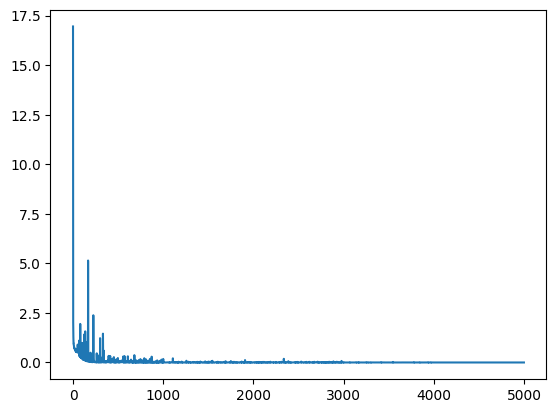

In [10]:
i = 0
loss_list = []
for loss in l_lst:
    loss_list.append(loss.to('cpu').detach().numpy())
np.save('loss.npy', loss_list)
plot_loss(l_lst)

In [11]:
import joblib
joblib.dump(model.state_dict(), 'model_green.joblib')

['model_green.joblib']